# Investigate eclipses of SDSS J160036.83+272117.8

TODO:
* Encapsulate more cells below within functions to clean up namespace. As of 2015-07-03, arrays are duplicated between `dataframes` and `models` so that it is clear what version of the data was used for each model.
* Modeling sequence:
  * Find initial best_period from Lomb-Scargle model to CRTS data.
  * As of 2015-07-03, the MCMC models are chained, i.e. the posterior of the Lomb-Scargle models becomes the prior of the segmeted model.  Combine  MCMC models so that the combined model accepts (best_period, phase_rel_int, phase_rel_ext, flux_pri, flux_out, flux_sec, flux_sigma). Simpler model eleminates several items below. Also initialize with `scipy.optimize.leastsq`
 
  - Not correcting millisecond timestamps: For the McDonald data, I'm using the timestamps from the counter-timer card, which drift by ~-6 microseconds/second. I never finished the timestamp validation module, but what exists is a good starting point for others (https://github.com/ccd-utexas/tsphot/blob/pipeline/verify_timestamps.py). For this project, my uncorrected timestamps are sufficiently accurate (timestamps at end of 4-hour run are off by ~-0.8 seconds). Time estimate to complete the timestamp validation module: 2 days.
  > TODO: Top priority. Do correct this so that data can be used in years since.

  - Not converting or separating filters: I'm combining time series data from both McDonald, which is in a BG40 filter (400-550 nm), with that from Catalina Real Time Survey, which is in V (500-550 nm). I'm not converting the relative fluxes from BG40 to V because the light levels for the depths eclipses are not statistically different, so there's nothing to be gained by converting the BG40 relative flux. The other approach is to model the light curves separately, but that requires a more complex model (similar to section 3 of Hogg et al 2010 http://arxiv.org/pdf/1008.4686v1.pdf). Time estimate to convert the data: 2 days.
  > TODO: Show that data are not statistically different.

  - Mixed Bayesian/frequentist approach for outliers: I'm removing outliers using Bonferroni-corrected p-values, which is a frequentist approach. I'm doing this in sequence with Bayesian MCMC. This is inconsistent from a statistical perspective (also section 3 of Hogg et al 2010 http://arxiv.org/pdf/1008.4686v1.pdf), but it shouldn't make any difference in the final result. Time estimate to use Bayesian MCMC for outliers: 2 days.
  > TODO: Do use Bayesian techniques consistently.

  - Unregularized period model (01_...png, 02_...png attached): The McDonald data is oversampled between phases wrapped 0.8-0.1 (~5000 data points) compared to the CRTS data, which evenly samples the entire phase space (~400 data points). This causes the Lomb-Scargle model for the period to weight the McDonald data points much more than the CRTS. However, I'm only using the model to fit the period over a ~0.1 second range, so the variance in flux will not change the result. Regularization will help fix the flux values because it penalizes large values for Fourier coefficients. (Resampling the data evenly isn't an option because you then lose the tight constraints from the McDonald data set, but the fit is better in 02_...png.) Time estimate to regularize: 2 days.
  > TODO: Do use regularized model. Plot not representative of physical model.

  - Limited info for NOV limits, limb darkening (attached pdfs): At McDonald, I didn't collect much data out of eclipse, and all data was collected at high airmass. My choice of polynomial to correct differential extinction has a large effect on the flux values and the light curve shape. For this reason, I would be hesitant to believe much in the way of NOV limits or limb darkening coefficients. Time estimate for each of these: 2 days.
  > TODO: See photo of black board. Limb darkening is for smaller-radius WD being occulted and may not be really interesting. Primary eclipse is flat in totality because is occultation.
  
  * Ephemeris under estimates duration of eclipse because eclipse is not trapezoidal. Change the fitting function to be quadratic in minima, cubic in ingress/egress, constant out of eclipse. BCs are continuity and first-differentiability.


Note: This star was already known to eclipse: http://www.aavso.org/vsx/index.php?view=detail.top&oid=385873

## Initialization

### Imports

**Note:** As of 2015-02-21, code folding from https://github.com/ipython-contrib/IPython-notebook-extensions/wiki/Home_3x
and https://github.com/ipython-contrib/IPython-notebook-extensions/wiki/Codefolding_v3 is not stable for IPython 3x when using a Python 2x kernel. Do not import.

`cd` to directory where https://github.com/stharrold/Harrold_2015_SDSSJ1600 was downloaded in order to import `code`.

In [1]:
cd /Users/samharrold/Documents/GitHub/stharrold/2015_Harrold_SDSSJ1600

/Users/samharrold/Documents/GitHub/stharrold/2015_Harrold_SDSSJ1600


In [2]:
# TODO: remove unnecessary imports
# Import standard packages.
from __future__ import absolute_import, division, print_function
import collections
import datetime as dt
import copy
import csv
import itertools
import os
import json
import warnings
# Import third-party installed packages.
import astroML.density_estimation as astroML_dens
import astroML.plotting as astroML_plt
import astroML.stats as astroML_stats
import astroML.time_series as astroML_ts
import astropy.constants as astropy_con
import astropy.time as astropy_time
import astropy.units as astropy_units
import emcee
import gatspy.periodic as gatspy_per
import gatspy.datasets as gatspy_data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytz
import scipy.constants as scipy_con
import scipy.optimize as scipy_opt
import scipy.signal as scipy_sig
import seaborn as sns
import statsmodels.api as sm
import triangle
# Import local packages.
# TODO: remove autoreload after testing
%load_ext autoreload
%autoreload 2
# Using pre-release version of binstarsolver from 2015-05-05:
# https://github.com/ccd-utexas/binstarsolver/commit/f3968617445c017ffacd30b9f6587ff5b028338f
import binstarsolver as bss
import code # from https://github.com/stharrold/Harrold_2015_SDSSJ1600
# IPython magic.
%matplotlib inline

### Globals

In [3]:
warnings.simplefilter('once') # Only display warnings once.
sns.set() # Set matplotlib styles by seaborn.

## Extract, transform, load data

In [4]:
dataframes = code.utils.Container()
path_project = os.path.abspath(
    r'/Users/samharrold/Google Drive/ccd.utexas/Projects/20140630_SDSS_J160036.83+272117.8')

### Catalina Real-Time Transient Survey

About Catalina Real-Time Survey: http://crts.caltech.edu/#research

To fetch the data for SDSS J160036.83+272117.8:
- Navigate to http://nesssi.cacr.caltech.edu/DataRelease/ > click "Search for photometry in a single `location`."  
- Input coordinates:
  - RA: 16 00 36.8
  - DEC: +27 21 17
- Click download.
- **Notes:**
  - CRTS photometry is in Vmag (from http://nesssi.cacr.caltech.edu/DataRelease/).
  - The photometry is from the Catalina Sky Survey Schmidt telescope, Steward Observatory, Tucson, Arizona (from http://nesssi.cacr.caltech.edu/DataRelease/ > "Check image coverage by `location`." and from individual coverage maps http://crts.caltech.edu/Telescopes.html). Telescope location (longitude, latitude): (-110 deg 43.9 min West, +32 deg 25 min North) = (-110.731667 deg, 32.4166667 deg) (from http://www.lpl.arizona.edu/css/css_facilities.html).
  - The data timestamp precision is 1e-5 days = ~0.9 seconds. Using the telescope location when converting to Barycentric Coordinate Time (TCB) does not improve the timestamp accuracy since the light travel time across the Earth's radius is ~0.02 sec, which is much less than the timestamp precision.
  - Using Barycentric Coordinate Time relative to Unix epoch as time coordinates so that CRTS data can be combined with other data in units of seconds.
  - Using relative flux so that CRTS data can be combined with other data that is differential photometry, not absolute.

For web-based data exploration, also see the VAO:
- http://www.usvao.org/science-tools-services/time-series-search-tool/ > click "Launch"
- http://vao-web.ipac.caltech.edu/applications/VAOTimeSeries/? > enter Location: 16h00m36.83s +27d21m17.8s, Radius: 10 arcsec
- A single result appears for CACR archive (http://nesssi.cacr.caltech.edu/DataRelease/). Click "display".
- Read the info message about needing to specifiy columns manually. Click "periodogram". An error message will appear "Problem Processing Request".
- Choose the correct data columns. Under Input:
  - Periodogram type: Lomb Scargle
  - Time column: ObsTime
  - Data column: Mag
  - Click "Create Periodogram".

Related structures for this section:
```
dataframes.
    crts.
        all_data
```

`dataframes.crts`: Load original data.

`dataframes.crts.all_data`: Convert time and magnitude units.

`dataframes.crts.all_data`: Plot light curve using pandas plotting utilities.


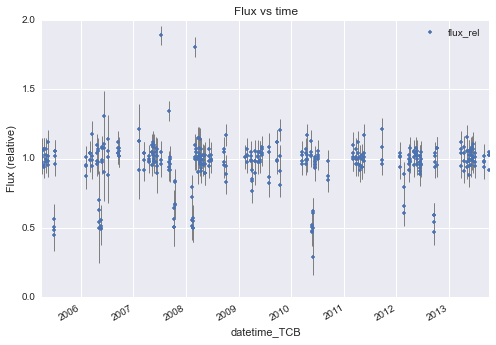


`dataframes.crts.all_data`: First 5 records.


MasterID    Mag  Magerr         RA       Dec          MJD  Blend  \
0  1126078052790  17.45    0.10  240.15338  27.35499  53470.38932      0   
1  1126078052790  17.41    0.10  240.15344  27.35494  53470.39657      0   
2  1126078052790  17.36    0.10  240.15339  27.35497  53470.40384      0   
3  1126078052790  17.39    0.10  240.15336  27.35496  53470.41115      0   
4  1126078052790  17.49    0.09  240.15342  27.35490  53479.38284      0   

                datetime_TCB  unixtime_TCB  flux_rel  flux_rel_err filter  
0 2005-04-10 09:21:55.267443  1.113125e+09  0.972747      0.087989      V  
1 2005-04-10 09:32:21.667452  1.113125e+09  1.009253      0.087989      V  
2 2005-04-10 09:42:49.795462  1.113126e+09  1.056818      0.087989      V  
3 2005-04-10 09:53:21.379472  1.113127e+09  1.028016      0.087989      V  
4 2005-04-19 09:12:35.407440  1.113902e+09  0.937562      0.079550      V

In [5]:
print("`dataframes.crts`: Load original data.")
dataframes.crts = code.utils.Container()
path_crts = os.path.join(
    path_project,
    os.path.relpath(r'Work_Logs/20141203_CRTS_data/result_web_fileovSSl4.csv'))
dataframes.crts.all_data = \
    (pd.DataFrame.from_csv(path=path_crts)).sort(columns='MJD', ascending=True)
dataframes.crts.all_data = dataframes.crts.all_data.reset_index()
print()
print("`dataframes.crts.all_data`: Convert time and magnitude units.")
# For CRTS telescope location, see notes above and http://nesssi.cacr.caltech.edu/DataRelease/
crts_telescope_location = (-110.731667*astropy_units.deg, 32.4166667*astropy_units.deg)
dataframes.crts.all_data['datetime_TCB'] = astropy_time.Time(
    dataframes.crts.all_data['MJD'].values, format='mjd', scale='utc',
    location=crts_telescope_location, precision=6).tcb.datetime
dataframes.crts.all_data['unixtime_TCB'] = astropy_time.Time(
    dataframes.crts.all_data['MJD'].values, format='mjd', scale='utc',
    location=crts_telescope_location, precision=6).tcb.unix
dataframes.crts.all_data['flux_rel'] = \
    map(lambda mag_1: bss.utils.calc_flux_intg_ratio_from_mags(
            mag_1=mag_1, mag_2=dataframes.crts.all_data['Mag'].median()),
        dataframes.crts.all_data['Mag'].values)
dataframes.crts.all_data['flux_rel_err'] = \
    map(lambda mag_1, mag_2: \
        abs(1.0 -
            bss.utils.calc_flux_intg_ratio_from_mags(mag_1=mag_1, mag_2=mag_2)),
        (dataframes.crts.all_data['Mag'] + dataframes.crts.all_data['Magerr']).values,
         dataframes.crts.all_data['Mag'])
dataframes.crts.all_data['filter'] = 'V'
print()
print("`dataframes.crts.all_data`: Plot light curve using pandas plotting utilities.")
df_plot = dataframes.crts.all_data.set_index(keys='datetime_TCB', inplace=False)
ax = pd.DataFrame.plot(
    df_plot[['flux_rel', 'flux_rel_err']], yerr='flux_rel_err',
    marker='.', linestyle='', ecolor='gray', linewidth=1)
ax.set_title("Flux vs time")
ax.set_ylabel("Flux (relative)")
plt.show(ax)
print()
print("`dataframes.crts.all_data`: First 5 records.")
dataframes.crts.all_data.head(n=5)

### McDonald 2.1m, ProEM

SDSS J160036.83+272117.8 was observed from 2014-06-29 to 2014-07-06 at the McDonald Observatory 2.1m telescope using a replacement for the Argos camera (Argos: http://www.as.utexas.edu/mcdonald/facilities/2.1m/argos.html). The replacement is a Princeton Instruments ProEM 1024 EMCCD. See the accompanying IPython Notebooks for the data reduction.

* **Notes:**
  * Relative differential photometry was takent at the McDonald 2.1m with a BG40 filter (http://search.newport.com/?q=*&x2=sku&q2=FSQ-BG40).
  * The McDonald 2.1m is located on Mount Locke near Ft. Davis, TX. Latitude: 30° 40' 17.4" N; Longitude: 104° 01' 21.4" W; Elevation: 2076 m above the geoid; System: WGS84 (http://www.as.utexas.edu/mcdonald/coordinates.html)
  * The data timestamp precision is ~0.3 seconds. **TODO: correct timestamps.** Using the telescope location when converting to Barycentric Coordinate Time (TCB) does not improve the timestamp accuracy since the light travel time across the Earth's radius is ~0.02 sec, which is much less than the timestamp precision.
  - Using Barycentric Coordinate Time relative to Unix epoch as time coordinates so that data can be combined with other data in units of seconds.
  - The data is in units of relative flux.
  
Related structures for this section:
```
dataframes.
    mcd.
        all_data
```

`dataframes.mcd.all_data`: Load original data.

`dataframes.mcd.all_data`: Load steps:
Convert time units to unixtime TCB.
Rename the flux columns and calculate flux errors.
Define the filter column.
Plot light curve using `pandas` plotting utilities.

`dataframes.mcd`: Loading /Users/samharrold/Google Drive/ccd.utexas/Projects/20140630_SDSS_J160036.83+272117.8/Work_Logs/20141018_lightcurves/20140629/SDSS_J160036.83+272117.8_lightcurves_custom.csv


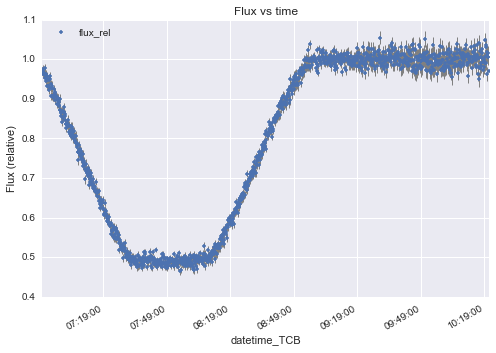


`dataframes.mcd`: Loading /Users/samharrold/Google Drive/ccd.utexas/Projects/20140630_SDSS_J160036.83+272117.8/Work_Logs/20141018_lightcurves/20140630/SDSS_J160036.83+272117.8_lightcurves_custom.csv


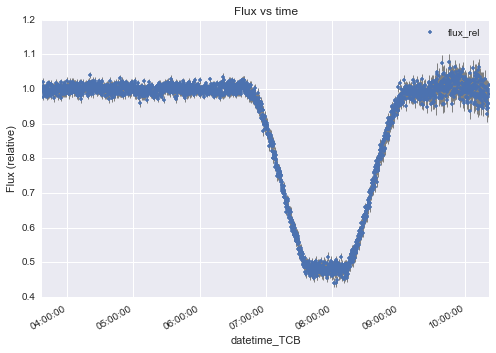


`dataframes.mcd`: Loading /Users/samharrold/Google Drive/ccd.utexas/Projects/20140630_SDSS_J160036.83+272117.8/Work_Logs/20141018_lightcurves/20140701/SDSS_J160036.83+272117.8_lightcurves_custom.csv


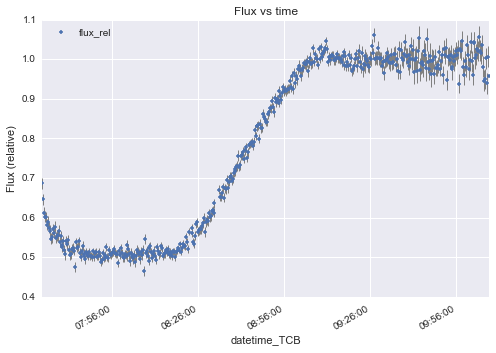


`dataframes.mcd`: Loading /Users/samharrold/Google Drive/ccd.utexas/Projects/20140630_SDSS_J160036.83+272117.8/Work_Logs/20141018_lightcurves/20140702/SDSS_J160036.83+272117.8_BG40-g-r-i-z_lightcurves_custom.csv


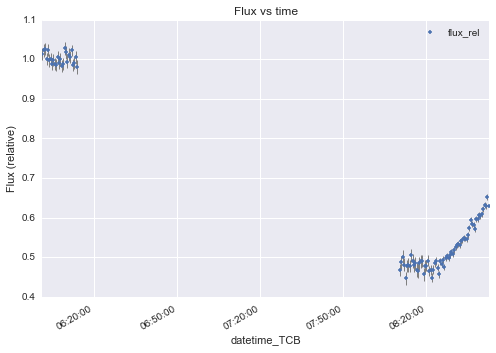


`dataframes.mcd`: Loading /Users/samharrold/Google Drive/ccd.utexas/Projects/20140630_SDSS_J160036.83+272117.8/Work_Logs/20141018_lightcurves/20140703/SDSS_J160036.83+272117.8_BG40-g-r-i-z_lightcurves_custom.csv


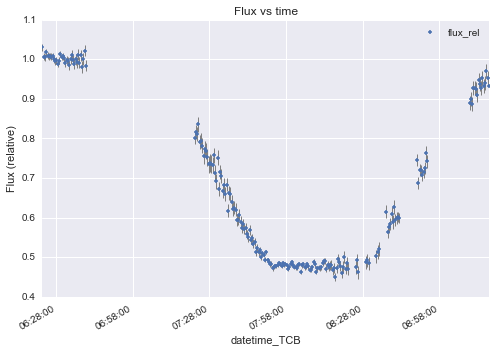


`dataframes.mcd`: Loading /Users/samharrold/Google Drive/ccd.utexas/Projects/20140630_SDSS_J160036.83+272117.8/Work_Logs/20141018_lightcurves/20140704/SDSS_J160036.83+272117.8_BG40-g-r-i-z_lightcurves_custom.csv


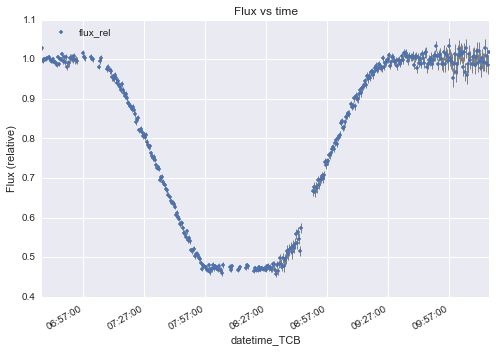


`dataframes.mcd`: Loading /Users/samharrold/Google Drive/ccd.utexas/Projects/20140630_SDSS_J160036.83+272117.8/Work_Logs/20141018_lightcurves/20140706/SDSS_J160036.83+272117.8 2014-07-06 05_25_43_lightcurves_custom.csv


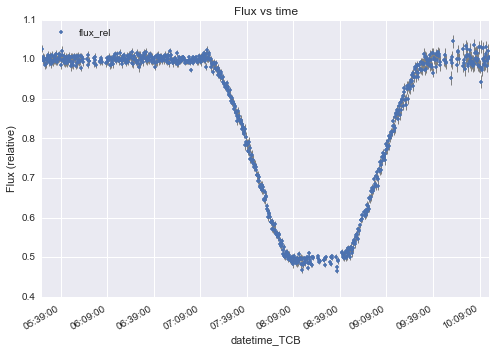


`dataframes.mcd.all_data`: Merge individual runs and create columns
for filename and frame_tracking_number.

`dataframes.mcd.all_data`: First 5 records.


filename  frame_tracking_number  comparisons_sum_flux  \
0  mcd_20140629                      1         225148.776342   
1  mcd_20140629                      2         221423.508320   
2  mcd_20140629                      3         222659.350493   
3  mcd_20140629                      4         223471.600866   
4  mcd_20140629                      5         223730.933450   

   comparisons_sum_normalized_flux               datetime_TCB  \
0                         1.307918 2014-06-29 06:50:17.535700   
1                         1.286277 2014-06-29 06:50:27.535541   
2                         1.293457 2014-06-29 06:50:37.535384   
3                         1.298175 2014-06-29 06:50:47.535227   
4                         1.299681 2014-06-29 06:50:57.535070   

                       datetime_UTC  exposure_end_timestamp_UTC  \
0  2014-06-29 06:48:52.007275+00:00  2014-06-29 06:48:56.999275   
1  2014-06-29 06:49:02.007116+00:00  2014-06-29 06:49:06.999116   
2  2014-06-29 06:49:12.006959+00:00  2014-06-29 06:49:16.998959   
3  2014-06-29 06:49:22.006802+00:00  2014-06-29 06:49:26.998802   
4  2014-06-29 06:49:32.006645+00:00  2014-06-29 06:49:36.998645   

   exposure_mid_timestamp_UTC exposure_start_timestamp_UTC filter  flux_rel  \
0  2014-06-29 06:48:52.007275   2014-06-29 06:48:47.015275   BG40  0.970517   
1  2014-06-29 06:49:02.007116   2014-06-29 06:48:57.015116   BG40  0.975452   
2  2014-06-29 06:49:12.006959   2014-06-29 06:49:07.014959   BG40  0.969970   
3  2014-06-29 06:49:22.006802   2014-06-29 06:49:17.014802   BG40  0.963127   
4  2014-06-29 06:49:32.006645   2014-06-29 06:49:27.014645   BG40  0.962623   

   flux_rel_err   target_flux  target_normalized_flux  target_relative_flux  \
0      0.010325  31933.950577                1.269105              0.141835   
1      0.010325  31565.267221                1.254453              0.142556   
2      0.010325  31563.041380                1.254365              0.141755   
3      0.010325  31454.695334                1.250059              0.140755   
4      0.010325  31474.724597                1.250855              0.140681   

   target_relative_normalized_detrended_flux  target_relative_normalized_flux  \
0                                   0.970517                         0.970517   
1                                   0.975452                         0.975452   
2                                   0.969970                         0.969970   
3                                   0.963127                         0.963127   
4                                   0.962623                         0.962623   

   unixtime_TCB  
0  1.404025e+09  
1  1.404025e+09  
2  1.404025e+09  
3  1.404025e+09  
4  1.404025e+09

In [6]:
print("`dataframes.mcd.all_data`: Load original data.")
dataframes.mcd = code.utils.Container()
dataframes.mcd.all_data = code.utils.Container()
path_mcd = os.path.join(
    path_project,
    os.path.relpath(r'Work_Logs/20141018_lightcurves'))
paths_mcd_csvs = dict(
    mcd_20140629=os.path.relpath(
        r'20140629/SDSS_J160036.83+272117.8_lightcurves_custom.csv'),
    mcd_20140630=os.path.relpath(
        r'20140630/SDSS_J160036.83+272117.8_lightcurves_custom.csv'),
    mcd_20140701=os.path.relpath(
        r'20140701/SDSS_J160036.83+272117.8_lightcurves_custom.csv'),
    mcd_20140702=os.path.relpath(
        r'20140702/SDSS_J160036.83+272117.8_BG40-g-r-i-z_lightcurves_custom.csv'),
    mcd_20140703=os.path.relpath(
        r'20140703/SDSS_J160036.83+272117.8_BG40-g-r-i-z_lightcurves_custom.csv'),
    mcd_20140704=os.path.relpath(
        r'20140704/SDSS_J160036.83+272117.8_BG40-g-r-i-z_lightcurves_custom.csv'),
    mcd_20140706=os.path.relpath(
        r'20140706/SDSS_J160036.83+272117.8 2014-07-06 05_25_43_lightcurves_custom.csv'))
print()
print("`dataframes.mcd.all_data`: Load steps:\n" +
      "Convert time units to unixtime TCB.\n" +
      "Rename the flux columns and calculate flux errors.\n" +
      "Define the filter column.\n" +
      "Plot light curve using `pandas` plotting utilities.")
# For McDonald telescope location, see notes above.
mcd_telescope_location = \
    (-104.022611*astropy_units.deg, 30.6715*astropy_units.deg, 2076.0*astropy_units.meter)
df_dict = dict()
for (key, path_csv) in sorted(paths_mcd_csvs.items()):
    path = os.path.join(path_mcd, path_csv)
    print()
    print("`dataframes.mcd`: Loading {path}".format(path=path))
    df_dict[key] = pd.DataFrame.from_csv(path=path)
    # Convert time units to unixtime TCB.
    # Use only the mid-exposure timestamps.
    df_dict[key]['datetime_UTC'] = \
        df_dict[key]['exposure_mid_timestamp_UTC'].apply(
            lambda date_str: dt.datetime.strptime(
                date_str, '%Y-%m-%d %H:%M:%S.%f').replace(tzinfo=pytz.utc))
    df_dict[key]['datetime_TCB'] = astropy_time.Time(
        df_dict[key]['datetime_UTC'].values, format='datetime', scale='utc',
        location=mcd_telescope_location, precision=6).tcb.datetime
    df_dict[key]['unixtime_TCB'] = astropy_time.Time(
        df_dict[key]['datetime_UTC'].values, format='datetime', scale='utc',
            location=mcd_telescope_location, precision=6).tcb.unix
    # Rename the flux columns and calculate flux errors.
    # NOTE: Flux errors are estimated using a rolling median of the flux differences.
    # This method avoids having to remove artifacts due to the eclipses.
    # The window for the rolling median is 15 minutes in duration.
    # The method is usually within +/- 10% of a rank-based standard deviation.
    # NOTE: The data are not required to be consecutive since using a rolling median
    # is more robust to outliers than a rolling mean.
    try:
        df_dict[key]['flux_rel'] = \
            df_dict[key]['target_relative_normalized_detrended_flux'].copy()
    except KeyError:
        df_dict[key]['flux_rel'] = \
            df_dict[key]['target_relative_normalized_flux'].copy()
    times = df_dict[key]['unixtime_TCB'].values
    times_resolution = np.median(np.diff(times))
    fluxes = df_dict[key]['flux_rel'].values
    fluxes_absdiff = np.abs(np.diff(fluxes))
    window = int(15*scipy_con.minute/times_resolution)
    fluxes_err_roll = np.median(
        code.utils.rolling_window(
            arr=fluxes_absdiff, window=window), axis=1)
    roll_start_idx = int((len(fluxes) - len(fluxes_err_roll))/2.0)
    roll_stop_idx = roll_start_idx + len(fluxes_err_roll)
    fluxes_err = np.interp(
        x=times, xp=times[roll_start_idx:roll_stop_idx], fp=fluxes_err_roll)
    df_dict[key]['flux_rel_err'] = fluxes_err
    # Define the filter column.
    df_dict[key]['filter'] = 'BG40'
    # Plot light curve using pandas plotting utilities.")
    df_plot = df_dict[key].set_index(keys='datetime_TCB', inplace=False)
    ax = pd.DataFrame.plot(
        df_plot[['flux_rel', 'flux_rel_err']], yerr='flux_rel_err',
        marker='.', linestyle='', ecolor='gray', linewidth=1)
    ax.set_title("Flux vs time")
    ax.set_ylabel("Flux (relative)")
    plt.show(ax)
# Merge dataframes.
print()
print("`dataframes.mcd.all_data`: Merge individual runs and create columns\n" +
      "for filename and frame_tracking_number.")
dataframes.mcd.all_data = pd.concat(df_dict, axis=0)
dataframes.mcd.all_data.index.names = ['filename', 'frame_tracking_number']
dataframes.mcd.all_data.reset_index(inplace=True)
dataframes.mcd.all_data.sort(columns='unixtime_TCB', ascending=True, inplace=True)
print()
print("`dataframes.mcd.all_data`: First 5 records.")
dataframes.mcd.all_data.head(n=5)

## Calculate light curve period and phase using Lomb-Scargle light curve model.

* Calculate the single period with Fourier terms that accounts for the most variability of the light curve.
* Using `gatspy` from VanderPlas, Ivezic, 2015 (http://jakevdp.github.io/multiband_LS/, https://github.com/astroML/gatspy/tree/master/examples).
* Using unixtime as time units and manually defining period range and period sampling (c.f. https://github.com/astroML/gatspy/issues/3).

### Model CRTS data, outliers and inliers

Related structures for this section:
```
models.
    ls.
        crts.
            all_data.
                model
                periods.
                    min, max, num, values, delta
                sigs.
                    levels, periods.values, shuffles.num, powers.values
                powers.values
                zoom.
                    periods.
                        num, oversample, halfwidth, min, max, values
                    powers.values
                    sigs.
                        levels, periods.values, shuffles.num, powers.values
                times, phases, fluxes, fluxes_err, filts
                fit.
                    best_period, min_flux_time
                    times, phases, filts, fluxes
```

In [7]:
print("`models.ls.crts.all_data` ('ls' for Lomb-Scargle): Calculate the best period using a Lomb-Scargle\n" +
      "light curve model fit to the CRTS data.")
# NOTE: The concept of Nyquist limits does not apply to irregularly sampled data:
#     VanderPlas and Ivezic, 2015, http://adsabs.harvard.edu/abs/2015arXiv150201344
#     https://github.com/astroML/gatspy/issues/3\n"+
#     However, Nyquist limits are applied as a conservative constraint.")
# NOTE: To fit eclipses well often requires ~6 terms, from section 10.3.3 of
#     Ivezic et al, 2014, 'Statistics, Data Mining, and Machine Learning in Astronomy'
#     More data often requires more terms. Eclipses have even parity, so should the model.
# NOTE: For only the CRTS data with full period range,
#     This cell takes ~10 minutes to execute for a 2.7GHz processor.
#     Initialize gatspy.periodic.optimizer.LinearScanOptimizer
#     Define a period_range to search for periods.
# NOTE: The data from McDonald heavily samples the primary eclipse and biases the
#     Lomb-Scargle model against other phases. Only use the McDonald data for MCMC.
models = code.utils.Container()
models.ls = code.utils.Container()
models.ls.crts = code.utils.Container()
models.ls.crts.all_data = code.utils.Container()
models.ls.crts.all_data.model = gatspy_per.LombScargleMultiband(Nterms_base=6, Nterms_band=1)
models.ls.crts.all_data.model.fit(
    t=dataframes.crts.all_data['unixtime_TCB'].values,
    y=dataframes.crts.all_data['flux_rel'].values,
    dy=dataframes.crts.all_data['flux_rel_err'].values,
    filts=dataframes.crts.all_data['filter'].values)
models.ls.crts.all_data.periods = code.utils.Container()
(models.ls.crts.all_data.periods.min,
 models.ls.crts.all_data.periods.max,
 models.ls.crts.all_data.periods.num) = \
    code.utils.calc_period_limits(
        times=dataframes.crts.all_data['unixtime_TCB'].values)
models.ls.crts.all_data.model.optimizer.period_range = \
    (models.ls.crts.all_data.periods.min, models.ls.crts.all_data.periods.max)
# TODO: remove speedup when done with testing
models.ls.crts.all_data.model.optimizer.period_range = (86680, 86700)
print()
print("models.ls.crts.all_data.model.best_period = {bp} seconds".format(
        bp=models.ls.crts.all_data.model.best_period))
# TODO: remove speedup when done with testing
models.ls.crts.all_data.model.optimizer.period_range = \
    (models.ls.crts.all_data.periods.min, models.ls.crts.all_data.periods.max)

`models.ls.crts.all_data` ('ls' for Lomb-Scargle): Calculate the best period using a Lomb-Scargle
light curve model fit to the CRTS data.

Finding optimal frequency:
 - Using omega_step = 0.00000
 - Computing periods at 5 steps from 86677.54 to 86700.00
Zooming-in on 5 candidate peaks:
 - Computing periods at 1005 steps
models.ls.crts.all_data.model.best_period = 86691.1259531 seconds


`models.ls.crts.all_data`: Estimate significance levels from Lomb-Scargle periodogram.
Plot annotated periodogram of entire searched period space but at
low period resolution.
Dotted vertical line is models.ls.crts.all_data.model.best_period = 86691.1259531 seconds
Dashed lines are significance levels at (95.0, 99.0, 99.9) percentiles.


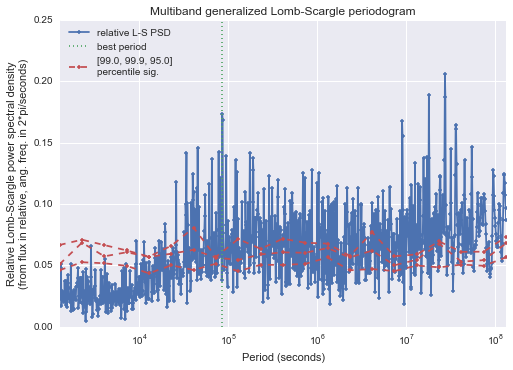

In [8]:
print("`models.ls.crts.all_data`: Estimate significance levels from Lomb-Scargle periodogram.")
print("Plot annotated periodogram of entire searched period space but at\n" +
      "low period resolution.")
# NOTE: This cell takes ~1.5 minutes to execute.
# NOTE: `gatspy` searches period space linearly in angular frequency.")
# NOTE: This periodogram has low period resolution and does not show all
#     periods at their actual power levels.
models.ls.crts.all_data.sigs = code.utils.Container()
models.ls.crts.all_data.sigs.levels = (95.0, 99.0, 99.9)
print("Dotted vertical line is models.ls.crts.all_data.model.best_period = {bp} seconds".format(
        bp=models.ls.crts.all_data.model.best_period))
print("Dashed lines are significance levels at {sigs} percentiles.".format(
        sigs=models.ls.crts.all_data.sigs.levels))
models.ls.crts.all_data.sigs.periods = code.utils.Container()
models.ls.crts.all_data.sigs.periods.values = np.logspace(
    start=np.log10(models.ls.crts.all_data.periods.min),
    stop=np.log10(models.ls.crts.all_data.periods.max),
    num=21, endpoint=True, base=10.0)
models.ls.crts.all_data.sigs.shuffles = code.utils.Container()
models.ls.crts.all_data.sigs.shuffles.num = int(1e4)
# TODO: remove small sig_num_shuffles after done with testing
models.ls.crts.all_data.sigs.shuffles.num = 100
# Calculate significance levels for entire period_range.
models.ls.crts.all_data.periods.values = np.logspace(
    start=np.log10(models.ls.crts.all_data.periods.min),
    stop=np.log10(models.ls.crts.all_data.periods.max),
    num=1001, endpoint=True, base=10.0)
models.ls.crts.all_data.powers = code.utils.Container()
models.ls.crts.all_data.powers.values = models.ls.crts.all_data.model.periodogram(
    periods=models.ls.crts.all_data.periods.values)
models.ls.crts.all_data.sigs.powers = code.utils.Container()
models.ls.crts.all_data.sigs.powers.values = code.utils.calc_sig_levels(
    model=models.ls.crts.all_data.model,
    sig_periods=models.ls.crts.all_data.sigs.periods.values,
    sigs=models.ls.crts.all_data.sigs.levels,
    num_shuffles=models.ls.crts.all_data.sigs.shuffles.num)
code.utils.plot_periodogram(
    periods=models.ls.crts.all_data.periods.values,
    powers=models.ls.crts.all_data.powers.values,
    best_period=models.ls.crts.all_data.model.best_period,
    sig_periods=models.ls.crts.all_data.sigs.periods.values,
    sig_powers=models.ls.crts.all_data.sigs.powers.values,
    xscale='log', period_unit='seconds',
    flux_unit='relative', return_ax=False)

`models.ls.crts.all_data.zoom`: Plot periodogram zoomed in on best_period.
Ensure that period space is sampled at much greater resolution
than the data. Period space is sampled linearly in the zoomed periodogram.


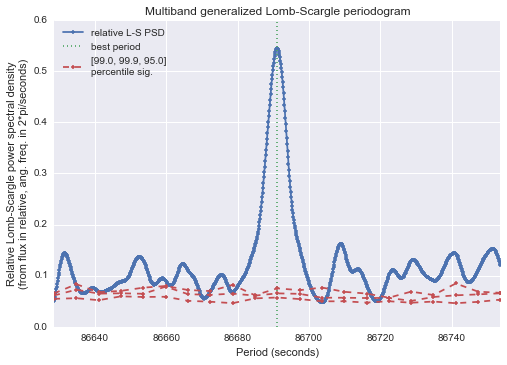

In [9]:
print("`models.ls.crts.all_data.zoom`: Plot periodogram zoomed in on best_period.\n" +
      "Ensure that period space is sampled at much greater resolution\n" +
      "than the data. Period space is sampled linearly in the zoomed periodogram.")
models.ls.crts.all_data.periods.delta = \
    (models.ls.crts.all_data.periods.max - models.ls.crts.all_data.periods.min) / \
     models.ls.crts.all_data.periods.num
models.ls.crts.all_data.zoom = code.utils.Container()
models.ls.crts.all_data.zoom.periods = code.utils.Container()
models.ls.crts.all_data.zoom.periods.num = 1001
models.ls.crts.all_data.zoom.periods.oversample = 0.001
models.ls.crts.all_data.zoom.periods.halfwidth = (
    (models.ls.crts.all_data.zoom.periods.num/2.0) * 
     models.ls.crts.all_data.periods.delta *
     models.ls.crts.all_data.zoom.periods.oversample)
models.ls.crts.all_data.zoom.periods.min = \
    models.ls.crts.all_data.model.best_period - models.ls.crts.all_data.zoom.periods.halfwidth
models.ls.crts.all_data.zoom.periods.max = \
    models.ls.crts.all_data.model.best_period + models.ls.crts.all_data.zoom.periods.halfwidth
models.ls.crts.all_data.zoom.periods.values = np.clip(
    np.linspace(
        start=models.ls.crts.all_data.zoom.periods.min,
        stop=models.ls.crts.all_data.zoom.periods.max,
        num=models.ls.crts.all_data.zoom.periods.num, endpoint=True),
    models.ls.crts.all_data.periods.min,
    models.ls.crts.all_data.periods.max)
models.ls.crts.all_data.zoom.powers = code.utils.Container()
models.ls.crts.all_data.zoom.powers.values = \
    models.ls.crts.all_data.model.periodogram(
        periods=models.ls.crts.all_data.zoom.periods.values)
# Calculate significance levels for zoomed period range.
models.ls.crts.all_data.zoom.sigs = code.utils.Container()
models.ls.crts.all_data.zoom.sigs.levels = models.ls.crts.all_data.sigs.levels
models.ls.crts.all_data.zoom.sigs.periods = code.utils.Container()
models.ls.crts.all_data.zoom.sigs.periods.values = np.linspace(
    start=models.ls.crts.all_data.zoom.periods.min,
    stop=models.ls.crts.all_data.zoom.periods.max,
    num=21, endpoint=True)
models.ls.crts.all_data.zoom.sigs.shuffles = code.utils.Container()
models.ls.crts.all_data.zoom.sigs.shuffles.num = models.ls.crts.all_data.sigs.shuffles.num
models.ls.crts.all_data.zoom.sigs.powers = code.utils.Container()
models.ls.crts.all_data.zoom.sigs.powers.values = code.utils.calc_sig_levels(
    model=models.ls.crts.all_data.model,
    sig_periods=models.ls.crts.all_data.zoom.sigs.periods.values,
    sigs=models.ls.crts.all_data.zoom.sigs.levels,
    num_shuffles=models.ls.crts.all_data.zoom.sigs.shuffles.num)
code.utils.plot_periodogram(
    periods=models.ls.crts.all_data.zoom.periods.values,
    powers=models.ls.crts.all_data.zoom.powers.values,
    best_period=models.ls.crts.all_data.model.best_period,
    sig_periods=models.ls.crts.all_data.zoom.sigs.periods.values,
    sig_powers=models.ls.crts.all_data.zoom.sigs.powers.values,
    xscale='linear', period_unit='seconds',
    flux_unit='relative', return_ax=False)

`models.ls.crts.all_data.fit`: Save fit variables from the Lomb-Scargle light curve model and
plot a phased light curve.


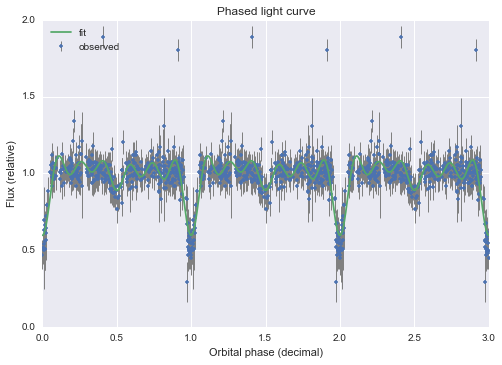


Model is only valid for the times fit:
from 2009-04-02T09:37:41.520Z to 2009-04-03T09:41:05.955Z


In [10]:
print("`models.ls.crts.all_data.fit`: Save fit variables from the Lomb-Scargle light curve model and\n" +
      "plot a phased light curve.")
# TODO: generalize to fitting multiple filters.
models.ls.crts.all_data.times = models.ls.crts.all_data.model.t
models.ls.crts.all_data.fluxes = models.ls.crts.all_data.model.y
models.ls.crts.all_data.fluxes_err = models.ls.crts.all_data.model.dy
models.ls.crts.all_data.filts = models.ls.crts.all_data.model.filts
models.ls.crts.all_data.fit = code.utils.Container()
models.ls.crts.all_data.fit.best_period = models.ls.crts.all_data.model.best_period
models.ls.crts.all_data.fit.min_flux_time = code.utils.calc_min_flux_time(
    model=models.ls.crts.all_data.model,
    filt=models.ls.crts.all_data.filts[0],
    best_period=models.ls.crts.all_data.fit.best_period,
    tol=0.1, maxiter=10)
models.ls.crts.all_data.phases = code.utils.calc_phases(
    times=models.ls.crts.all_data.times,
    best_period=models.ls.crts.all_data.fit.best_period,
    min_flux_time=models.ls.crts.all_data.fit.min_flux_time)
dataframes.crts.all_data['phase_dec'] = models.ls.crts.all_data.phases
# The model is most applicable during times when the data was taken.
models.ls.crts.all_data.fit.times = np.linspace(
    start=np.median(models.ls.crts.all_data.times),
    stop=np.median(models.ls.crts.all_data.times) + models.ls.crts.all_data.fit.best_period,
    num=1000, endpoint=False)
models.ls.crts.all_data.fit.phases = code.utils.calc_phases(
    times=models.ls.crts.all_data.fit.times,
    best_period=models.ls.crts.all_data.fit.best_period,
    min_flux_time=models.ls.crts.all_data.fit.min_flux_time)
# Sort the fit data so that phase is monotonically increasing.
sorted_idxs = np.argsort(models.ls.crts.all_data.fit.phases)
models.ls.crts.all_data.fit.times = models.ls.crts.all_data.fit.times[sorted_idxs]
models.ls.crts.all_data.fit.phases = models.ls.crts.all_data.fit.phases[sorted_idxs]
models.ls.crts.all_data.fit.filts = \
    [models.ls.crts.all_data.filts[0]]*len(models.ls.crts.all_data.fit.phases)
models.ls.crts.all_data.fit.fluxes = models.ls.crts.all_data.model.predict(
    t=models.ls.crts.all_data.fit.times,
    filts=models.ls.crts.all_data.fit.filts,
    period=models.ls.crts.all_data.fit.best_period)
code.utils.plot_phased_light_curve(
    phases=models.ls.crts.all_data.phases,
    fluxes=models.ls.crts.all_data.fluxes,
    fluxes_err=models.ls.crts.all_data.fluxes_err,
    fit_phases=models.ls.crts.all_data.fit.phases,
    fit_fluxes=models.ls.crts.all_data.fit.fluxes,
    flux_unit='relative', return_ax=False)
print()
print(("Model is only valid for the times fit:\n"
       "from {ts_begin}Z to {ts_end}Z").format(
    ts_begin=astropy_time.Time(min(models.ls.crts.all_data.fit.times), format='unix', scale='tcb').utc.isot,
    ts_end=astropy_time.Time(max(models.ls.crts.all_data.fit.times), format='unix', scale='tcb').utc.isot))

### Identify light curve as eclipse

Related structures for this section:
```
models.
    ls.
        crts.
            all_data.
                fit.
                    tess.
                        values
                        min
                    phases
                    fluxes
```

In [11]:
print("`models.ls.crts.all_data.fit`: Identify primary (deepest) and secondary minima.")
print()
print("Classify the light curve as an eclipse if deepest minimum\n" +
      "occurs at phase~0 and 2nd deepest minimum occurs at phase~0.5.")
print()
print("Method for determining minima may not apply to stars with\n" +
      "intrinsic variablity that exceeds the flux varability due\n" +
      "to an eclipse.")
# NOTE: scipy.signal requires a positive slope to identify a previous minimum.
# Append the fit model to itself (tesselate) 1 times for total of 2 cycles
# so that scipy.signal can find minima at all phases.
models.ls.crts.all_data.fit.tess = code.utils.Container()
models.ls.crts.all_data.fit.tess.values = \
    np.asarray(
        zip(np.append(models.ls.crts.all_data.fit.phases,
                      np.add(models.ls.crts.all_data.fit.phases, 1.0)),
            np.append(models.ls.crts.all_data.fit.fluxes,
                      models.ls.crts.all_data.fit.fluxes)),
        dtype=[('phase_dec', float), ('flux_rel', float)])
min_idxs = scipy_sig.argrelmin(models.ls.crts.all_data.fit.tess.values['flux_rel'])
models.ls.crts.all_data.fit.tess.min = models.ls.crts.all_data.fit.tess.values[min_idxs]
# Phase ~1.0 is same as phase ~0.0.
models.ls.crts.all_data.fit.tess.min['phase_dec'] = \
    np.mod(models.ls.crts.all_data.fit.tess.min['phase_dec'], 1.0)
tfmask_phases_gt05 = models.ls.crts.all_data.fit.tess.min['phase_dec'] > 0.5
models.ls.crts.all_data.fit.tess.min['phase_dec'][tfmask_phases_gt05] = \
    np.subtract(1.0, models.ls.crts.all_data.fit.tess.min['phase_dec'][tfmask_phases_gt05])
models.ls.crts.all_data.fit.tess.min = \
    np.sort(np.unique(models.ls.crts.all_data.fit.tess.min), order=['flux_rel', 'phase_dec'])[:2]
tol_phase = 0.01
if (np.isclose(models.ls.crts.all_data.fit.tess.min[0]['phase_dec'], 0.0, atol=tol_phase) and
    np.isclose(models.ls.crts.all_data.fit.tess.min[1]['phase_dec'], 0.5, atol=tol_phase)):
    print()
    print(("Light curve may be an eclipse.\n" +
           "Deepest minima occur at phases 0.0 and 0.5\n" +
           "within phase tolerance {tol}").format(tol=tol_phase))
else:
    print()
    warnings.warn(
        ("Light curve does NOT appear to be an eclipse.\n" +
         "Deepest minima do not occur at phases 0.0 and 0.5\n" +
         "within phase tolerance {tol}").format(tol=tol_phase))

`models.ls.crts.all_data.fit`: Identify primary (deepest) and secondary minima.

Classify the light curve as an eclipse if deepest minimum
occurs at phase~0 and 2nd deepest minimum occurs at phase~0.5.

Method for determining minima may not apply to stars with
intrinsic variablity that exceeds the flux varability due
to an eclipse.

Light curve may be an eclipse.
Deepest minima occur at phases 0.0 and 0.5
within phase tolerance 0.01


### Identify outliers

TODO: redo outlier rejection following section 3 of Hogg et al 2010, http://arxiv.org/pdf/1008.4686v1.pdf

Related structures for this section:
```
models.
    ls.
        crts.
            all_data.
                fluxes_res, fluxes_interp
                phases, fluxes, fluxes_err
                model, z1, z2
                res.
                    model, fit, outlier_test, is_inlier
                fit.phases
            inliers
                z1, z2
dataframes.
    crts.
        all_data
        inliers
```

`models.ls.crts.all_data.res`, `dataframes.crts.all_data`: Plot phased residuals
from Lomb-Scargle light curve model.


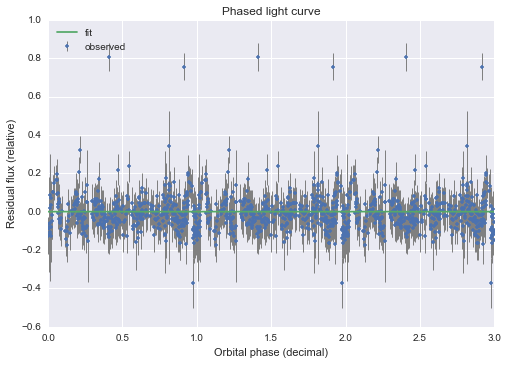

`models.ls.crts.all_data`: Measure Gaussianity of residuals using rank-based statistics.

Departure from Gaussian core: number of sigma, Z1 = 1.72946253061
Departure from Gaussian tail: number of sigma, Z2 = 7.76426353946

Z1 <= 2: The model does not appear to under-fit the data.
Z2 > 2: There may be outliers in the data.


In [12]:
print("`models.ls.crts.all_data.res`, `dataframes.crts.all_data`: Plot phased residuals\n" +
      "from Lomb-Scargle light curve model.")
(models.ls.crts.all_data.fluxes_res, models.ls.crts.all_data.fluxes_interp) = \
    code.utils.calc_residual_fluxes(
        phases=models.ls.crts.all_data.phases,
        fluxes=models.ls.crts.all_data.fluxes,
        fit_phases=models.ls.crts.all_data.fit.phases,
        fit_fluxes=models.ls.crts.all_data.fit.fluxes)
assert np.all(np.isclose(
        models.ls.crts.all_data.fluxes - models.ls.crts.all_data.fluxes_interp,
        models.ls.crts.all_data.fluxes_res))
dataframes.crts.all_data['flux_rel_res'] = models.ls.crts.all_data.fluxes_res
dataframes.crts.all_data['flux_rel_fit'] = models.ls.crts.all_data.fluxes_interp
ax = code.utils.plot_phased_light_curve(
    phases=models.ls.crts.all_data.phases,
    fluxes=models.ls.crts.all_data.fluxes_res,
    fluxes_err=models.ls.crts.all_data.fluxes_err,
    fit_phases=models.ls.crts.all_data.fit.phases,
    fit_fluxes=[0]*len(models.ls.crts.all_data.fit.phases),
    flux_unit='relative', return_ax=True)
ax.set_ylabel('Residual flux (relative)')
plt.show()
print("`models.ls.crts.all_data`: Measure Gaussianity of residuals using rank-based statistics.")
(models.ls.crts.all_data.z1, models.ls.crts.all_data.z2) = \
    code.utils.calc_z1_z2(dist=models.ls.crts.all_data.fluxes_res)
print()
print(("Departure from Gaussian core: number of sigma, Z1 = {z1}\n" +
       "Departure from Gaussian tail: number of sigma, Z2 = {z2}").format(
        z1=models.ls.crts.all_data.z1, z2=models.ls.crts.all_data.z2))
print()
if models.ls.crts.all_data.z1 > 2.0:
    print("Z1 > 2: The model may under-fit the data, i.e. the model may have high bias.")
else:
    print("Z1 <= 2: The model does not appear to under-fit the data.")
if models.ls.crts.all_data.z2 > 2.0:
    print("Z2 > 2: There may be outliers in the data.")
else:
    print("Z2 <= 2: There do not appear to be any outliers in the data.")

`models.ls.crts.all_data`, `dataframes.crts.inliers`: Remove outliers from the residuals using
Bonferroni-corrected p-values.
Fit a constant to the residuals.
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 16 Jul 2015   Prob (F-statistic):                nan
Time:                        09:48:45   Log-Likelihood:                 348.72
No. Observations:                 388   AIC:                            -695.4
Df Residuals:                     387   BIC:                            -691.5
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>

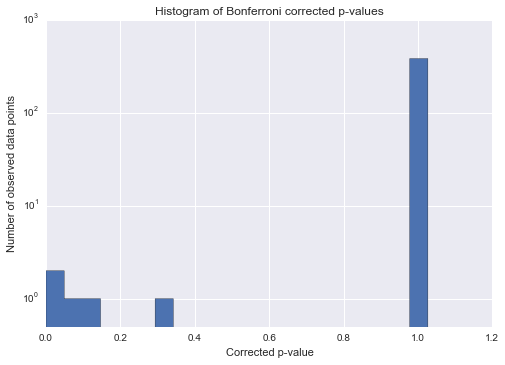

Number of outliers detected: 5


In [13]:
print("`models.ls.crts.all_data`, `dataframes.crts.inliers`: Remove outliers from the residuals using\n" +
      "Bonferroni-corrected p-values.")
models.ls.crts.all_data.res = code.utils.Container()
models.ls.crts.all_data.res.model = \
    sm.OLS(endog=models.ls.crts.all_data.fluxes_res,
           exog=np.ones(len(dataframes.crts.all_data)))
models.ls.crts.all_data.res.fit = models.ls.crts.all_data.res.model.fit()
print("Fit a constant to the residuals.")
print(models.ls.crts.all_data.res.fit.summary())
models.ls.crts.all_data.res.outlier_test = models.ls.crts.all_data.res.fit.outlier_test()
astroML_plt.hist(models.ls.crts.all_data.res.fit.outlier_test()[:, 2],
                 bins='scott', histtype='stepfilled')
plt.title("Histogram of Bonferroni corrected p-values")
plt.xlabel("Corrected p-value")
plt.ylabel("Number of observed data points")
plt.yscale('log')
plt.ylim(0.5, None)
plt.show()
models.ls.crts.all_data.res.is_inlier = \
    np.isclose(models.ls.crts.all_data.res.fit.outlier_test()[:, 2], 1.0)
dataframes.crts.all_data['is_inlier'] = models.ls.crts.all_data.res.is_inlier
print(("Number of outliers detected: {num}").format(
        num=len(dataframes.crts.all_data.loc[
                np.logical_not(dataframes.crts.all_data['is_inlier'])])))
# Create a new dataframe for inliers. Create a copy to prevent altering the original.
dataframes.crts.inliers = dataframes.crts.all_data.loc[
    dataframes.crts.all_data['is_inlier']].copy()

`dataframes.crts.all_data`, `dataframes.crts.inliers`, `models.ls.crts.inliers`:
Plot phased residuals from Lomb-Scargle light curve model with
identified outliers.


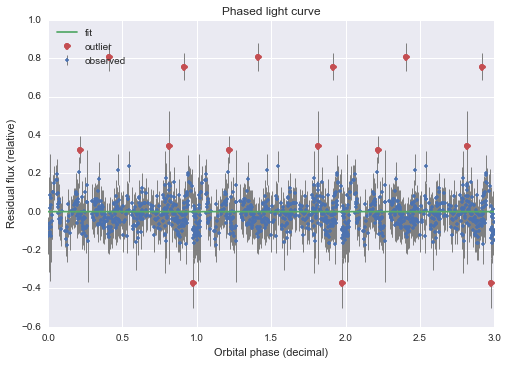

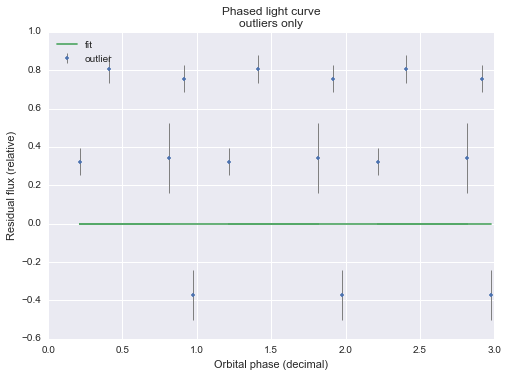

Measure Gaussianity of inlier residuals using rank-based statistics.

Departure from Gaussian core: number of sigma, Z1 = 0.912441145025
Departure from Gaussian tail: number of sigma, Z2 = 1.00588108096

Z1 <= 2: The model does not appear to under-fit the inlier data.
Z2 <= 2: There do not appear to be any remaining outliers in the inlier data.


In [14]:
print("`dataframes.crts.all_data`, `dataframes.crts.inliers`, `models.ls.crts.inliers`:\n" +
      "Plot phased residuals from Lomb-Scargle light curve model with\n" +
      "identified outliers.")
# TODO: Remove 2nd plot
ax = code.utils.plot_phased_light_curve(
    phases=models.ls.crts.all_data.phases,
    fluxes=models.ls.crts.all_data.fluxes_res,
    fluxes_err=models.ls.crts.all_data.fluxes_err,
    fit_phases=models.ls.crts.all_data.fit.phases,
    fit_fluxes=[0]*len(models.ls.crts.all_data.fit.phases),
    flux_unit='relative', return_ax=True)
tfmask_outliers = np.logical_not(models.ls.crts.all_data.res.is_inlier)
ax_outliers = code.utils.plot_phased_light_curve(
    phases=models.ls.crts.all_data.phases[tfmask_outliers],
    fluxes=models.ls.crts.all_data.fluxes_res[tfmask_outliers],
    fluxes_err=models.ls.crts.all_data.fluxes_err[tfmask_outliers],
    fit_phases=models.ls.crts.all_data.phases[tfmask_outliers],
    fit_fluxes=[0.0]*len(tfmask_outliers[tfmask_outliers]),
    flux_unit='relative', return_ax=True)
ax.plot(*ax_outliers.get_lines()[-2].get_data(), label='outlier', marker='o', linestyle='')
ax.set_ylabel('Residual flux (relative)')
ax.legend(loc='upper left')
ax_outliers.set_title('Phased light curve\noutliers only')
ax_outliers.set_ylabel('Residual flux (relative)')
(outlier_handles, outlier_labels) = ax_outliers.get_legend_handles_labels()
outlier_labels[-1] = 'outlier'
ax_outliers.legend(outlier_handles, outlier_labels, loc='upper left')
plt.show()
print("Measure Gaussianity of inlier residuals using rank-based statistics.")
models.ls.crts.inliers = code.utils.Container()
(models.ls.crts.inliers.z1, models.ls.crts.inliers.z2) = \
    code.utils.calc_z1_z2(dist=dataframes.crts.inliers['flux_rel_res'])
print()
print(("Departure from Gaussian core: number of sigma, Z1 = {z1}\n" +
       "Departure from Gaussian tail: number of sigma, Z2 = {z2}").format(
        z1=models.ls.crts.inliers.z1, z2=models.ls.crts.inliers.z2))
print()
if models.ls.crts.inliers.z1 > 2.0:
    print("Z1 > 2: The model may under-fit the inlier data, i.e. the model may have high bias.")
else:
    print("Z1 <= 2: The model does not appear to under-fit the inlier data.")
if models.ls.crts.inliers.z2 > 2.0:
    print("Z2 > 2: There may still be outliers in the inlier data.")
else:
    print("Z2 <= 2: There do not appear to be any remaining outliers in the inlier data.")

### Model inliers only for MCMC

To calculate the best period, model only the inlier data, calculate the best number of terms, and sample the probability space using Bayesian MCMC.

Related structures for this section:
```
models.
    ls.
        crts.
            inliers.
                model
                times, fluxes, fluxes_err, filts
                fit.
                    best_period, min_flux_time,
                    times, phases, filts, fluxes
                phases
                fluxes_res, fluxes_interp
                z1, z2
```

`models.ls.crts.inliers`: Use the model with the best number of terms for the inlier data.

models.ls.crts.inliers.model.best_period = 86691.1259531 seconds

--------------------------------------------------------------------------------
Number of Fourier terms for base model: 1


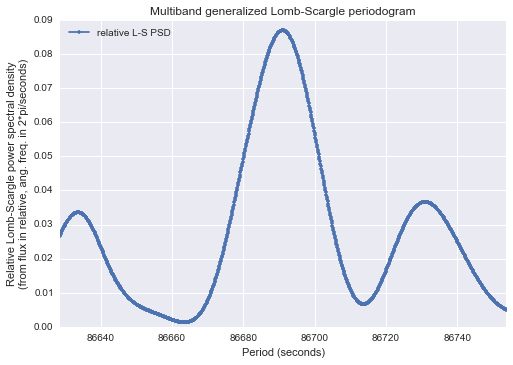

Bayesian Information Criterion: 44.9505678381

--------------------------------------------------------------------------------
Number of Fourier terms for base model: 2


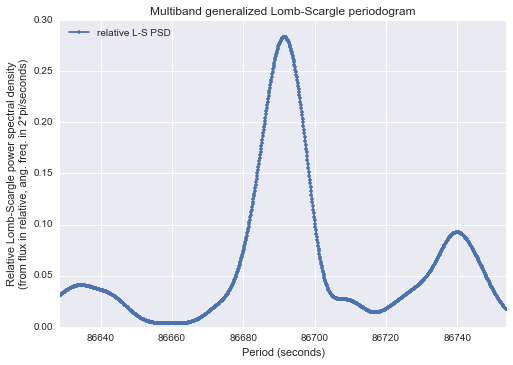

Bayesian Information Criterion: 201.655415682

--------------------------------------------------------------------------------
Number of Fourier terms for base model: 3


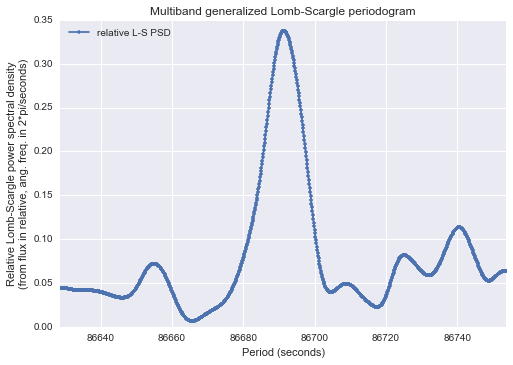

Bayesian Information Criterion: 236.663821337

--------------------------------------------------------------------------------
Number of Fourier terms for base model: 4


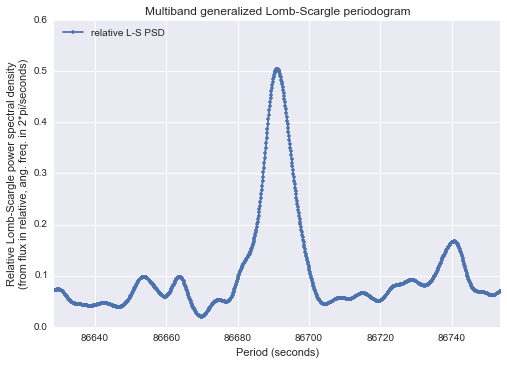

Bayesian Information Criterion: 367.687398983

--------------------------------------------------------------------------------
Number of Fourier terms for base model: 5


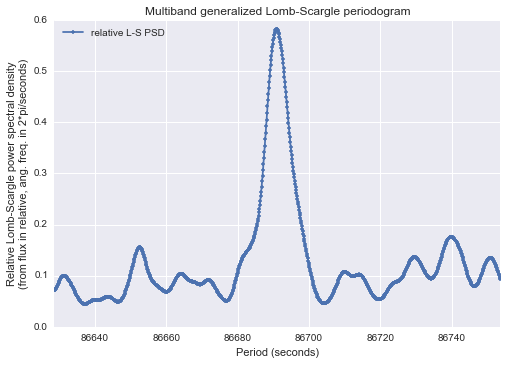

Bayesian Information Criterion: 422.652014286

--------------------------------------------------------------------------------
Number of Fourier terms for base model: 6


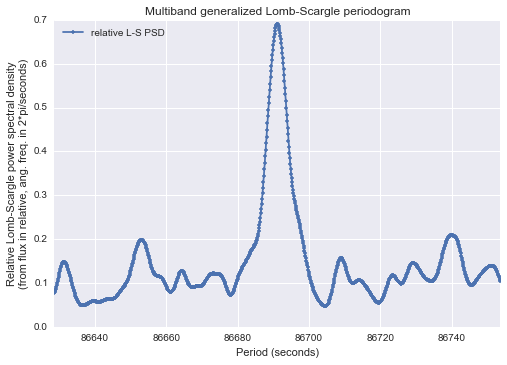

Bayesian Information Criterion: 504.461695688

--------------------------------------------------------------------------------
Number of Fourier terms for base model: 7


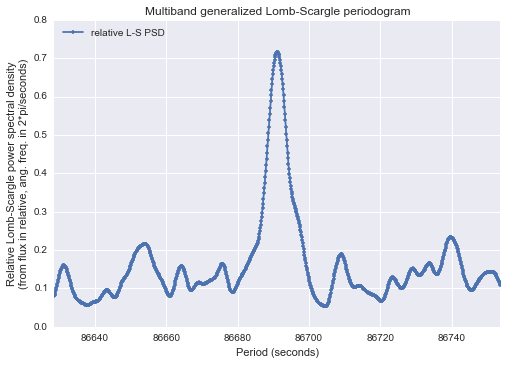

Bayesian Information Criterion: 514.923853655

--------------------------------------------------------------------------------
Number of Fourier terms for base model: 8


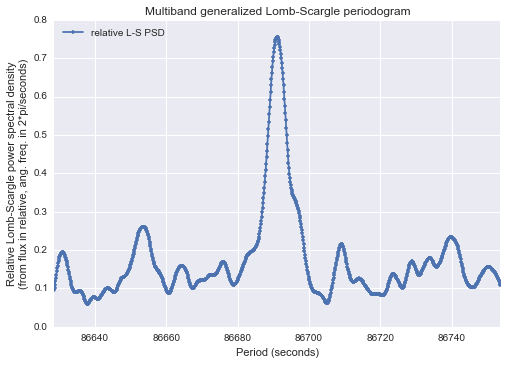

Bayesian Information Criterion: 536.087487855

--------------------------------------------------------------------------------
Number of Fourier terms for base model: 9


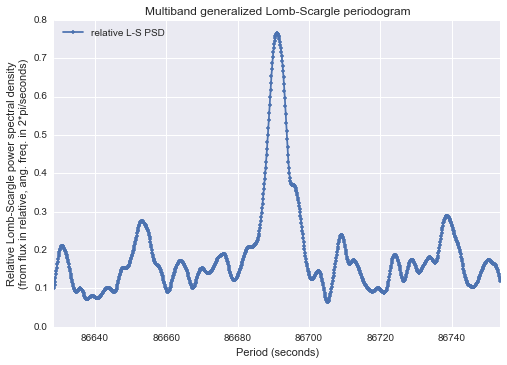

Bayesian Information Criterion: 532.489300815

--------------------------------------------------------------------------------
Number of Fourier terms for base model: 10


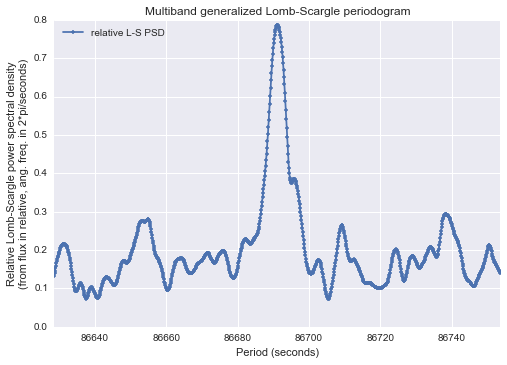

Bayesian Information Criterion: 538.934125592

--------------------------------------------------------------------------------
Number of Fourier terms for base model: 11


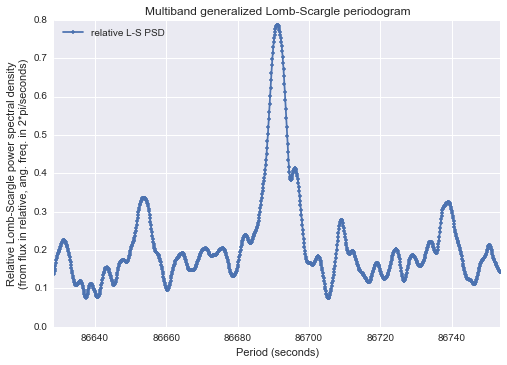

Bayesian Information Criterion: 527.611212163

--------------------------------------------------------------------------------
Number of Fourier terms for base model: 12


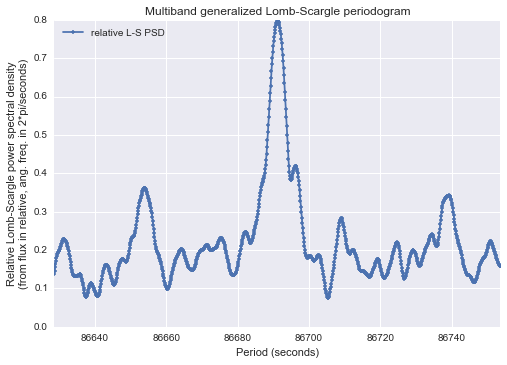

Bayesian Information Criterion: 524.486758328

--------------------------------------------------------------------------------
Number of Fourier terms for base model: 13


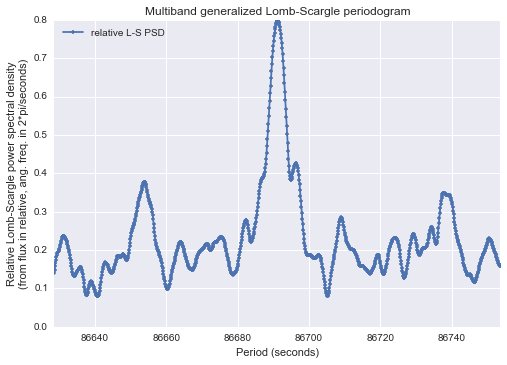

Bayesian Information Criterion: 513.535271556

--------------------------------------------------------------------------------
Number of Fourier terms for base model: 14


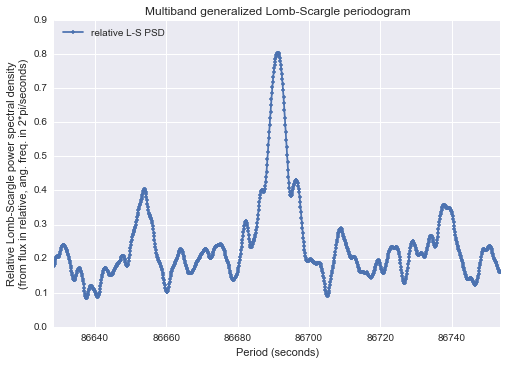

Bayesian Information Criterion: 506.292314064

--------------------------------------------------------------------------------
Number of Fourier terms for base model: 15


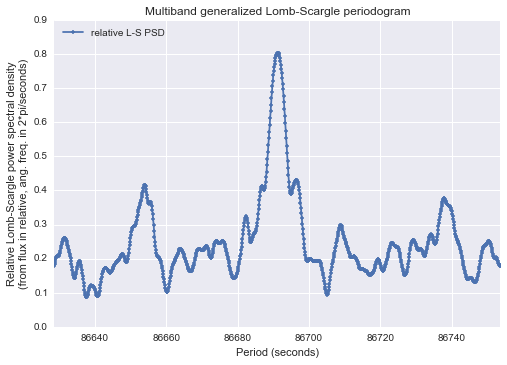

Bayesian Information Criterion: 494.485602805

--------------------------------------------------------------------------------
Number of Fourier terms for base model: 16


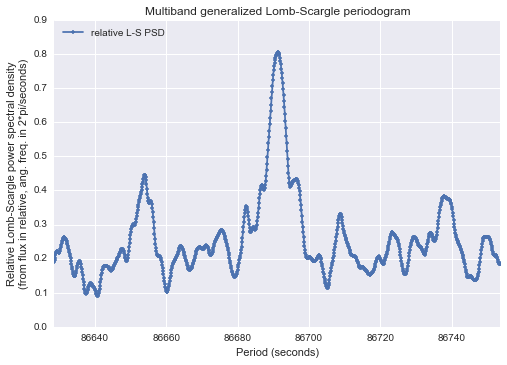

Bayesian Information Criterion: 483.326207258

--------------------------------------------------------------------------------
Number of Fourier terms for base model: 17


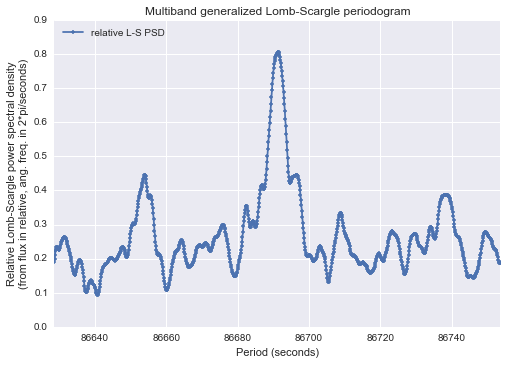

Bayesian Information Criterion: 471.875183407

--------------------------------------------------------------------------------
Number of Fourier terms for base model: 18


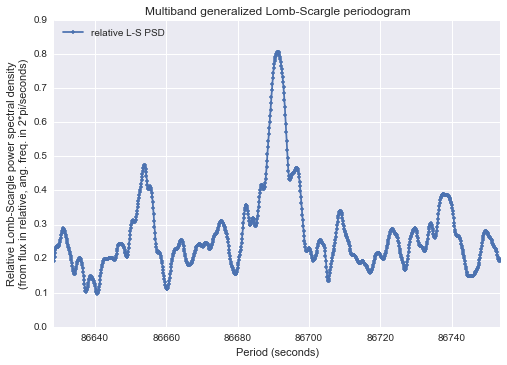

Bayesian Information Criterion: 460.677757136

--------------------------------------------------------------------------------
Number of Fourier terms for base model: 19


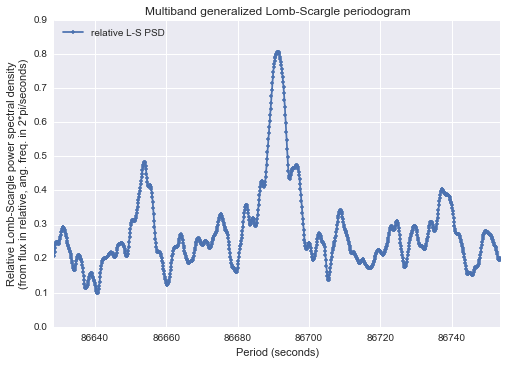

Bayesian Information Criterion: 448.927929804
Finding optimal frequency:
 - Using omega_step = 0.00000
 - Computing periods at 24 steps from 86624.55 to 86753.71
Zooming-in on 5 candidate peaks:
 - Computing periods at 1005 steps
--------------------------------------------------------------------------------


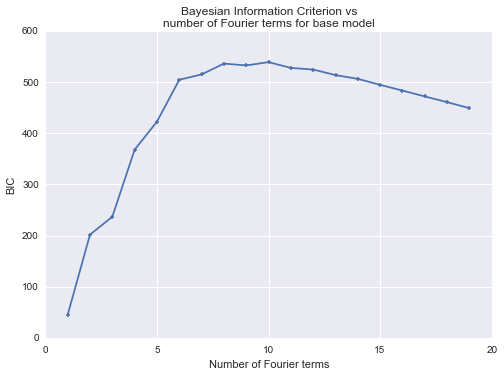

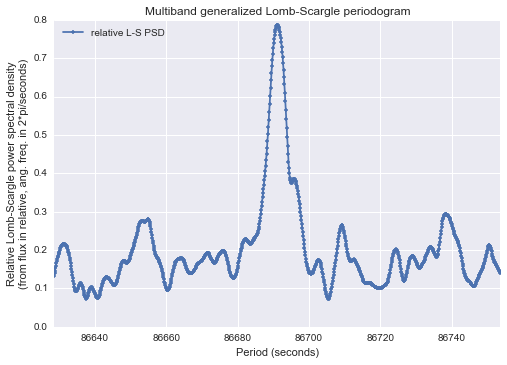

Best number of Fourier terms for base model: 10
Bayesian Information Criterion: 538.934125592
Best period for base model: 86691.1595401 seconds


In [15]:
print("`models.ls.crts.inliers`: Use the model with the best number of terms for the inlier data.")
# Optimize the Lomb-Scargle model, `models.ls.crts.inliers.model`, on inlier data.
models.ls.crts.inliers.model = copy.deepcopy(models.ls.crts.all_data.model)
models.ls.crts.inliers.model.fit(
    t=dataframes.crts.inliers['unixtime_TCB'].values,
    y=dataframes.crts.inliers['flux_rel'].values,
    dy=dataframes.crts.inliers['flux_rel_err'].values,
    filts=dataframes.crts.inliers['filter'].values)
# Use zoomed range from all_data as period_range for inlier data.
models.ls.crts.inliers.model.optimizer.period_range = \
    (models.ls.crts.all_data.zoom.periods.min, models.ls.crts.all_data.zoom.periods.max)
print()
print("models.ls.crts.inliers.model.best_period = {bp} seconds".format(bp=models.ls.crts.inliers.model.best_period))
models.ls.crts.inliers.model = \
    code.utils.calc_nterms_base(
        model=models.ls.crts.inliers.model,
        zoom_periods=models.ls.crts.all_data.zoom.periods.values,
        nterms_base_list=range(1, 20),
        show_summary_plots=True, show_periodograms=True,
        period_unit='seconds', flux_unit='relative')

`models.ls.crts.inliers.fit`: Save fit variables from the Lomb-Scargle light curve model and
plot a phased light curve for inlier data.


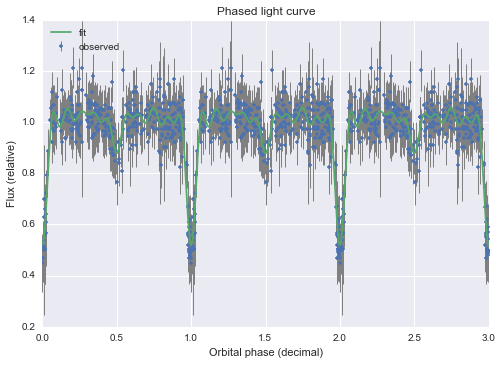


Model is only valid for the times fit:
from 2009-04-02T09:48:08.352Z to 2009-04-03T09:51:32.820Z


In [16]:
print("`models.ls.crts.inliers.fit`: Save fit variables from the Lomb-Scargle light curve model and\n" +
      "plot a phased light curve for inlier data.")
# TODO: generalize to fitting multiple filters.
models.ls.crts.inliers.times = models.ls.crts.inliers.model.t
models.ls.crts.inliers.fluxes = models.ls.crts.inliers.model.y
models.ls.crts.inliers.fluxes_err = models.ls.crts.inliers.model.dy
models.ls.crts.inliers.filts = models.ls.crts.inliers.model.filts
models.ls.crts.inliers.fit = code.utils.Container()
models.ls.crts.inliers.fit.best_period = models.ls.crts.inliers.model.best_period
models.ls.crts.inliers.fit.min_flux_time = code.utils.calc_min_flux_time(
    model=models.ls.crts.inliers.model,
    filt=models.ls.crts.inliers.filts[0],
    best_period=models.ls.crts.inliers.fit.best_period,
    tol=0.1, maxiter=10)
models.ls.crts.inliers.phases = code.utils.calc_phases(
    times=models.ls.crts.inliers.times,
    best_period=models.ls.crts.inliers.fit.best_period,
    min_flux_time=models.ls.crts.inliers.fit.min_flux_time)
dataframes.crts.inliers['phase_dec'] = models.ls.crts.inliers.phases
# The model is most applicable during times when the data was taken.
models.ls.crts.inliers.fit.times = np.linspace(
    start=np.median(models.ls.crts.inliers.times),
    stop=np.median(models.ls.crts.inliers.times) + models.ls.crts.inliers.fit.best_period,
    num=1000, endpoint=False)
models.ls.crts.inliers.fit.phases = code.utils.calc_phases(
    times=models.ls.crts.inliers.fit.times,
    best_period=models.ls.crts.inliers.fit.best_period,
    min_flux_time=models.ls.crts.inliers.fit.min_flux_time)
# Sort the fit data so that phase is monotonically increasing.
sorted_idxs = np.argsort(models.ls.crts.inliers.fit.phases)
models.ls.crts.inliers.fit.times = models.ls.crts.inliers.fit.times[sorted_idxs]
models.ls.crts.inliers.fit.phases = models.ls.crts.inliers.fit.phases[sorted_idxs]
models.ls.crts.inliers.fit.filts = \
    [models.ls.crts.inliers.filts[0]]*len(models.ls.crts.inliers.fit.phases)
models.ls.crts.inliers.fit.fluxes = models.ls.crts.inliers.model.predict(
    t=models.ls.crts.inliers.fit.times,
    filts=models.ls.crts.inliers.fit.filts,
    period=models.ls.crts.inliers.fit.best_period)
code.utils.plot_phased_light_curve(
    phases=models.ls.crts.inliers.phases,
    fluxes=models.ls.crts.inliers.fluxes,
    fluxes_err=models.ls.crts.inliers.fluxes_err,
    fit_phases=models.ls.crts.inliers.fit.phases,
    fit_fluxes=models.ls.crts.inliers.fit.fluxes,
    flux_unit='relative', return_ax=False)
print()
print(("Model is only valid for the times fit:\n"
       "from {ts_begin}Z to {ts_end}Z").format(
    ts_begin=astropy_time.Time(min(models.ls.crts.inliers.fit.times), format='unix', scale='tcb').utc.isot,
    ts_end=astropy_time.Time(max(models.ls.crts.inliers.fit.times), format='unix', scale='tcb').utc.isot))

`models.ls.crts.inliers`, `dataframes.crts.inliers`: Plot phased residuals
from Lomb-Scargle light curve model.


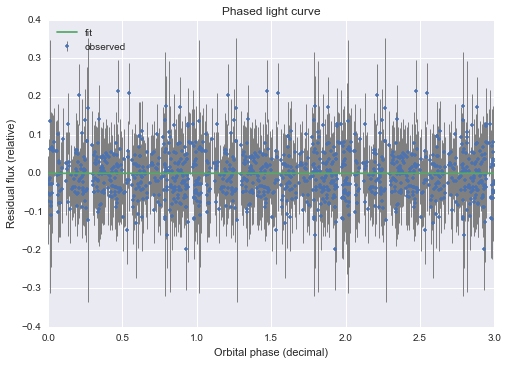

`models.ls.crts.inliers.model`: Measure Gaussianity of residuals using rank-based statistics.

Departure from Gaussian core: number of sigma, Z1 = 1.20967406884
Departure from Gaussian tail: number of sigma, Z2 = 0.693141302078

Z1 <= 2: The model does not appear to under-fit the inlier data.
Z2 <= 2: There do not appear to be any remaining outliers in the inlier data.


In [17]:
print("`models.ls.crts.inliers`, `dataframes.crts.inliers`: Plot phased residuals\n" +
      "from Lomb-Scargle light curve model.")
(models.ls.crts.inliers.fluxes_res, models.ls.crts.inliers.fluxes_interp) = \
    code.utils.calc_residual_fluxes(
        phases=models.ls.crts.inliers.phases,
        fluxes=models.ls.crts.inliers.fluxes,
        fit_phases=models.ls.crts.inliers.fit.phases,
        fit_fluxes=models.ls.crts.inliers.fit.fluxes)
assert np.all(np.isclose(
        models.ls.crts.inliers.fluxes - models.ls.crts.inliers.fluxes_interp,
        models.ls.crts.inliers.fluxes_res))
dataframes.crts.inliers['flux_rel_res'] = models.ls.crts.inliers.fluxes_res
dataframes.crts.inliers['flux_rel_fit'] = models.ls.crts.inliers.fluxes_interp
ax = code.utils.plot_phased_light_curve(
    phases=models.ls.crts.inliers.phases,
    fluxes=models.ls.crts.inliers.fluxes_res,
    fluxes_err=models.ls.crts.inliers.fluxes_err,
    fit_phases=models.ls.crts.inliers.fit.phases,
    fit_fluxes=[0]*len(models.ls.crts.inliers.fit.phases),
    flux_unit='relative', return_ax=True)
ax.set_ylabel('Residual flux (relative)')
plt.show()
print("`models.ls.crts.inliers.model`: Measure Gaussianity of residuals using rank-based statistics.")
(models.ls.crts.inliers.z1, models.ls.crts.inliers.z2) = \
    code.utils.calc_z1_z2(dist=models.ls.crts.inliers.fluxes_res)
print()
print(("Departure from Gaussian core: number of sigma, Z1 = {z1}\n" +
       "Departure from Gaussian tail: number of sigma, Z2 = {z2}").format(
        z1=models.ls.crts.inliers.z1, z2=models.ls.crts.inliers.z2))
print()
if models.ls.crts.inliers.z1 > 2.0:
    print("Z1 > 2: The model may under-fit the inlier data, i.e. the model may have high bias.")
else:
    print("Z1 <= 2: The model does not appear to under-fit the inlier data.")
if models.ls.crts.inliers.z2 > 2.0:
    print("Z2 > 2: There may still be outliers in the inlier data.")
else:
    print("Z2 <= 2: There do not appear to be any remaining outliers in the inlier data.")

### Again identify light curve as eclipse

Related structures for this section:
```
models.
    ls.
        crts.
            inliers.
                fit.
                    tess
                        values
                        min
                    phases
                    fluxes
```

In [18]:
print("`models.ls.crts.inliers.fit`: Identify primary (deepest) and secondary minima.")
print()
print("Classify the light curve as an eclipse if deepest minimum\n" +
      "occurs at phase~0 and 2nd deepest minimum occurs at phase~0.5.")
print()
print("Method for determining minima may not apply to stars with\n" +
      "intrinsic variablity that exceeds the flux varability due\n" +
      "to an eclipse.")
# NOTE: scipy.signal requires a positive slope to identify a previous minimum.
# Append the fit model to itself (tesselate) 1 times for total of 2 cycles
# so that scipy.signal can find minima at all phases.
models.ls.crts.inliers.fit.tess = code.utils.Container()
models.ls.crts.inliers.fit.tess.values = np.asarray(
    zip(np.append(models.ls.crts.inliers.fit.phases,
                  np.add(models.ls.crts.inliers.fit.phases, 1.0)),
        np.append(models.ls.crts.inliers.fit.fluxes,
                  models.ls.crts.inliers.fit.fluxes)),
    dtype=[('phase_dec', float), ('flux_rel', float)])
min_idxs = scipy_sig.argrelmin(models.ls.crts.inliers.fit.tess.values['flux_rel'])
models.ls.crts.inliers.fit.tess.min = models.ls.crts.inliers.fit.tess.values[min_idxs]
# Phase ~1.0 is same as phase ~0.0.
models.ls.crts.inliers.fit.tess.min['phase_dec'] = np.mod(models.ls.crts.inliers.fit.tess.min['phase_dec'], 1.0)
tfmask_phases_gt05 = models.ls.crts.inliers.fit.tess.min['phase_dec'] > 0.5
models.ls.crts.inliers.fit.tess.min['phase_dec'][tfmask_phases_gt05] = \
    np.subtract(1.0, models.ls.crts.inliers.fit.tess.min['phase_dec'][tfmask_phases_gt05])
models.ls.crts.inliers.fit.tess.min = \
    np.sort(np.unique(models.ls.crts.inliers.fit.tess.min), order=['flux_rel', 'phase_dec'])[:2]
tol_phase = 0.01
if (np.isclose(models.ls.crts.inliers.fit.tess.min[0]['phase_dec'], 0.0, atol=tol_phase) and
    np.isclose(models.ls.crts.inliers.fit.tess.min[1]['phase_dec'], 0.5, atol=tol_phase)):
    print()
    print(("Light curve may be an eclipse.\n" +
           "Deepest minima occur at phases 0.0 and 0.5\n" +
           "within phase tolerance {tol}").format(tol=tol_phase))
else:
    print()
    warnings.warn(
        ("\nLight curve does NOT appear to be an eclipse.\n" +
         "Deepest minima do not occur at phases 0.0 and 0.5\n" +
         "within phase tolerance {tol}").format(tol=tol_phase))

`models.ls.crts.inliers.fit`: Identify primary (deepest) and secondary minima.

Classify the light curve as an eclipse if deepest minimum
occurs at phase~0 and 2nd deepest minimum occurs at phase~0.5.

Method for determining minima may not apply to stars with
intrinsic variablity that exceeds the flux varability due
to an eclipse.

Light curve may be an eclipse.
Deepest minima occur at phases 0.0 and 0.5
within phase tolerance 0.01


### Merge CRTS and McDonald data to use for MCMC

TODO: Combine data sets following Hogg et al 2010, http://arxiv.org/pdf/1008.4686v1.pdf

Related structures for this section:
```
dataframes.
    mcd.
        all_data
        inliers
    crts.
        inliers
    combined.
        inliers
```

In [19]:
print("`dataframes.mcd.inliers`: All data from McDonald is initially considered as inliers.")
dataframes.mcd.all_data['is_inlier'] = True
# Create a new dataframe for inliers. Create a copy to prevent altering the original.
dataframes.mcd.inliers = dataframes.mcd.all_data.loc[
    dataframes.mcd.all_data['is_inlier']].copy()

`dataframes.mcd.inliers`: All data from McDonald is initially considered as inliers.


`dataframes.combined.inliers`: Merge CRTS and McDonald inlier data and create columns
for collection and collection_index.

`dataframes.combined.inliers`: Consider V and BG40 as same filter.

`dataframes.combined.inliers`: Plot light curve using pandas plotting utilities.


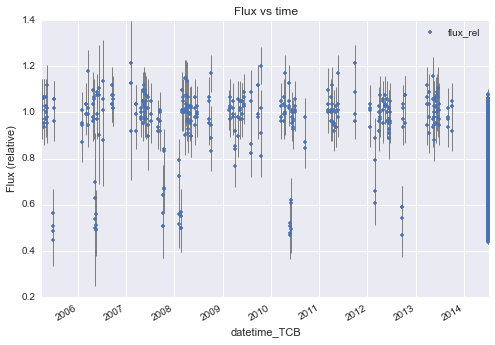


`dataframes.combined.inliers`: Columns.
Index([u'collection', u'collection_index', u'Blend', u'Dec', u'MJD', u'Mag',
       u'Magerr', u'MasterID', u'RA', u'comparisons_sum_flux',
       u'comparisons_sum_normalized_flux', u'datetime_TCB', u'datetime_UTC',
       u'exposure_end_timestamp_UTC', u'exposure_mid_timestamp_UTC',
       u'exposure_start_timestamp_UTC', u'filename', u'filter', u'flux_rel',
       u'flux_rel_err', u'flux_rel_fit', u'flux_rel_res',
       u'frame_tracking_number', u'is_inlier', u'phase_dec', u'target_flux',
       u'target_normalized_flux', u'target_relative_flux',
       u'target_relative_normalized_detrended_flux',
       u'target_relative_normalized_flux', u'unixtime_TCB',
       u'filter_combined'],
      dtype='object')

`dataframes.combined.inliers`: Number of observations.
Total: 5986
crts: 383
mcd: 5603

`dataframes.combined.inliers`: First 5 records.


collection  collection_index  Blend       Dec          MJD    Mag  Magerr  \
0       crts                 0      0  27.35499  53470.38932  17.45    0.10   
1       crts                 1      0  27.35494  53470.39657  17.41    0.10   
2       crts                 2      0  27.35497  53470.40384  17.36    0.10   
3       crts                 3      0  27.35496  53470.41115  17.39    0.10   
4       crts                 4      0  27.35490  53479.38284  17.49    0.09   

       MasterID         RA  comparisons_sum_flux       ...         \
0  1.126078e+12  240.15338                   NaN       ...          
1  1.126078e+12  240.15344                   NaN       ...          
2  1.126078e+12  240.15339                   NaN       ...          
3  1.126078e+12  240.15336                   NaN       ...          
4  1.126078e+12  240.15342                   NaN       ...          

   frame_tracking_number is_inlier phase_dec target_flux  \
0                    NaN      True  0.373410         NaN   
1                    NaN      True  0.380636         NaN   
2                    NaN      True  0.387882         NaN   
3                    NaN      True  0.395167         NaN   
4                    NaN      True  0.336725         NaN   

  target_normalized_flux target_relative_flux  \
0                    NaN                  NaN   
1                    NaN                  NaN   
2                    NaN                  NaN   
3                    NaN                  NaN   
4                    NaN                  NaN   

  target_relative_normalized_detrended_flux target_relative_normalized_flux  \
0                                       NaN                             NaN   
1                                       NaN                             NaN   
2                                       NaN                             NaN   
3                                       NaN                             NaN   
4                                       NaN                             NaN   

   unixtime_TCB  filter_combined  
0  1.113125e+09           V_BG40  
1  1.113125e+09           V_BG40  
2  1.113126e+09           V_BG40  
3  1.113127e+09           V_BG40  
4  1.113902e+09           V_BG40  

[5 rows x 32 columns]

In [20]:
print("`dataframes.combined.inliers`: Merge CRTS and McDonald inlier data and create columns\n" +
      "for collection and collection_index.")
dataframes.combined = code.utils.Container()
dataframes.combined.inliers = pd.concat(
    dict(crts=dataframes.crts.inliers,
         mcd=dataframes.mcd.inliers),
    axis=0)
dataframes.combined.inliers.index.names = ['collection', 'collection_index']
dataframes.combined.inliers.reset_index(inplace=True)
dataframes.combined.inliers.sort(columns='unixtime_TCB', ascending=True, inplace=True)
print()
print("`dataframes.combined.inliers`: Consider V and BG40 as same filter.")
# TODO: Distinguish filters in all models using forulism from gatspy.
dataframes.combined.inliers['filter_combined'] = '_'.join(dataframes.combined.inliers['filter'].unique())
print()
print("`dataframes.combined.inliers`: Plot light curve using pandas plotting utilities.")
df_plot = dataframes.combined.inliers.set_index(keys='datetime_TCB', inplace=False)
ax = pd.DataFrame.plot(
    df_plot[['flux_rel', 'flux_rel_err']], yerr='flux_rel_err',
    marker='.', linestyle='', ecolor='gray', linewidth=1)
ax.set_title("Flux vs time")
ax.set_ylabel("Flux (relative)")
plt.show(ax)
print()
print("`dataframes.combined.inliers`: Columns.")
print(dataframes.combined.inliers.columns)
print()
print(("`dataframes.combined.inliers`: Number of observations.\n" +
       "Total: {num}").format(num=len(dataframes.combined.inliers)))
for collection in sorted(dataframes.combined.inliers['collection'].unique()):
    print(("{col}: {num}").format(
        col=collection,
        num=np.count_nonzero(dataframes.combined.inliers['collection'] == collection)))
print()
print("`dataframes.combined.inliers`: First 5 records.")
dataframes.combined.inliers.head(n=5)

### Calculate probability distribution for periods using Bayesian MCMC.

TODO: Check x-direction fitting against Hogg et al 2010, http://arxiv.org/pdf/1008.4686v1.pdf

Related structures for this section:
```
dataframes.
    combined.
        inliers
models.
    ls.
        crts.
            inliers.
                model
                fit.best_period
        combined.
            inliers.
                model
                times, fluxes, fluxes_err, filts
                mcmc.
                    labels, sampler, nburn_idx, trace
                fit.
                    best_period, *_upr, *_lwr
                    min_flux_time
                    times, phases, filts,
                    fluxes, *_upr, *_lwr
                phases
                fluxes_res, fluxes_interp
                z1, z2
```

`models.ls.combined.inliers`: Initialize MCMC walkers from a small Gaussian ball
around the initial parameters.

`models.ls`: Plot probability distribution of parameters.


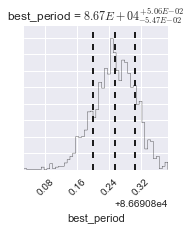


Plot the random walks for each variable.


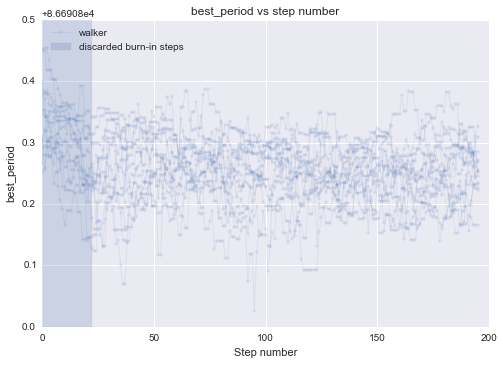

In [21]:
print("`models.ls.combined.inliers`: Initialize MCMC walkers from a small Gaussian ball\n" +
      "around the initial parameters.")
# NOTE: This cell takes ~90 seconds to run.
# Adapted from http://dan.iel.fm/emcee/current/user/line/
models.ls.combined = code.utils.Container()
models.ls.combined.inliers = code.utils.Container()
models.ls.combined.inliers.model = copy.deepcopy(models.ls.crts.inliers.model)
models.ls.combined.inliers.times = dataframes.combined.inliers['unixtime_TCB'].values
models.ls.combined.inliers.fluxes = dataframes.combined.inliers['flux_rel'].values
models.ls.combined.inliers.fluxes_err = dataframes.combined.inliers['flux_rel_err'].values
models.ls.combined.inliers.filts = dataframes.combined.inliers['filter_combined'].values
models.ls.combined.inliers.model.fit(
    t=models.ls.combined.inliers.times,
    y=models.ls.combined.inliers.fluxes,
    dy=models.ls.combined.inliers.fluxes_err,
    filts=models.ls.combined.inliers.filts)
models.ls.combined.inliers.mcmc = code.utils.Container()
models.ls.combined.inliers.mcmc.labels = ('best_period', )
params_init = (models.ls.crts.inliers.fit.best_period, )
ndims = len(params_init)
# Number of walkers and steps is limited by computation time.
nwalkers = 14*ndims
nsteps = 14*nwalkers
# Variance estimate for pos0_vecs was defined after an iteration.
pos0_vecs = [np.add(params_init, np.multiply(params_init, 5e-7)*np.random.randn(ndims))
             for _ in range(nwalkers)]
models.ls.combined.inliers.mcmc.sampler = emcee.EnsembleSampler(
    nwalkers=nwalkers, dim=ndims, lnpostfn=code.utils.ls_log_posterior,
    kwargs=dict(model=models.ls.combined.inliers.model))
models.ls.combined.inliers.mcmc.sampler.run_mcmc(pos0=pos0_vecs, N=nsteps)
# Discard 1*autocorrelation time as burn-in.
models.ls.combined.inliers.mcmc.nburn_idx = \
    int(np.ceil(np.max(models.ls.combined.inliers.mcmc.sampler.acor)))
# Collapse the chain along the axis of the walkers to visualize the parameter distributions.
# np.shape(trace) = (nsteps*nwalkers, ndims)
models.ls.combined.inliers.mcmc.trace = np.reshape(
    models.ls.combined.inliers.mcmc.sampler.chain[:, models.ls.combined.inliers.mcmc.nburn_idx:, :],
    newshape=(-1, ndims))
print()
print("`models.ls`: Plot probability distribution of parameters.")
# For `triangle.corner`:
# `quantiles` are left-tailed p-values (z < `quantile`) at 1 standard devation.
# `levels` are confidence levels (|z| < `level`) at 1 standard deviation.
fig = triangle.corner(
    xs=models.ls.combined.inliers.mcmc.trace,
    labels=models.ls.combined.inliers.mcmc.labels,
    show_titles=True, title_fmt='.2E', scale_hist=False,
    quantiles=[0.1587, 0.5, 0.8413], verbose=False,
    plot_contours=False, plot_datapoints=True,
    data_kwargs={'alpha': 0.1, 'marker': ','})
plt.show(fig)
print()
print("Plot the random walks for each variable.")
for (prm_idx, label) in enumerate(models.ls.combined.inliers.mcmc.labels):
    wkr_label = 'walker'
    for wkr_idx in xrange(len(models.ls.combined.inliers.mcmc.sampler.chain)):
        plt.plot(models.ls.combined.inliers.mcmc.sampler.chain[wkr_idx, :, prm_idx],
                 marker='.', linestyle='-', linewidth=1, alpha=0.1, label=wkr_label,
                 color=sns.color_palette()[0])
        wkr_label = None
    plt.axvspan(0, models.ls.combined.inliers.mcmc.nburn_idx,
                alpha=0.2, label='discarded burn-in steps',
                color=sns.color_palette()[0])
    plt.title("{label} vs step number".format(label=label))
    plt.xlabel("Step number")
    plt.ylabel(label)
    plt.legend(loc='upper left')
    plt.show()

`models.ls.combined.inliers.fit`: Save parameters from the Bayesian MCMC Lomb-Scargle
light curve model and plot phased light curves.
Because `best_period` was fit, the variance is in the x direction.
NOTE: This model is not regularized. The poor fit is due to oversampling from phases
0.8 wrapped through 0.1 (the McDonald data). Only the period is fit in a <0.1 second range
using this model.


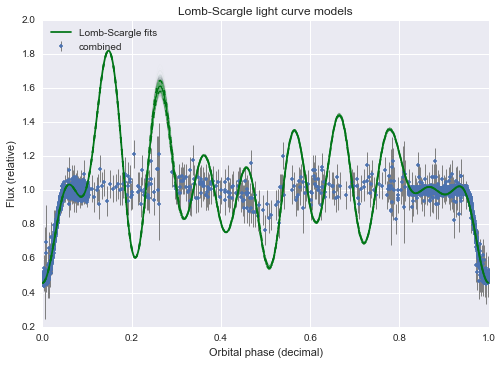


Model is only valid for the times fit:
from 2014-06-30T07:20:06.796Z to 2014-07-01T07:23:31.159Z


In [22]:
print("`models.ls.combined.inliers.fit`: Save parameters from the Bayesian MCMC Lomb-Scargle\n" +
      "light curve model and plot phased light curves.")
print("Because `best_period` was fit, the variance is in the x direction.")
print("NOTE: This model is not regularized. The poor fit is due to oversampling from phases\n" +
      "0.8 wrapped through 0.1 (the McDonald data). Only the period is fit in a <0.1 second range\n" +
      "using this model.")
# Save the -1*sigma, median, and +1*sigma values for the parameters.
# Percentiles are left-tailed p values (z < `percentile`) at 1 standard devation.
models.ls.combined.inliers.fit = code.utils.Container()
for (prm_idx, label) in enumerate(models.ls.combined.inliers.mcmc.labels):
    map(lambda lbl, pct: \
        setattr(models.ls.combined.inliers.fit, lbl, pct),
        (label+'_lwr', label, label+'_upr'),
        np.percentile(models.ls.combined.inliers.mcmc.trace[:, prm_idx],
                      q=[15.87, 50.0, 84.13], axis=0))
models.ls.combined.inliers.fit.min_flux_time = code.utils.calc_min_flux_time(
    model=models.ls.combined.inliers.model,
    filt=models.ls.combined.inliers.filts[0],
    best_period=models.ls.combined.inliers.fit.best_period,
    tol=0.1, maxiter=10)
models.ls.combined.inliers.phases = code.utils.calc_phases(
    times=models.ls.combined.inliers.times,
    best_period=models.ls.combined.inliers.fit.best_period,
    min_flux_time=models.ls.combined.inliers.fit.min_flux_time)
dataframes.combined.inliers['phase_dec'] = models.ls.combined.inliers.phases
# The model is most applicable during times when the data was taken.
models.ls.combined.inliers.fit.times = np.linspace(
    start=np.median(models.ls.combined.inliers.times),
    stop=np.median(models.ls.combined.inliers.times) + models.ls.combined.inliers.fit.best_period,
    num=1000, endpoint=False)
# TODO: make into function that accepts an ISO8601 timestamp and predicts model starting at that time.
#     Function would modify models.ls.combined.inliers.fit.times to start at given time.
models.ls.combined.inliers.fit.phases = code.utils.calc_phases(
    times=models.ls.combined.inliers.fit.times,
    best_period=models.ls.combined.inliers.fit.best_period,
    min_flux_time=models.ls.combined.inliers.fit.min_flux_time)
# Sort the fit data so that phase is monotonically increasing.
sorted_idxs = np.argsort(models.ls.combined.inliers.fit.phases)
models.ls.combined.inliers.fit.times = models.ls.combined.inliers.fit.times[sorted_idxs]
models.ls.combined.inliers.fit.phases = models.ls.combined.inliers.fit.phases[sorted_idxs]
models.ls.combined.inliers.fit.filts = \
    [models.ls.combined.inliers.filts[0]]*len(models.ls.combined.inliers.fit.phases)
random_traces = models.ls.combined.inliers.mcmc.trace[
    np.random.randint(len(models.ls.combined.inliers.mcmc.trace), size=1000)]
fluxes_arr = \
    map(lambda prm: \
        models.ls.combined.inliers.model.predict(
            t=models.ls.combined.inliers.fit.times,
            filts=models.ls.combined.inliers.fit.filts,
            period=prm[0]),
        random_traces)
(models.ls.combined.inliers.fit.fluxes_lwr,
 models.ls.combined.inliers.fit.fluxes,
 models.ls.combined.inliers.fit.fluxes_upr) = \
    np.percentile(fluxes_arr,
                  q=[15.87, 50.0, 84.13], axis=0)
plt.errorbar(
    models.ls.combined.inliers.phases,
    models.ls.combined.inliers.fluxes,
    models.ls.combined.inliers.fluxes_err,
    ecolor='gray', marker='.', linestyle='', linewidth=1,
    label='combined', color=sns.color_palette()[0])
plt.plot(
    models.ls.combined.inliers.fit.phases,
    models.ls.combined.inliers.fit.fluxes,
    marker='', linestyle='-', label='Lomb-Scargle fits',
    color=sns.color_palette(name='dark')[1])
plt.plot(
    models.ls.combined.inliers.fit.phases,
    models.ls.combined.inliers.fit.fluxes_lwr,
    marker='', linestyle='--', label=None,
    color=sns.color_palette(name='dark')[1])
plt.plot(
    models.ls.combined.inliers.fit.phases,
    models.ls.combined.inliers.fit.fluxes_upr,
    marker='', linestyle='--', label=None,
    color=sns.color_palette(name='dark')[1])
for fluxes in fluxes_arr:
    plt.plot(
        models.ls.combined.inliers.fit.phases,
        fluxes,
        marker='', linestyle='-', linewidth=1, alpha=0.01,
        label=None, color=sns.color_palette()[1])
plt.title("Lomb-Scargle light curve models")
plt.xlabel("Orbital phase (decimal)")
plt.ylabel("Flux (relative)")
plt.legend(loc='upper left')
plt.show()
print()
print(("Model is only valid for the times fit:\n"
       "from {ts_begin}Z to {ts_end}Z").format(
    ts_begin=astropy_time.Time(min(models.ls.combined.inliers.fit.times), format='unix', scale='tcb').utc.isot,
    ts_end=astropy_time.Time(max(models.ls.combined.inliers.fit.times), format='unix', scale='tcb').utc.isot))

`models.ls.combined.inliers`, `dataframes.combined.inliers`: Plot phased residuals
from Lomb-Scargle light curve model.


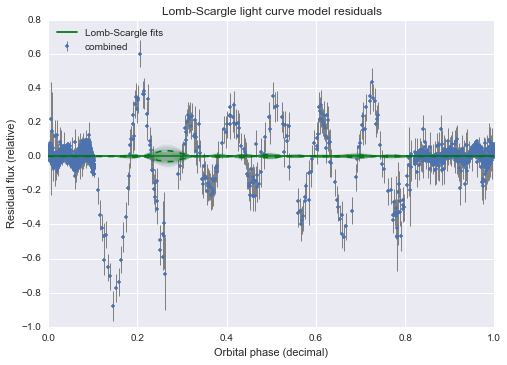

For a given phase observed between
2014-06-30T07:20:06.796 and 2014-07-01T07:23:31.159
these are the expected errors from the model.

`models.ls.combined.inliers`: Measure Gaussianity of residuals using rank-based statistics.

Departure from Gaussian core: number of sigma, Z1 = 3.64303175533
Departure from Gaussian tail: number of sigma, Z2 = 82.0871890639

Z1 > 2: The model may under-fit the inlier data, i.e. the model may have high bias.
Z2 > 2: There may still be outliers in the inlier data.


In [23]:
print("`models.ls.combined.inliers`, `dataframes.combined.inliers`: Plot phased residuals\n" +
      "from Lomb-Scargle light curve model.")
(models.ls.combined.inliers.fluxes_res, models.ls.combined.inliers.fluxes_interp) = \
    code.utils.calc_residual_fluxes(
        phases=models.ls.combined.inliers.phases,
        fluxes=models.ls.combined.inliers.fluxes,
        fit_phases=models.ls.combined.inliers.fit.phases,
        fit_fluxes=models.ls.combined.inliers.fit.fluxes)
assert np.all(np.isclose(
        models.ls.combined.inliers.fluxes - models.ls.combined.inliers.fluxes_interp,
        models.ls.combined.inliers.fluxes_res))
dataframes.combined.inliers['flux_rel_res'] = models.ls.combined.inliers.fluxes_res
dataframes.combined.inliers['flux_rel_fit'] = models.ls.combined.inliers.fluxes_interp
plt.errorbar(
    models.ls.combined.inliers.phases,
    models.ls.combined.inliers.fluxes_res,
    models.ls.combined.inliers.fluxes_err,
    ecolor='gray', marker='.', linestyle='', linewidth=1,
    label='combined', color=sns.color_palette()[0])
plt.plot(
    models.ls.combined.inliers.fit.phases,
    [np.median(models.ls.combined.inliers.fluxes_res)]*len(models.ls.combined.inliers.fit.phases),
    marker='', linestyle='-', label='Lomb-Scargle fits',
    color=sns.color_palette(name='dark')[1])
plt.plot(
    models.ls.combined.inliers.fit.phases,
    models.ls.combined.inliers.fit.fluxes_upr - models.ls.combined.inliers.fit.fluxes,
    marker='', linestyle='--', label=None,
    color=sns.color_palette(name='dark')[1])
plt.plot(
    models.ls.combined.inliers.fit.phases,
    models.ls.combined.inliers.fit.fluxes_lwr - models.ls.combined.inliers.fit.fluxes,
    marker='', linestyle='--', label=None,
    color=sns.color_palette(name='dark')[1])
for fluxes in fluxes_arr:
    plt.plot(
        models.ls.combined.inliers.fit.phases,
        fluxes - models.ls.combined.inliers.fit.fluxes,
        marker='', linestyle='-', linewidth=1, alpha=0.01,
        label=None, color=sns.color_palette()[1])
plt.title("Lomb-Scargle light curve model residuals")
plt.xlabel("Orbital phase (decimal)")
plt.ylabel("Residual flux (relative)")
plt.legend(loc='upper left')
plt.show()
print(("For a given phase observed between\n" +
       "{ts_begin} and {ts_end}\n" +
       "these are the expected errors from the model.").format(
        ts_begin=astropy_time.Time(min(models.ls.combined.inliers.fit.times), format='unix', scale='tcb').utc.isot,
        ts_end=astropy_time.Time(max(models.ls.combined.inliers.fit.times), format='unix', scale='tcb').utc.isot))
# TODO: plot expected errors as a function of time over years.
print()
print("`models.ls.combined.inliers`: Measure Gaussianity of residuals using rank-based statistics.")
(models.ls.combined.inliers.z1, models.ls.combined.inliers.z2) = \
    code.utils.calc_z1_z2(dist=models.ls.combined.inliers.fluxes_res)
print()
print(("Departure from Gaussian core: number of sigma, Z1 = {z1}\n" +
       "Departure from Gaussian tail: number of sigma, Z2 = {z2}").format(
        z1=models.ls.combined.inliers.z1, z2=models.ls.combined.inliers.z2))
print()
if models.ls.combined.inliers.z1 > 2.0:
    print("Z1 > 2: The model may under-fit the inlier data, i.e. the model may have high bias.")
else:
    print("Z1 <= 2: The model does not appear to under-fit the inlier data.")
if models.ls.combined.inliers.z2 > 2.0:
    print("Z2 > 2: There may still be outliers in the inlier data.")
else:
    print("Z2 <= 2: There do not appear to be any remaining outliers in the inlier data.")

### Again identify light curve as eclipse

Related structures for section:
```
models.
    ls.
        combined.
            inliers.
                fit.
                    phases, fluxes
                    tess.
                        values, min
```

In [24]:
print("`models.ls.combined.inliers.fit`: Identify primary (deepest) and secondary minima.")
print()
print("Classify the light curve as an eclipse if deepest minimum\n" +
      "occurs at phase~0 and 2nd deepest minimum occurs at phase~0.5.")
print()
print("Method for determining minima may not apply to stars with\n" +
      "intrinsic variablity that exceeds the flux varability due\n" +
      "to an eclipse.")
# NOTE: scipy.signal requires a positive slope to identify a previous minimum.
# Append the fit model to itself (tesselate) 1 times for total of 2 cycles
# so that scipy.signal can find minima at all phases.
models.ls.combined.inliers.fit.tess = code.utils.Container()
models.ls.combined.inliers.fit.tess.values = np.asarray(
    zip(np.append(models.ls.combined.inliers.fit.phases,
                  np.add(models.ls.combined.inliers.fit.phases, 1.0)),
        np.append(models.ls.combined.inliers.fit.fluxes,
                  models.ls.combined.inliers.fit.fluxes)),
    dtype=[('phase_dec', float), ('flux_rel', float)])
min_idxs = scipy_sig.argrelmin(models.ls.combined.inliers.fit.tess.values['flux_rel'])
models.ls.combined.inliers.fit.tess.min = models.ls.combined.inliers.fit.tess.values[min_idxs]
# Phase ~1.0 is same as phase ~0.0.
models.ls.combined.inliers.fit.tess.min['phase_dec'] = np.mod(models.ls.combined.inliers.fit.tess.min['phase_dec'], 1.0)
tfmask_phases_gt05 = models.ls.combined.inliers.fit.tess.min['phase_dec'] > 0.5
models.ls.combined.inliers.fit.tess.min['phase_dec'][tfmask_phases_gt05] = \
    np.subtract(1.0, models.ls.combined.inliers.fit.tess.min['phase_dec'][tfmask_phases_gt05])
models.ls.combined.inliers.fit.tess.min = \
    np.sort(np.unique(models.ls.combined.inliers.fit.tess.min), order=['flux_rel', 'phase_dec'])[:2]
tol_phase = 0.01
if (np.isclose(models.ls.combined.inliers.fit.tess.min[0]['phase_dec'], 0.0, atol=tol_phase) and
    np.isclose(models.ls.combined.inliers.fit.tess.min[1]['phase_dec'], 0.5, atol=tol_phase)):
    print()
    print(("Light curve may be an eclipse.\n" +
           "Deepest minima occur at phases 0.0 and 0.5\n" +
           "within phase tolerance {tol}").format(tol=tol_phase))
else:
    print()
    warnings.warn(
        ("\nLight curve does NOT appear to be an eclipse.\n" +
         "Deepest minima do not occur at phases 0.0 and 0.5\n" +
         "within phase tolerance {tol}").format(tol=tol_phase))

`models.ls.combined.inliers.fit`: Identify primary (deepest) and secondary minima.

Classify the light curve as an eclipse if deepest minimum
occurs at phase~0 and 2nd deepest minimum occurs at phase~0.5.

Method for determining minima may not apply to stars with
intrinsic variablity that exceeds the flux varability due
to an eclipse.

Light curve may be an eclipse.
Deepest minima occur at phases 0.0 and 0.5
within phase tolerance 0.01


## Calculate eclipse event phases and flux levels using segmented, symmetric light curve model.

This model simulates the eclipses as trapezoids, which treats the stars as spherical and detached with no limb darkening using https://pypi.python.org/pypi/binstarsolver.

Segmented model description:
```
Segmented, symmetric eclipse light curve model:
Durations of primary minimum and secondary minimum are equal.
Durations of primary ingress/egress and secondary ingress/egress are equal.
Light curve is segmented into functions f(x).
x values are `phase`, p0, p1, ...

light      |  |  |--------|  |  |
curve:     |  | /|        |\\|__|
           |__|/ |        |  |  |
function:  |f0|f1|   f2   |f3|f4|
phase:     p0 p1 p2       p3 p4 p5

boundary condition:       p0     = 0.0
primary minima:           f0(x)  = b0; 0.0 <= x < p1
boundary condition:       f0(p1) = f1(p1)
primary ingress/egress:   f1(x)  = m1*x + b1; p1 <= x < p2
boundary condition:       f1(p2) = f2(p2)
between minima:           f2(x)  = b2; p2 <= x < p3
boundary condition:       f2(p3) = f3(p3)
secondary ingress/egress: f3(x)  = m3*x + b3; p3 <= x < p4
boundary condition:       f3(p4) = f4(p4)
secondary minima:         f4(x)  = b4; p4 <= x <= 0.5
boundary condition:       p4     = p5 - p1
boundary condition:       p3     = p5 - p2
boundary contition:       p5     = 0.5
```

When combined with the Lomb-Scargle model, the completes set of parameters is:  
`(best_period, min_flux_time, phase_rel_int, phase_rel_ext, flux_pri_eclipse, flux_out_eclipse, flux_sec_eclipse)`  

Parameter description:
* `best_period`: Single period that best represents the variability in the light curve.
* `min_flux_time`: Time offset so that phase=0 at primary minimum.
* `phase_rel_int`: Relative phase of internal tangencies (end ingress/begin egress; `p1`, `p4` above).
* `phase_rel_ext`: Relative phase of external tangencies (begin ingress/end egress; `p2`, `p3` above).
* `flux_pri_eclipse`: Flux at primary minimum (`f0` above).
* `flux_out_eclipse`: Flux for phases that occur between minima (`f2` above).
* `flux_sec_eclipse`: Flux at secondary minimum (`f4` above).
* `flux_sigma`: Standard deviation of relative fluxes.

Note:
* Period and phase are computed using Lomb-Scargle generalized periodogram above.
* Model parameters are defined relative to primary minima since primary minima are deeper and easier to detect from observations.
* The out-of-eclipse flux level (f2 above), is left variable as a normalization factor following Budding, 2007, "Introduction to Astronomical Photometry".

The posterior distribution of the parameters is computed using Bayesian MCMC following:  
* Hogg et al: http://arxiv.org/abs/1008.4686
* Emcee docs: http://dan.iel.fm/emcee/current/user/line/
* Vanderplas blog, 2014: https://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/
* http://nbviewer.ipython.org/url/jakevdp.github.io/downloads/notebooks/FreqBayes4.ipynb
* Vanderplas, 2014: http://arxiv.org/pdf/1411.5018v1.pdf  
TODO: include point rejection and errors in model

### Initalize segmented, symmetric eclipse light curve model

The model is initialized to the estimated parameters with the maximimum likelihood before computing the posterior distribution of parameters using Bayesian MCMC. The data points are assumed to all be drawn from the same distribution. The variance of that distribution is modeled from the variance of the data. Observed errors are not taken as input

Related structures for this section:
```
dataframes.
    combined.
        inliers
models.
    ls.
        combined.
            inliers.
                fit.
                    tess.
                        min
                    phases
                    fluxes
    seg.
        combined.
            inliers.
                fit.
                    events
                    ls.
                        phases
                        fluxes
                phases
                fluxes
                fluxes_err
```

`models.seg.combined.inliers.fit` ('seg' for segmented): Estimate phases and fluxes of eclipse
events from Lomb-Scargle fits. Use as the initial parameters for the segmented model.
Model assumes light curve is symmetric about phase ~0.5 and that durations
of ingress/egress are equivalent.

`models.seg.combined.inliers`: The model light curve assumes symmetry about
phase=0.5. Folding the light curve also accommodates irregularly sampled data.
Plot initial guess for Bayesian MCMC fitting.


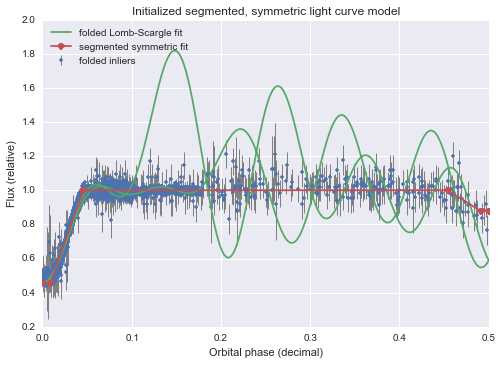

event  flux_rel  phase_dec
0         primary_minimum  0.457170   0.000000
1    primary_int_tangency  0.457170   0.009039
2    primary_ext_tangency  1.000727   0.046039
3  secondary_ext_tangency  1.000727   0.453961
4  secondary_int_tangency  0.878777   0.490961
5       secondary_minimum  0.878777   0.500000

In [25]:
print("`models.seg.combined.inliers.fit` ('seg' for segmented): Estimate phases and fluxes of eclipse\n" +
      "events from Lomb-Scargle fits. Use as the initial parameters for the segmented model.\n" +
      "Model assumes light curve is symmetric about phase ~0.5 and that durations\n" +
      "of ingress/egress are equivalent.")
# Initialize primary minima from the Lomb-Scargle model fit to the combined data.
# Initialize secondary minima from the Lomb-Scargle model fit to the CRTS inlier data
# since in the combined data, the McDonald data oversamples phases 0.8 wrapped to 0.1.
# Fix the phases to 0.0, 0.5.
flux_pri_min = models.ls.combined.inliers.fit.tess.min[0]['flux_rel']
flux_sec_min = models.ls.crts.inliers.fit.tess.min[1]['flux_rel']
# Flux out-of-eclipse: median of observed flux for phases away from eclipse events
# e.g. 0.1 < phase < 0.4 or 0.6 < phase < 0.9
# Flux sigma: median of observed flux errors
tfmask_phases_out_eclipse = \
    np.logical_or(
        np.logical_and(
            (0.1 < dataframes.combined.inliers['phase_dec']),
            (dataframes.combined.inliers['phase_dec'] < 0.4)),
        np.logical_and(
            (0.6 < dataframes.combined.inliers['phase_dec']),
            (dataframes.combined.inliers['phase_dec'] < 0.9)))
(flux_out_eclipse, flux_sigma) = dataframes.combined.inliers.loc[
    tfmask_phases_out_eclipse, ['flux_rel', 'flux_rel_err']].median().values
# Initialize the relative internal and external phases from the primary eclispe
# due to higher SNR. Use the combined data for higher data resoltuion.
# Relative phase internal tangency (end ingress/begin egress):
# when fit flux becomes > primary min flux level + 3*flux sigma
# Relative phase external tangency (begin ingress/end egress):
# when fit flux becomes > out-of-eclise flux level - 3*flux sigma
# (0.5* and -3*flux sigma yields more accurate first guess for phase_rel_ext
# since this method to initialize the model underestimates the eclipse duration)
# Indexes out of primary totality:
tfmask_out_pritot = (models.ls.combined.inliers.fit.fluxes > flux_pri_min + 3.0*flux_sigma)
phase_rel_int = min(models.ls.combined.inliers.fit.phases[tfmask_out_pritot])
# Indexes out of eclipse:
tfmask_out_eclipse = (models.ls.combined.inliers.fit.fluxes > flux_out_eclipse - 3.0*flux_sigma)
phase_rel_ext = min(models.ls.combined.inliers.fit.phases[tfmask_out_eclipse])
# Create events dataframe within `models.seg.combined.inliers.fit`.
models.seg = code.utils.Container()
models.seg.combined = code.utils.Container()
models.seg.combined.inliers = code.utils.Container()
models.seg.combined.inliers.fit = code.utils.Container()
params = (phase_rel_int, phase_rel_ext, flux_pri_min,
          flux_out_eclipse, flux_sec_min, flux_sigma)
events = ['primary_minimum', 'primary_int_tangency', 'primary_ext_tangency',
          'secondary_ext_tangency', 'secondary_int_tangency', 'secondary_minimum']
phases = np.asarray([0.0, phase_rel_int, phase_rel_ext,
                     0.5-phase_rel_ext, 0.5-phase_rel_int, 0.5])
fluxes = code.utils.seg_model_fluxes_rel(params=params, phases=phases)
models.seg.combined.inliers.fit.events = pd.DataFrame.from_dict(
    data={'event' : events,
          'phase_dec' : phases,
          'flux_rel' : fluxes},
    orient='columns')
# Check that the data frame was modified correctly
# by checking that it is sorted and symmetric about phase=0.5.
assert np.all(models.seg.combined.inliers.fit.events.index == 
              models.seg.combined.inliers.fit.events.sort(columns='phase_dec').index)
for idx in range(int(len(models.seg.combined.inliers.fit.events)/2.0)):
    assert np.isclose(
        (models.seg.combined.inliers.fit.events.iloc[idx]['phase_dec'] + 
         models.seg.combined.inliers.fit.events.iloc[-idx-1]['phase_dec']),
        0.5)
print()
print("`models.seg.combined.inliers`: The model light curve assumes symmetry about\n" +
      "phase=0.5. Folding the light curve also accommodates irregularly sampled data.")
tfmask_lt05 = dataframes.combined.inliers['phase_dec'].values < 0.5
models.seg.combined.inliers.phases = np.where(
    tfmask_lt05,
    dataframes.combined.inliers['phase_dec'].values,
    1.0 - dataframes.combined.inliers['phase_dec'].values)
models.seg.combined.inliers.fluxes = dataframes.combined.inliers['flux_rel'].values
models.seg.combined.inliers.fluxes_err = dataframes.combined.inliers['flux_rel_err'].values
# Include the Lomb-Scargle fit for comparison.
# NOTE: The Lomb-Scargle fit for the combined data is only fit to the phase, not the flux.
models.seg.combined.inliers.fit.ls = code.utils.Container()
models.seg.combined.inliers.fit.ls.times = models.ls.combined.inliers.fit.times
tfmask_ls_lt05 = models.ls.combined.inliers.fit.phases < 0.5
models.seg.combined.inliers.fit.ls.phases = np.where(
    tfmask_ls_lt05,
    models.ls.combined.inliers.fit.phases,
    1.0 - models.ls.combined.inliers.fit.phases)
models.seg.combined.inliers.fit.ls.fluxes = models.ls.combined.inliers.fit.fluxes
models.seg.combined.inliers.fit.phases = models.seg.combined.inliers.fit.events['phase_dec'].values
models.seg.combined.inliers.fit.fluxes = models.seg.combined.inliers.fit.events['flux_rel'].values
print("Plot initial guess for Bayesian MCMC fitting.")
plt.errorbar(
    models.seg.combined.inliers.phases,
    models.seg.combined.inliers.fluxes,
    models.seg.combined.inliers.fluxes_err,
    ecolor='gray', marker='.', linestyle='', linewidth=1,
    label='folded inliers')
plt.plot(models.seg.combined.inliers.fit.ls.phases,
         models.seg.combined.inliers.fit.ls.fluxes,
         marker='', linestyle='-', label='folded Lomb-Scargle fit')
plt.plot(models.seg.combined.inliers.fit.phases, models.seg.combined.inliers.fit.fluxes,
         marker='o', linestyle='-', label='segmented symmetric fit')
plt.title("Initialized segmented, symmetric light curve model")
plt.xlabel("Orbital phase (decimal)")
plt.ylabel("Flux (relative)")
plt.legend(loc='upper left')
plt.show()
models.seg.combined.inliers.fit.events

### Calculate probability distribution for eclipse event phases and flux levels using Bayesian MCMC.

Related structures for this section:
```
dataframes.
    combined.
        inliers
models.
    ls.
        combined.
            inliers.
    seg.
        combined.
            inliers.
                mcmc.
                    labels.
                        phase_rel_int, phase_rel_ext,
                        flux_pri_eclipse, flux_out_eclipse, flux_sec_eclipse
                        flux_sigma
                    sampler, nburn_idx, trace
                    phases, fluxes
                fit.
                    events, phases,
                    fluxes, *_lwr, *_upr
                    phase_rel_int, *_lwr, *_upr
                    phase_rel_ext, *_lwr, *_upr
                    flux_pri_eclipse, *_lwr, *_upr
                    flux_out_eclipse, *_lwr, *_upr
                    flux_sec_eclipse, *_lwr, *_upr
                    flux_sigma, *_lwr, *_upr
                    ls.
                        times
                phases, fluxes, fluxes_err, fluxes_res, fluxes_interp
                z1, z2
```

Initialize walkers from a small Gaussian ball around the initial parameters.

`models.seg`: Plot probability distribution of parameters.


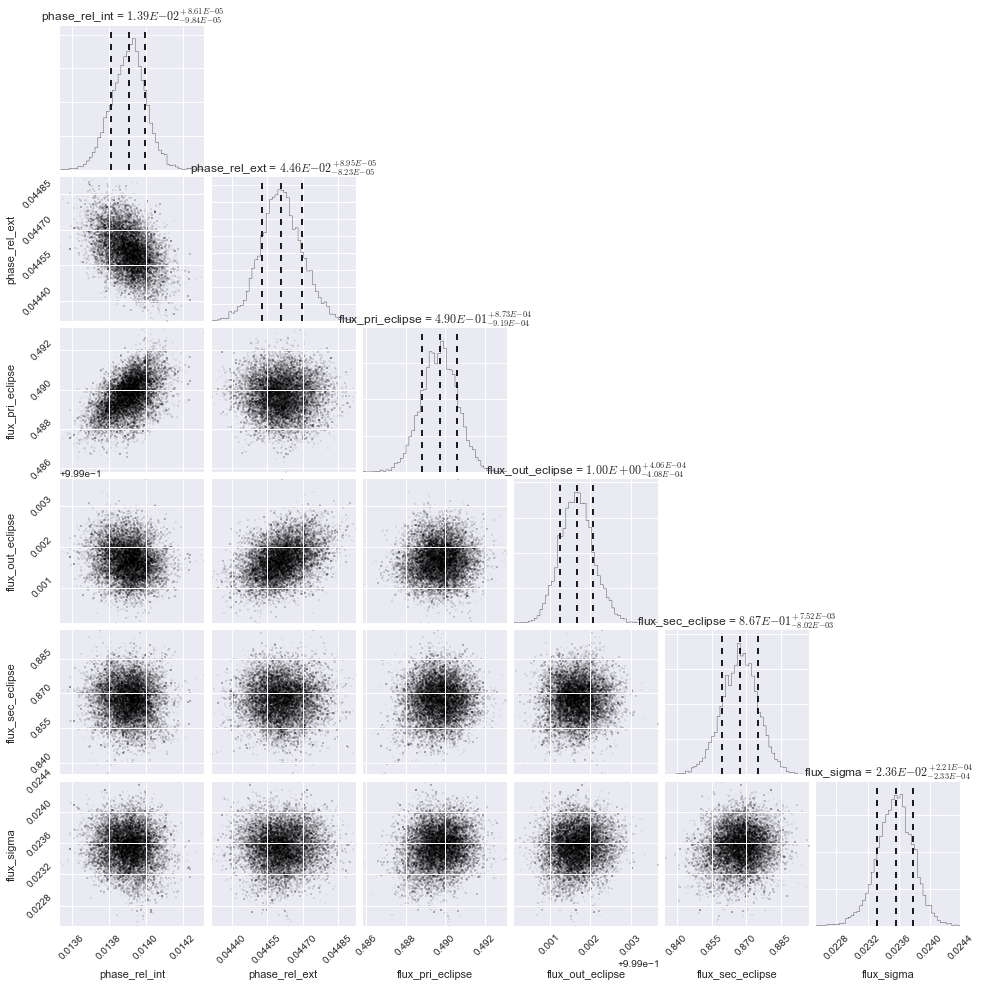


`models.seg`: Plot the random walks for each variable.


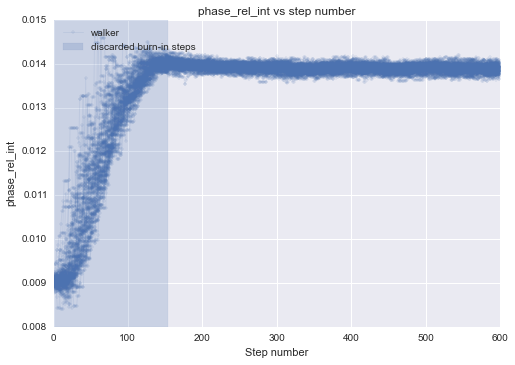

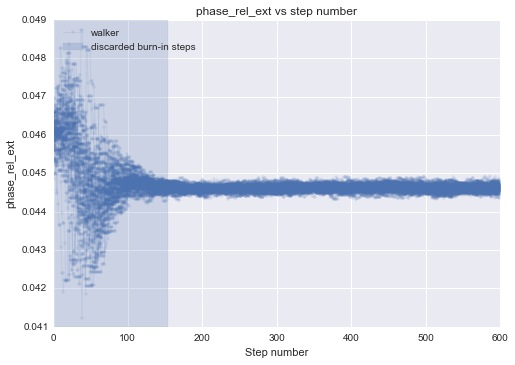

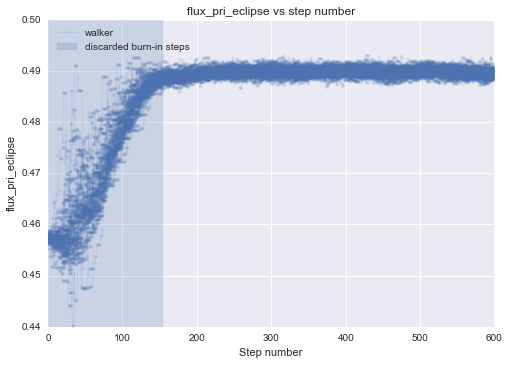

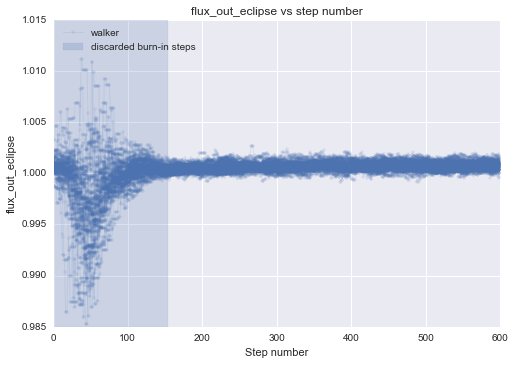

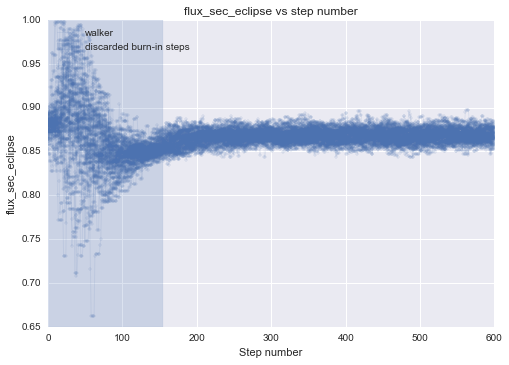

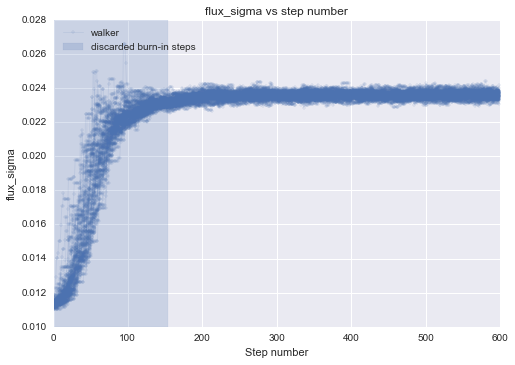

In [26]:
print("Initialize walkers from a small Gaussian ball around the initial parameters.")
# Adapted from http://dan.iel.fm/emcee/current/user/line/
# TODO: model uncertainties consistently between mcmc models.
models.seg.combined.inliers.mcmc = code.utils.Container()
models.seg.combined.inliers.mcmc.labels = \
    ('phase_rel_int', 'phase_rel_ext',
     'flux_pri_eclipse', 'flux_out_eclipse', 'flux_sec_eclipse', 'flux_sigma')
params_init = \
    (models.seg.combined.inliers.fit.events.loc[1, 'phase_dec'],
     models.seg.combined.inliers.fit.events.loc[2, 'phase_dec'],
     models.seg.combined.inliers.fit.events.loc[0, 'flux_rel'],
     models.seg.combined.inliers.fit.events.loc[2, 'flux_rel'],
     models.seg.combined.inliers.fit.events.loc[4, 'flux_rel'],
     dataframes.combined.inliers['flux_rel_err'].median())
ndims = len(params_init)
nwalkers = 10*ndims
nsteps = 10*nwalkers
# Variance of initial guesses is from previous runs.
pos0_vecs = \
    [np.add(params_init, np.multiply(params_init, (1e-2, 1e-2, 1e-3, 5e-4, 1e-2, 1e-2))*np.random.randn(ndims))
     for _ in xrange(nwalkers)]
models.seg.combined.inliers.mcmc.sampler = emcee.EnsembleSampler(
    nwalkers=nwalkers, dim=ndims, lnpostfn=code.utils.seg_log_posterior,
    kwargs=dict(phases=models.seg.combined.inliers.phases, fluxes_rel=models.seg.combined.inliers.fluxes))
models.seg.combined.inliers.mcmc.sampler.run_mcmc(pos0=pos0_vecs, N=nsteps)
# Discard 2*autocorrelation time as burn-in. Chosen from previous runs.
models.seg.combined.inliers.mcmc.nburn_idx = \
    2*int(np.ceil(np.max(models.seg.combined.inliers.mcmc.sampler.acor)))
# Collapse the chain along the axis of the walkers to visualize the parameter distributions.
# np.shape(trace) = ((nsteps-nburn_idx)*nwalkers, ndims)
models.seg.combined.inliers.mcmc.trace = np.reshape(
    models.seg.combined.inliers.mcmc.sampler.chain[:, models.seg.combined.inliers.mcmc.nburn_idx:, :],
    newshape=(-1, ndims))
print()
print("`models.seg`: Plot probability distribution of parameters.")
# For `triangle.corner`:
# `quantiles` are left-tailed p-values (z < `quantile`) at 1 standard devation.
# `levels` are confidence levels (|z| < `level`) at 1 standard deviation.
fig = triangle.corner(
    xs=models.seg.combined.inliers.mcmc.trace,
    labels=models.seg.combined.inliers.mcmc.labels,
    show_titles=True, title_fmt='.2E', scale_hist=False,
    quantiles=[0.1587, 0.5, 0.8413], verbose=False,
    plot_contours=False, plot_datapoints=True,
    data_kwargs={'alpha': 0.1, 'marker': ','})
plt.show(fig)
print()
print("`models.seg`: Plot the random walks for each variable.")
for prm_idx, label in enumerate(models.seg.combined.inliers.mcmc.labels):
    wkr_label = 'walker'
    for wkr_idx in xrange(len(models.seg.combined.inliers.mcmc.sampler.chain)):
        plt.plot(models.seg.combined.inliers.mcmc.sampler.chain[wkr_idx, :, prm_idx],
                 marker='.', linestyle='-', linewidth=1, alpha=0.1, label=wkr_label,
                 color=sns.color_palette()[0])
        wkr_label = None
    plt.axvspan(0, models.seg.combined.inliers.mcmc.nburn_idx,
                alpha=0.2, label='discarded burn-in steps',
                color=sns.color_palette()[0])
    plt.title("{label} vs step number".format(label=label))
    plt.xlabel("Step number")
    plt.ylabel(label)
    plt.legend(loc='upper left')
    plt.show()

`models.seg.combined.inliers.fit`: Save parameters from the Bayesian MCMC segmented, symmetric
light curve model and plot phased light curves for inlier data.
For phase variables, the variance is in the x direction.


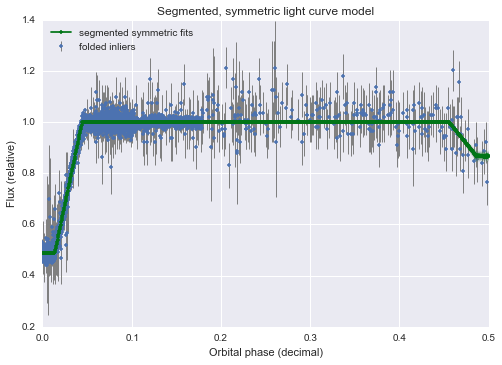


Model is only valid for the times fit:
from 2014-06-30T07:20:06.796Z to 2014-07-01T07:23:31.159Z


In [27]:
print("`models.seg.combined.inliers.fit`: Save parameters from the Bayesian MCMC segmented, symmetric\n" +
      "light curve model and plot phased light curves for inlier data.")
print("For phase variables, the variance is in the x direction.")
# Save the -1*sigma, median, and +1*sigma values for the parameters and events.
# Percentiles are left-tailed p values (z < `percentile`) at 1 standard devation.
for (prm_idx, label) in enumerate(models.seg.combined.inliers.mcmc.labels):
    map(lambda lbl, pct: \
        setattr(models.seg.combined.inliers.fit, lbl, pct),
        (label+'_lwr', label, label+'_upr'),
        np.percentile(models.seg.combined.inliers.mcmc.trace[:, prm_idx],
                      q=[15.87, 50.0, 84.13], axis=0))
# At every phase point, plot the median and standard deviation
# of the flux values from the many light curve models.
random_traces = \
    models.seg.combined.inliers.mcmc.trace[
        np.random.randint(
            len(models.seg.combined.inliers.mcmc.trace), size=1000)]
models.seg.combined.inliers.fit.phases = \
    np.linspace(start=0.0, stop=0.5, num=1001, endpoint=True)
fluxes_arr = \
    map(lambda prm: 
        code.utils.seg_model_fluxes_rel(
            params=prm, phases=models.seg.combined.inliers.fit.phases),
        random_traces)
(models.seg.combined.inliers.fit.fluxes_lwr,
 models.seg.combined.inliers.fit.fluxes,
 models.seg.combined.inliers.fit.fluxes_upr) = np.percentile(
    fluxes_arr, q=[15.87, 50.0, 84.13], axis=0)
plt.errorbar(
    models.seg.combined.inliers.phases,
    models.seg.combined.inliers.fluxes,
    models.seg.combined.inliers.fluxes_err,
    ecolor='gray', marker='.', linestyle='', linewidth=1,
    label='folded inliers', color=sns.color_palette()[0])
plt.plot(models.seg.combined.inliers.fit.phases,
         models.seg.combined.inliers.fit.fluxes,
         marker='.', linestyle='-', label='segmented symmetric fits',
         color=sns.color_palette(name='dark')[1])
plt.plot(models.seg.combined.inliers.fit.phases,
         models.seg.combined.inliers.fit.fluxes_lwr,
         marker='', linestyle='--', label=None,
         color=sns.color_palette(name='dark')[1])
plt.plot(models.seg.combined.inliers.fit.phases,
         models.seg.combined.inliers.fit.fluxes_upr,
         marker='', linestyle='--', label=None,
         color=sns.color_palette(name='dark')[1])
for fluxes in fluxes_arr:
    plt.plot(models.seg.combined.inliers.fit.phases,
             fluxes,
             marker='', linestyle='-', linewidth=1, alpha=0.01, label=None,
             color=sns.color_palette()[1])
plt.title("Segmented, symmetric light curve model")
plt.xlabel("Orbital phase (decimal)")
plt.ylabel("Flux (relative)")
plt.legend(loc='upper left')
plt.show()
print()
print(("Model is only valid for the times fit:\n"
       "from {ts_begin}Z to {ts_end}Z").format(
    ts_begin=astropy_time.Time(min(models.seg.combined.inliers.fit.ls.times), format='unix', scale='tcb').utc.isot,
    ts_end=astropy_time.Time(max(models.seg.combined.inliers.fit.ls.times), format='unix', scale='tcb').utc.isot))

`models.seg.combined.inliers`, `dataframes.combined.inliers`: Plot phased residuals
from segmented, symmetric light curve model.


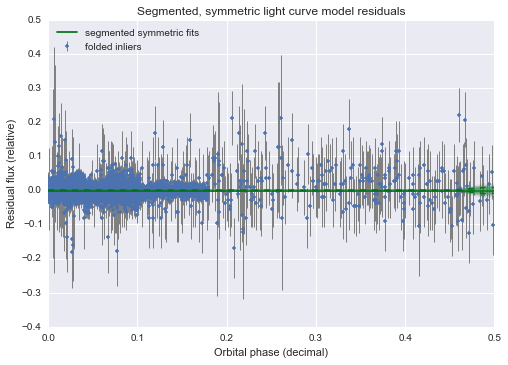

For a given phase observed between
2014-06-30T07:20:06.796 and 2014-07-01T07:23:31.159
these are the expected errors from the model.

`models.seg.combined.inliers`: Measure Gaussianity of residuals using rank-based statistics.

Departure from Gaussian core: number of sigma, Z1 = 3.25319188587
Departure from Gaussian tail: number of sigma, Z2 = 35.6321153728

Z1 > 2: The model may under-fit the inlier data, i.e. the model may have high bias.
Z2 > 2: There may still be outliers in the inlier data.


In [28]:
print("`models.seg.combined.inliers`, `dataframes.combined.inliers`: Plot phased residuals\n" +
      "from segmented, symmetric light curve model.")
(models.seg.combined.inliers.fluxes_res, models.seg.combined.inliers.fluxes_interp) = \
    code.utils.calc_residual_fluxes(
        phases=models.seg.combined.inliers.phases,
        fluxes=models.seg.combined.inliers.fluxes,
        fit_phases=models.seg.combined.inliers.fit.phases,
        fit_fluxes=models.seg.combined.inliers.fit.fluxes)
assert np.all(np.isclose(
        models.seg.combined.inliers.fluxes - models.seg.combined.inliers.fluxes_interp,
        models.seg.combined.inliers.fluxes_res))
dataframes.combined.inliers['flux_rel_res'] = models.seg.combined.inliers.fluxes_res
dataframes.combined.inliers['flux_rel_fit'] = models.seg.combined.inliers.fluxes_interp
plt.errorbar(
    models.seg.combined.inliers.phases,
    models.seg.combined.inliers.fluxes_res,
    models.seg.combined.inliers.fluxes_err,
    ecolor='gray', marker='.', linestyle='', linewidth=1,
    label='folded inliers', color=sns.color_palette()[0])
plt.plot(
    models.seg.combined.inliers.fit.phases,
    [np.median(models.seg.combined.inliers.fluxes_res)]*len(models.seg.combined.inliers.fit.phases),
    marker='', linestyle='-', label='segmented symmetric fits',
    color=sns.color_palette(name='dark')[1])
plt.plot(
    models.seg.combined.inliers.fit.phases,
    models.seg.combined.inliers.fit.fluxes_upr - models.seg.combined.inliers.fit.fluxes,
    marker='', linestyle='--', label=None,
    color=sns.color_palette(name='dark')[1])
plt.plot(
    models.seg.combined.inliers.fit.phases,
    models.seg.combined.inliers.fit.fluxes_lwr - models.seg.combined.inliers.fit.fluxes,
    marker='', linestyle='--', label=None,
    color=sns.color_palette(name='dark')[1])
for fluxes in fluxes_arr:
    plt.plot(
        models.seg.combined.inliers.fit.phases,
        fluxes - models.seg.combined.inliers.fit.fluxes,
        marker='', linestyle='-', linewidth=1, alpha=0.01,
        label=None, color=sns.color_palette()[1])
plt.title("Segmented, symmetric light curve model residuals")
plt.xlabel("Orbital phase (decimal)")
plt.ylabel("Residual flux (relative)")
plt.legend(loc='upper left')
plt.show()
print(("For a given phase observed between\n" +
       "{ts_begin} and {ts_end}\n" +
       "these are the expected errors from the model.").format(
        ts_begin=astropy_time.Time(min(models.seg.combined.inliers.fit.ls.times), format='unix', scale='tcb').utc.isot,
        ts_end=astropy_time.Time(max(models.seg.combined.inliers.fit.ls.times), format='unix', scale='tcb').utc.isot))
# TODO: plot expected errors as a function of time over years.
print()
print("`models.seg.combined.inliers`: Measure Gaussianity of residuals using rank-based statistics.")
(models.seg.combined.inliers.z1, models.seg.combined.inliers.z2) = \
    code.utils.calc_z1_z2(dist=models.seg.combined.inliers.fluxes_res)
print()
print(("Departure from Gaussian core: number of sigma, Z1 = {z1}\n" +
       "Departure from Gaussian tail: number of sigma, Z2 = {z2}").format(
        z1=models.seg.combined.inliers.z1, z2=models.seg.combined.inliers.z2))
print()
if models.seg.combined.inliers.z1 > 2.0:
    print("Z1 > 2: The model may under-fit the inlier data, i.e. the model may have high bias.")
else:
    print("Z1 <= 2: The model does not appear to under-fit the inlier data.")
if models.seg.combined.inliers.z2 > 2.0:
    print("Z2 > 2: There may still be outliers in the inlier data.")
else:
    print("Z2 <= 2: There do not appear to be any remaining outliers in the inlier data.")

### Again identify outliers

TODO: redo outlier rejection following section 3 of Hogg et al 2010, http://arxiv.org/pdf/1008.4686v1.pdf

Related structures for this section:
```
dataframes.
    combined.
        inliers
        inliers2
models.
    seg.
        combined.
            inliers.
                phases, fluxes_res, fluxes_err
                res.
                    model, fit, outlier_test, is_inlier2
                
                fit.
                    phases, is_inlier2
            inliers2.
                z1, z2
```

`models.seg.combined.inliers`, `dataframes.combined.inliers_inliers`: Remove outliers from the residuals using
Bonferroni-corrected p-values.
Fit a constant to the residuals.
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                      -inf
Date:                Thu, 16 Jul 2015   Prob (F-statistic):                nan
Time:                        09:51:08   Log-Likelihood:                 13938.
No. Observations:                5986   AIC:                        -2.787e+04
Df Residuals:                    5985   BIC:                        -2.787e+04
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err   

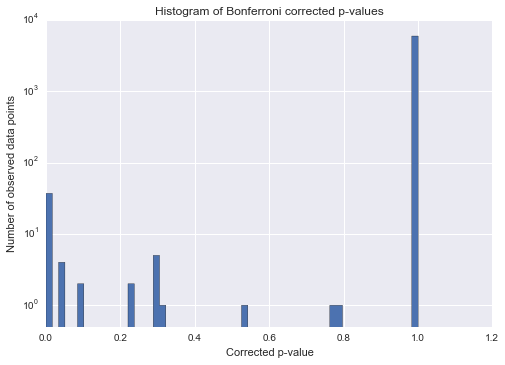

Number of outliers detected: 56


In [29]:
print("`models.seg.combined.inliers`, `dataframes.combined.inliers_inliers`: Remove outliers from the residuals using\n" +
      "Bonferroni-corrected p-values.")
models.seg.combined.inliers.res = code.utils.Container()
models.seg.combined.inliers.res.model = \
    sm.OLS(endog=models.seg.combined.inliers.fluxes_res,
           exog=np.ones(len(dataframes.combined.inliers)))
models.seg.combined.inliers.res.fit = models.seg.combined.inliers.res.model.fit()
print("Fit a constant to the residuals.")
print(models.seg.combined.inliers.res.fit.summary())
models.seg.combined.inliers.res.outlier_test = models.seg.combined.inliers.res.fit.outlier_test()
astroML_plt.hist(models.seg.combined.inliers.res.fit.outlier_test()[:, 2],
                 bins='scott', histtype='stepfilled')
plt.title("Histogram of Bonferroni corrected p-values")
plt.xlabel("Corrected p-value")
plt.ylabel("Number of observed data points")
plt.yscale('log')
plt.ylim(0.5, None)
plt.show()
models.seg.combined.inliers.res.is_inlier2 = \
    np.isclose(models.seg.combined.inliers.res.fit.outlier_test()[:, 2], 1.0)
dataframes.combined.inliers['is_inlier2'] = models.seg.combined.inliers.res.is_inlier2
print(("Number of outliers detected: {num}").format(
        num=len(dataframes.combined.inliers.loc[
                np.logical_not(dataframes.combined.inliers['is_inlier2'])])))
# Create a new dataframe for inliers. Create a copy to prevent altering the original.
dataframes.combined.inliers2 = dataframes.combined.inliers.loc[
    dataframes.combined.inliers['is_inlier2']].copy()

`dataframes.combined.inliers`, `dataframes.combined.inliers2`:
Plot phased residuals from Lomb-Scargle light curve model with
identified outliers.


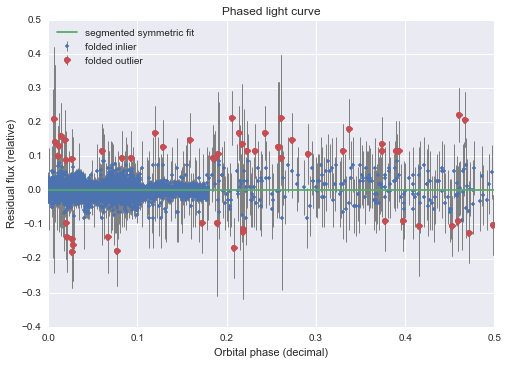

Measure Gaussianity of inlier residuals using rank-based statistics.

Departure from Gaussian core: number of sigma, Z1 = 3.25319188587
Departure from Gaussian tail: number of sigma, Z2 = 35.6321153728

Z1 > 2: The model may under-fit the inlier data, i.e. the model may have high bias.
Z2 > 2: There may still be outliers in the inlier data.


In [30]:
print("`dataframes.combined.inliers`, `dataframes.combined.inliers2`:\n" +
      "Plot phased residuals from Lomb-Scargle light curve model with\n" +
      "identified outliers.")
plt.errorbar(
    models.seg.combined.inliers.phases,
    models.seg.combined.inliers.fluxes_res,
    models.seg.combined.inliers.fluxes_err,
    ecolor='gray', marker='.', linestyle='', linewidth=1,
    label='folded inlier', color=sns.color_palette()[0])
plt.plot(
    models.seg.combined.inliers.fit.phases,
    [0]*len(models.seg.combined.inliers.fit.phases),
    marker='', linestyle='-', label='segmented symmetric fit',
    color=sns.color_palette()[1])
tfmask_outliers2 = np.logical_not(models.seg.combined.inliers.res.is_inlier2)
plt.errorbar(
    models.seg.combined.inliers.phases[tfmask_outliers2],
    models.seg.combined.inliers.fluxes_res[tfmask_outliers2],
    models.seg.combined.inliers.fluxes_err[tfmask_outliers2],
    ecolor='gray', marker='o', linestyle='', linewidth=1,
    label='folded outlier', color=sns.color_palette()[2])
plt.title('Phased light curve')
plt.xlabel('Orbital phase (decimal)')
plt.ylabel('Residual flux (relative)')
plt.legend(loc='upper left')
plt.show()
print("Measure Gaussianity of inlier residuals using rank-based statistics.")
models.seg.combined.inliers2 = code.utils.Container()
(models.seg.combined.inliers2.z1, models.seg.combined.inliers2.z2) = \
    code.utils.calc_z1_z2(dist=dataframes.combined.inliers['flux_rel_res'])
print()
print(("Departure from Gaussian core: number of sigma, Z1 = {z1}\n" +
       "Departure from Gaussian tail: number of sigma, Z2 = {z2}").format(
        z1=models.seg.combined.inliers2.z1, z2=models.seg.combined.inliers2.z2))
print()
if models.seg.combined.inliers2.z1 > 2.0:
    print("Z1 > 2: The model may under-fit the inlier data, i.e. the model may have high bias.")
else:
    print("Z1 <= 2: The model does not appear to under-fit the inlier data.")
if models.seg.combined.inliers2.z2 > 2.0:
    print("Z2 > 2: There may still be outliers in the inlier data.")
else:
    print("Z2 <= 2: There do not appear to be any remaining outliers in the inlier data.")

### Model inliers only

To calculate the best period, model only the inlier data, calculate the best number of terms, and sample the probability space using Bayesian MCMC.

```
dataframes.
    combined.
        inliers
        inliers2
models.
    seg.
        combined.
            inliers.
                phases, fluxes_res, fluxes_err
                res.
                    model, fit, outlier_test, is_inlier2
                
                fit.
                    phases, is_inlier2
                    ls.
                        times
            inliers2.
                phases, fluxes, fluxes_res, flxues_interp
                fit.
                    phases
                    fluxes, *_lwr, *_upr
                    phase_rel_int, *_lwr, *_upr
                    phase_rel_ext, *_lwr, *_upr
                    flux_pri_eclipse, *_lwr, *_upr
                    flux_out_eclipse, *_lwr, *_upr
                    flux_sec_eclipse, *_lwr, *_upr
                    flux_sigma, *_lwr, *_upr
                    ls.
                        times
                z1, z2
```

`models.seg.combined.inliers2`: Initialize walkers from the previous trace.

`models.seg.combined.inliers2`: Plot probability distribution of parameters.


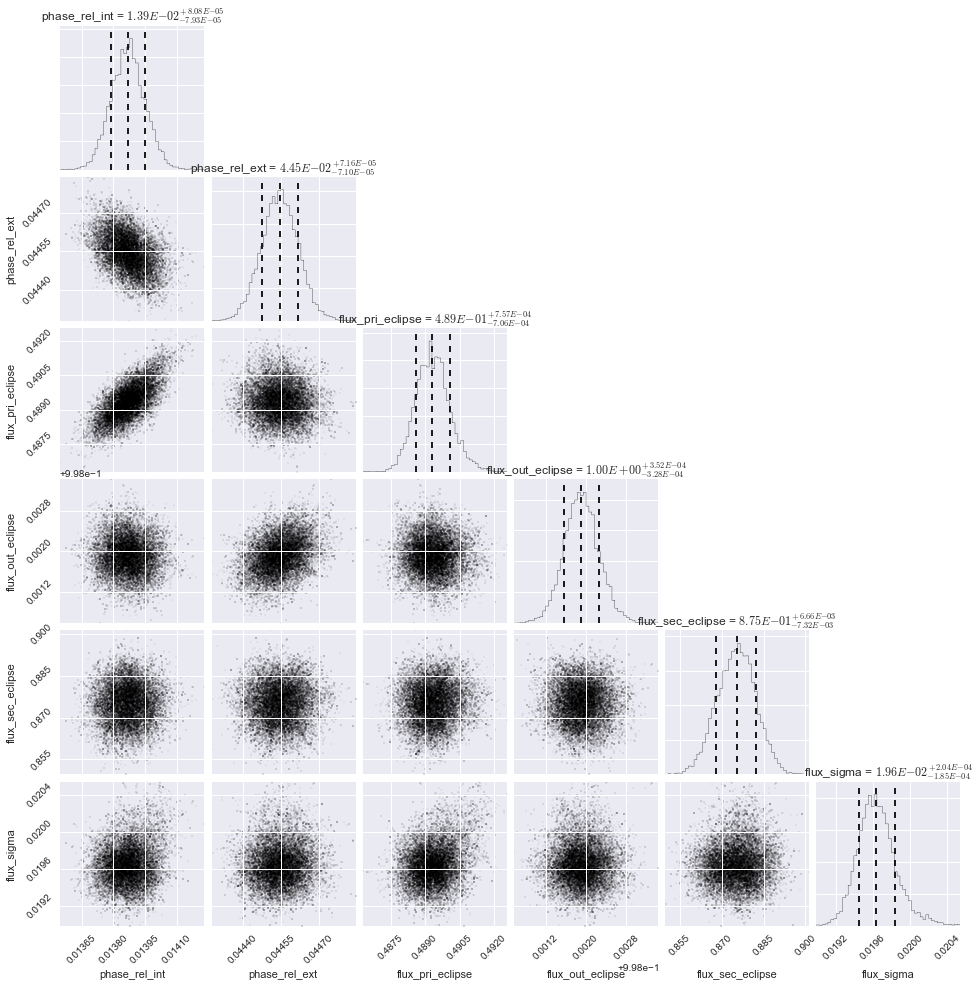


`models.seg.combined.inliers2`: Plot the random walks for each variable.


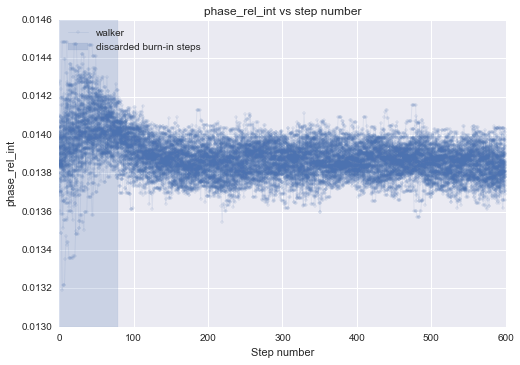

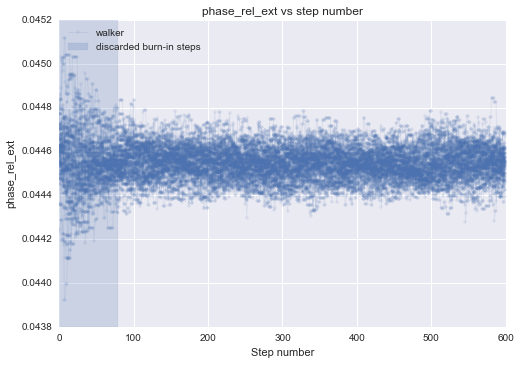

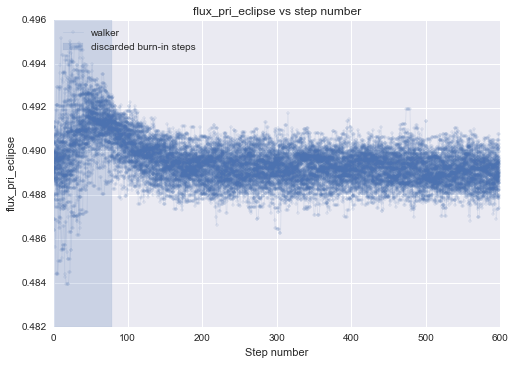

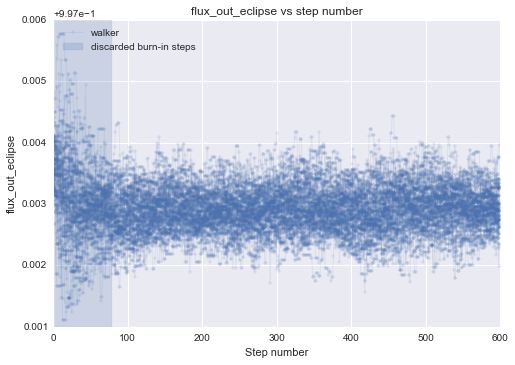

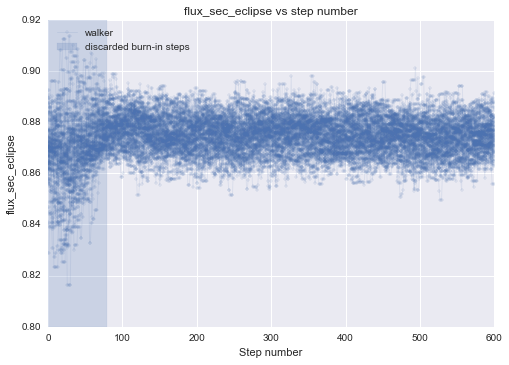

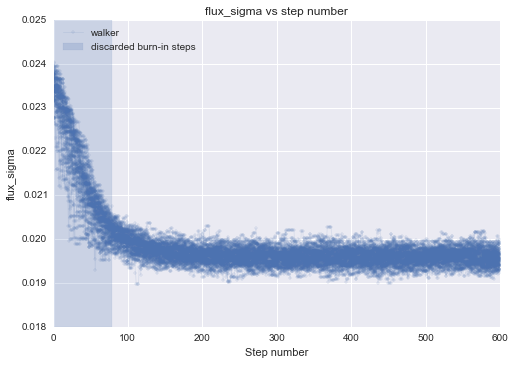

In [31]:
print("`models.seg.combined.inliers2`: Initialize walkers from the previous trace.")
# Adapted from http://dan.iel.fm/emcee/current/user/line/
# TODO: model uncertainties consistently between mcmc models.
tfmask_lt05 = dataframes.combined.inliers2['phase_dec'].values < 0.5
models.seg.combined.inliers2.phases = np.where(
    tfmask_lt05,
    dataframes.combined.inliers2['phase_dec'].values,
    1.0 - dataframes.combined.inliers2['phase_dec'])
models.seg.combined.inliers2.fluxes = dataframes.combined.inliers2['flux_rel'].values
models.seg.combined.inliers2.fluxes_err = dataframes.combined.inliers2['flux_rel_err'].values
models.seg.combined.inliers2.mcmc = code.utils.Container()
models.seg.combined.inliers2.mcmc.labels = models.seg.combined.inliers.mcmc.labels
ndims = len(models.seg.combined.inliers2.mcmc.labels)
nwalkers = 10*ndims
nsteps = 10*nwalkers
rand_idxs_trace_seg = np.random.choice(
    len(models.seg.combined.inliers.mcmc.trace), size=nwalkers)
pos0_vecs = models.seg.combined.inliers.mcmc.trace[rand_idxs_trace_seg]    
models.seg.combined.inliers2.mcmc.sampler = emcee.EnsembleSampler(
    nwalkers=nwalkers, dim=ndims, lnpostfn=code.utils.seg_log_posterior,
    kwargs=dict(phases=models.seg.combined.inliers2.phases, fluxes_rel=models.seg.combined.inliers2.fluxes))
models.seg.combined.inliers2.mcmc.sampler.run_mcmc(pos0=pos0_vecs, N=nsteps)
# Discard 1*autocorrelation time as burn-in.
models.seg.combined.inliers2.mcmc.nburn_idx = \
    int(np.ceil(np.max(models.seg.combined.inliers2.mcmc.sampler.acor)))
# Collapse the chain along the axis of the walkers to visualize the parameter distributions.
# np.shape(trace) = ((nsteps-nburn_idx)*nwalkers, ndims)
models.seg.combined.inliers2.mcmc.trace = np.reshape(
    models.seg.combined.inliers2.mcmc.sampler.chain[:, models.seg.combined.inliers2.mcmc.nburn_idx:, :],
    newshape=(-1, ndims))
print()
print("`models.seg.combined.inliers2`: Plot probability distribution of parameters.")
# For `triangle.corner`:
# `quantiles` are left-tailed p-values (z < `quantile`) at 1 standard devation.
# `levels` are confidence levels (|z| < `level`) at 1 standard deviation.
fig = triangle.corner(
    xs=models.seg.combined.inliers2.mcmc.trace,
    labels=models.seg.combined.inliers2.mcmc.labels,
    show_titles=True, title_fmt='.2E', scale_hist=False,
    quantiles=[0.1587, 0.5, 0.8413], verbose=False,
    plot_contours=False, plot_datapoints=True,
    data_kwargs={'alpha': 0.1, 'marker': ','})
plt.show(fig)
print()
print("`models.seg.combined.inliers2`: Plot the random walks for each variable.")
for prm_idx, label in enumerate(models.seg.combined.inliers2.mcmc.labels):
    wkr_label = 'walker'
    for wkr_idx in xrange(len(models.seg.combined.inliers2.mcmc.sampler.chain)):
        plt.plot(models.seg.combined.inliers2.mcmc.sampler.chain[wkr_idx, :, prm_idx],
                 marker='.', linestyle='-', linewidth=1, alpha=0.1, label=wkr_label,
                 color=sns.color_palette()[0])
        wkr_label = None
    plt.axvspan(0, models.seg.combined.inliers2.mcmc.nburn_idx,
                alpha=0.2, label='discarded burn-in steps',
                color=sns.color_palette()[0])
    plt.title("{label} vs step number".format(label=label))
    plt.xlabel("Step number")
    plt.ylabel(label)
    plt.legend(loc='upper left')
    plt.show()

`models.seg.combined.inliers2.fit`: Save parameters from the Bayesian MCMC segmented, symmetric
light curve model and plot phased light curves for inlier data.
For phase variables, the variance is in the x direction.


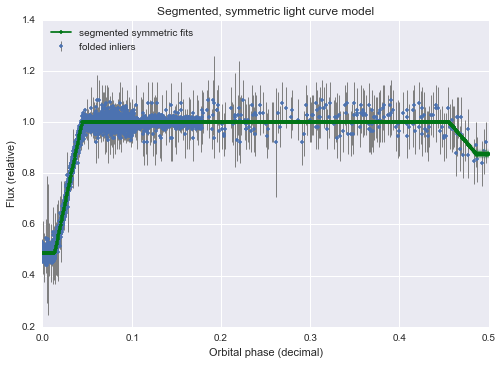


Model is only valid for the times fit:
from 2014-06-30T07:20:06.796Z to 2014-07-01T07:23:31.159Z


In [32]:
print("`models.seg.combined.inliers2.fit`: Save parameters from the Bayesian MCMC segmented, symmetric\n" +
      "light curve model and plot phased light curves for inlier data.")
print("For phase variables, the variance is in the x direction.")
# Save the -1*sigma, median, and +1*sigma values for the parameters and events.
# Percentiles are left-tailed p values (z < `percentile`) at 1 standard devation.
models.seg.combined.inliers2.fit = code.utils.Container()
for (prm_idx, label) in enumerate(models.seg.combined.inliers2.mcmc.labels):
    map(lambda lbl, pct: \
        setattr(models.seg.combined.inliers2.fit, lbl, pct),
        (label+'_lwr', label, label+'_upr'),
        np.percentile(models.seg.combined.inliers2.mcmc.trace[:, prm_idx],
                      q=[15.87, 50.0, 84.13], axis=0))
# Include the Lomb-Scargle fit for comparison.
# NOTE: The Lomb-Scargle fit for the combined data is only fit to the phase, not the flux.
models.seg.combined.inliers2.fit.ls = code.utils.Container()
models.seg.combined.inliers2.fit.ls.times = models.ls.combined.inliers.fit.times
tfmask_ls_lt05 = models.ls.combined.inliers.fit.phases < 0.5
models.seg.combined.inliers2.fit.ls.phases = np.where(
    tfmask_ls_lt05,
    models.ls.combined.inliers.fit.phases,
    1.0 - models.ls.combined.inliers.fit.phases)
models.seg.combined.inliers2.fit.ls.fluxes = models.ls.combined.inliers.fit.fluxes
# At every phase point, plot the median and standard deviation
# of the flux values from the many light curve models.
random_traces = \
    models.seg.combined.inliers2.mcmc.trace[
        np.random.randint(
            len(models.seg.combined.inliers2.mcmc.trace), size=1000)]
models.seg.combined.inliers2.fit.phases = \
    np.linspace(start=0.0, stop=0.5, num=1001, endpoint=True)
fluxes_arr = \
    map(lambda prm: 
        code.utils.seg_model_fluxes_rel(
            params=prm, phases=models.seg.combined.inliers2.fit.phases),
        random_traces)
(models.seg.combined.inliers2.fit.fluxes_lwr,
 models.seg.combined.inliers2.fit.fluxes,
 models.seg.combined.inliers2.fit.fluxes_upr) = \
    np.percentile(fluxes_arr,
                  q=[15.87, 50.0, 84.13], axis=0)
plt.errorbar(
    models.seg.combined.inliers2.phases,
    models.seg.combined.inliers2.fluxes,
    models.seg.combined.inliers2.fluxes_err,
    ecolor='gray', marker='.', linestyle='', linewidth=1,
    label='folded inliers', color=sns.color_palette()[0])
plt.plot(models.seg.combined.inliers2.fit.phases,
         models.seg.combined.inliers2.fit.fluxes,
         marker='.', linestyle='-', label='segmented symmetric fits',
         color=sns.color_palette(name='dark')[1])
plt.plot(models.seg.combined.inliers2.fit.phases,
         models.seg.combined.inliers2.fit.fluxes_lwr,
         marker='', linestyle='--', label=None,
         color=sns.color_palette(name='dark')[1])
plt.plot(models.seg.combined.inliers2.fit.phases,
         models.seg.combined.inliers2.fit.fluxes_upr,
         marker='', linestyle='--', label=None,
         color=sns.color_palette(name='dark')[1])
for fluxes in fluxes_arr:
    plt.plot(models.seg.combined.inliers2.fit.phases,
             fluxes,
             marker='', linestyle='-', linewidth=1, alpha=0.01, label=None,
             color=sns.color_palette()[1])
plt.title("Segmented, symmetric light curve model")
plt.xlabel("Orbital phase (decimal)")
plt.ylabel("Flux (relative)")
plt.legend(loc='upper left')
plt.show()
print()
print(("Model is only valid for the times fit:\n"
       "from {ts_begin}Z to {ts_end}Z").format(
    ts_begin=astropy_time.Time(min(models.seg.combined.inliers2.fit.ls.times), format='unix', scale='tcb').utc.isot,
    ts_end=astropy_time.Time(max(models.seg.combined.inliers2.fit.ls.times), format='unix', scale='tcb').utc.isot))

`models.seg.combined.inliers2`, `dataframes.combined.inliers2`: Plot phased residuals
from segmented, symmetric light curve model.


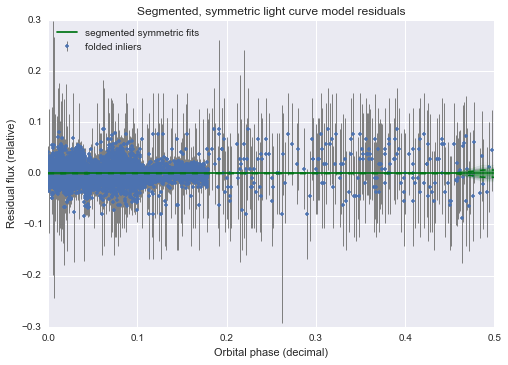

For a given phase observed between
2014-06-30T07:20:06.796 and 2014-07-01T07:23:31.159
these are the expected errors from the model.

`models.seg.combined.inliers2`: Measure Gaussianity of residuals using rank-based statistics.

Departure from Gaussian core: number of sigma, Z1 = 0.883045909639
Departure from Gaussian tail: number of sigma, Z2 = 15.9149227936

Z1 <= 2: The model does not appear to under-fit the inlier data.
Z2 > 2: There may still be outliers in the inlier data.


In [33]:
print("`models.seg.combined.inliers2`, `dataframes.combined.inliers2`: Plot phased residuals\n" +
      "from segmented, symmetric light curve model.")
(models.seg.combined.inliers2.fluxes_res, models.seg.combined.inliers2.fluxes_interp) = \
    code.utils.calc_residual_fluxes(
        phases=models.seg.combined.inliers2.phases,
        fluxes=models.seg.combined.inliers2.fluxes,
        fit_phases=models.seg.combined.inliers2.fit.phases,
        fit_fluxes=models.seg.combined.inliers2.fit.fluxes)
assert np.all(np.isclose(
        models.seg.combined.inliers2.fluxes - models.seg.combined.inliers2.fluxes_interp,
        models.seg.combined.inliers2.fluxes_res))
dataframes.combined.inliers2['flux_rel_res'] = models.seg.combined.inliers2.fluxes_res
dataframes.combined.inliers2['flux_rel_fit'] = models.seg.combined.inliers2.fluxes_interp
plt.errorbar(
    models.seg.combined.inliers2.phases,
    models.seg.combined.inliers2.fluxes_res,
    models.seg.combined.inliers2.fluxes_err,
    ecolor='gray', marker='.', linestyle='', linewidth=1,
    label='folded inliers', color=sns.color_palette()[0])
plt.plot(
    models.seg.combined.inliers2.fit.phases,
    [np.median(models.seg.combined.inliers2.fluxes_res)]*len(models.seg.combined.inliers2.fit.phases),
    marker='', linestyle='-', label='segmented symmetric fits',
    color=sns.color_palette(name='dark')[1])
plt.plot(
    models.seg.combined.inliers2.fit.phases,
    models.seg.combined.inliers2.fit.fluxes_upr - models.seg.combined.inliers2.fit.fluxes,
    marker='', linestyle='--', label=None,
    color=sns.color_palette(name='dark')[1])
plt.plot(
    models.seg.combined.inliers2.fit.phases,
    models.seg.combined.inliers2.fit.fluxes_lwr - models.seg.combined.inliers2.fit.fluxes,
    marker='', linestyle='--', label=None,
    color=sns.color_palette(name='dark')[1])
for fluxes in fluxes_arr:
    plt.plot(
        models.seg.combined.inliers2.fit.phases,
        fluxes - models.seg.combined.inliers2.fit.fluxes,
        marker='', linestyle='-', linewidth=1, alpha=0.01,
        label=None, color=sns.color_palette()[1])
plt.title("Segmented, symmetric light curve model residuals")
plt.xlabel("Orbital phase (decimal)")
plt.ylabel("Residual flux (relative)")
plt.legend(loc='upper left')
plt.show()
print(("For a given phase observed between\n" +
       "{ts_begin} and {ts_end}\n" +
       "these are the expected errors from the model.").format(
        ts_begin=astropy_time.Time(min(models.seg.combined.inliers2.fit.ls.times), format='unix', scale='tcb').utc.isot,
        ts_end=astropy_time.Time(max(models.seg.combined.inliers2.fit.ls.times), format='unix', scale='tcb').utc.isot))
# TODO: plot expected errors as a function of time over years.
print()
print("`models.seg.combined.inliers2`: Measure Gaussianity of residuals using rank-based statistics.")
(models.seg.combined.inliers2.z1, models.seg.combined.inliers2.z2) = \
    code.utils.calc_z1_z2(dist=models.seg.combined.inliers2.fluxes_res)
print()
print(("Departure from Gaussian core: number of sigma, Z1 = {z1}\n" +
       "Departure from Gaussian tail: number of sigma, Z2 = {z2}").format(
        z1=models.seg.combined.inliers2.z1, z2=models.seg.combined.inliers2.z2))
print()
if models.seg.combined.inliers2.z1 > 2.0:
    print("Z1 > 2: The model may under-fit the inlier data, i.e. the model may have high bias.")
else:
    print("Z1 <= 2: The model does not appear to under-fit the inlier data.")
if models.seg.combined.inliers2.z2 > 2.0:
    print("Z2 > 2: There may still be outliers in the inlier data.")
else:
    print("Z2 <= 2: There do not appear to be any remaining outliers in the inlier data.")

## Chain MCMCs for Lomb-Scargel model of period and segmented, symmetric model of eclipse event phases and flux levels.

TODO: Restructure log posterior function for best_period so that it can accommodate all parameters instead of chaining the models.

Related structures for section:
```
dataframes.
    combined.
        inliers2
models.
    ls.
        combined.
            inliers.
                mcmc.
                    labels, trace
                model, filts
    seg.
        combined.
            inliers2.
                mcmc.
                    labels, nburn_idx, trace
                times
    chained.
        combined.
            inliers2.
                times, phases, fluxes, fluxes_err
                ls.
                    model, phases, times, fluxes
                    fluxes_err, fluxes_res, fluxes_interp
                mcmc.
                    labels, nburn_idx, trace
                seg.
                    phases, times, fluxes
                    fluxes_err, fluxes_res, fluxes_interp
                fit.
                    best_period, *_lwr, *_upr
                    phase_rel_int, *_lwr, *_upr
                    phase_rel_ext, *_lwr, *_upr
                    flux_pri_eclipse, *_lwr, *_upr
                    flux_out_eclipse, *_lwr, *_upr
                    flux_sec_eclipse, *_lwr, *_upr
                    flux_sigma, *_lwr, *_upr
                    min_flux_time, times, phases, filts
                    ls.
                        times, filts, phases
                        fluxes, *_lwr, *_upr
                        fluxes_err, z1, z2
                    seg.
                        times, phases,
                        fluxes, *_lwr, *_upr
                        fluxes_err, z1, z2
```

`models.chained.combined.inliers2.mcmc`: Compute segmented model MCMCs for each sampled best_period.
For every sampled period from the Lomb-Scargle MCMC, only the sampled parameters from the last step
of the segmented model MCMC are kept.

Plot marginal distributions of parameters against each other.


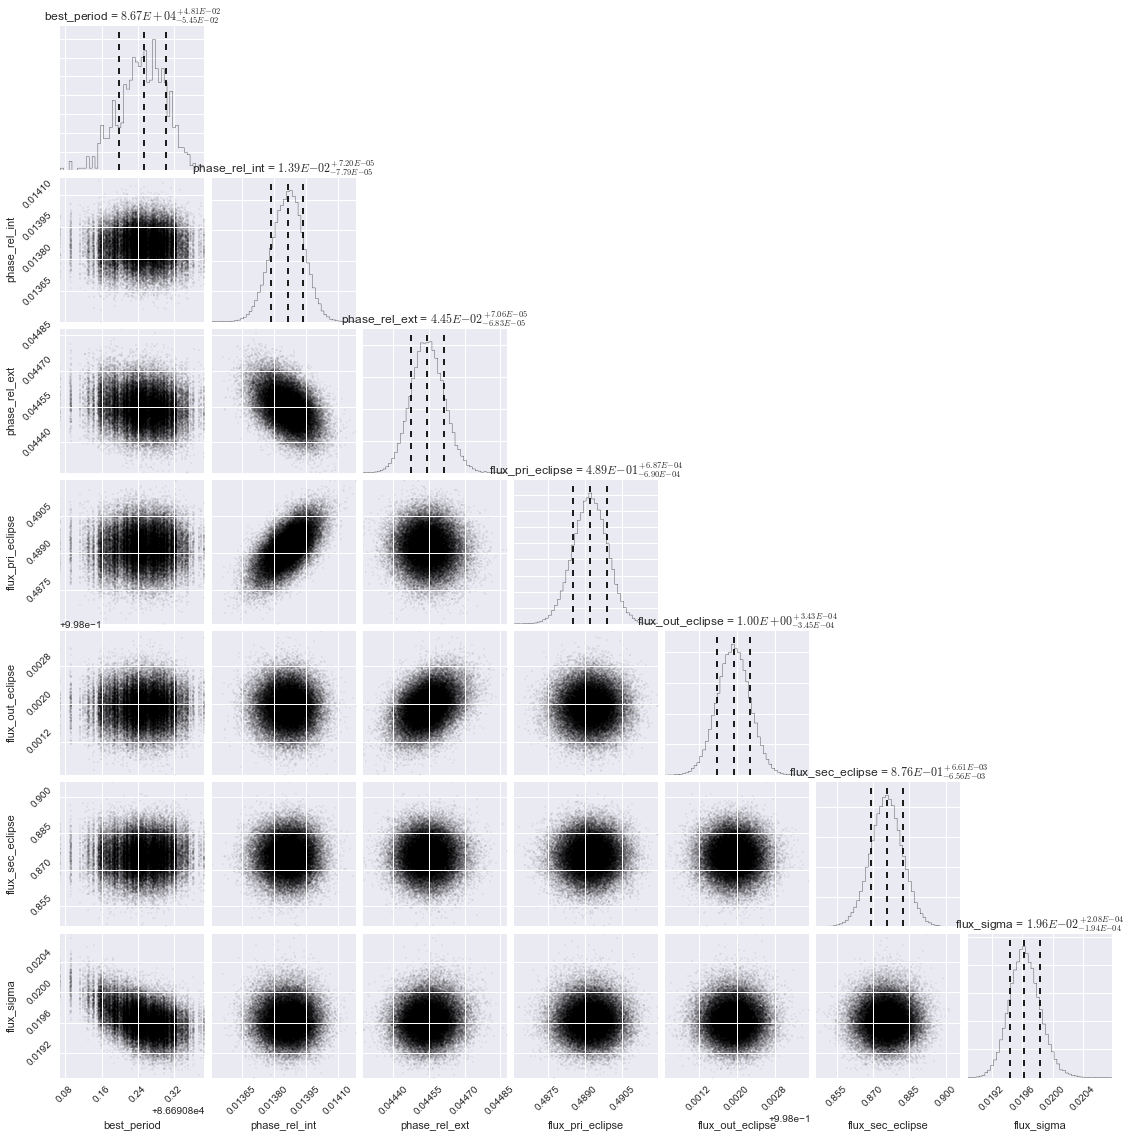


Plot the chain of the last sampler.
NOTE: Only the walkers from the last step are kept as part of the trace.
best_period = [ 86691.06003962]


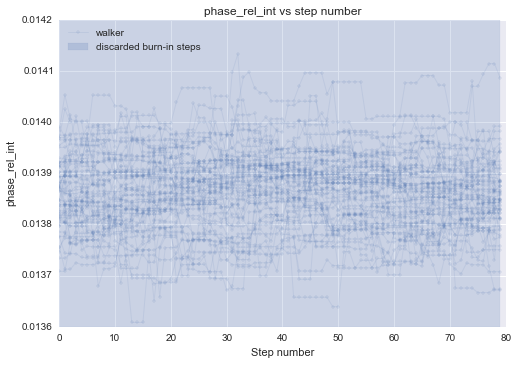

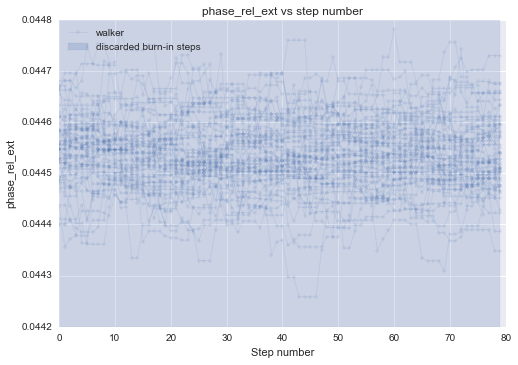

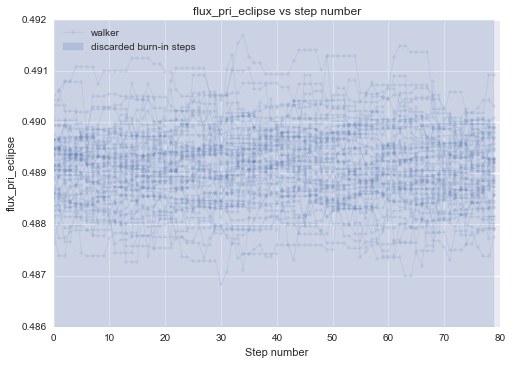

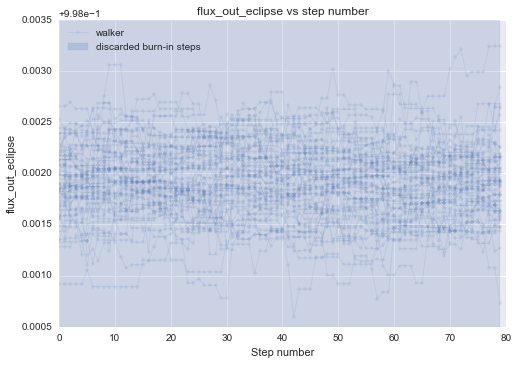

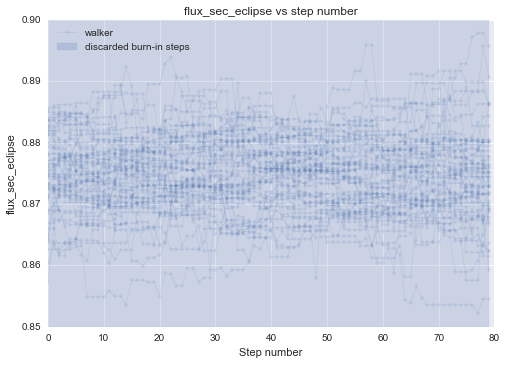

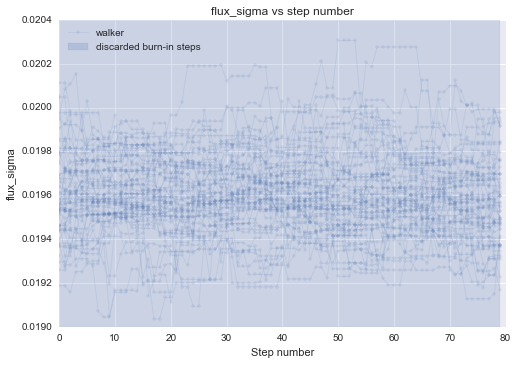

In [34]:
print("`models.chained.combined.inliers2.mcmc`: Compute segmented model MCMCs for each sampled best_period.\n" +
      "For every sampled period from the Lomb-Scargle MCMC, only the sampled parameters from the last step\n" +
      "of the segmented model MCMC are kept.")
# TODO: speed up with numba
# NOTE: This cell takes ~200 seconds to execute for 1000 samples of best_period.
num_best_periods = int(1e3)
# NOTE: Don't filter for unique values or enforce random choice without replacement
# since that alters the input distribution.
rand_idxs_trace_ls = np.random.choice(
    len(models.ls.combined.inliers.mcmc.trace), size=num_best_periods)
models.chained = code.utils.Container()
models.chained.combined = code.utils.Container()
models.chained.combined.inliers2 = code.utils.Container()
models.chained.combined.inliers2.times = dataframes.combined.inliers2['unixtime_TCB'].values
models.chained.combined.inliers2.fluxes = dataframes.combined.inliers2['flux_rel'].values
models.chained.combined.inliers2.fluxes_err = dataframes.combined.inliers2['flux_rel_err'].values
models.chained.combined.inliers2.ls = code.utils.Container()
models.chained.combined.inliers2.ls.model = copy.deepcopy(models.ls.combined.inliers.model)
models.chained.combined.inliers2.ls.filts = models.ls.combined.inliers.filts
models.chained.combined.inliers2.ls.fluxes = models.chained.combined.inliers2.fluxes
models.chained.combined.inliers2.ls.fluxes_err = models.chained.combined.inliers2.fluxes_err
models.chained.combined.inliers2.mcmc = code.utils.Container()
models.chained.combined.inliers2.mcmc.labels = tuple(np.append(
    models.ls.combined.inliers.mcmc.labels, models.seg.combined.inliers2.mcmc.labels))
# Discard 1*autocorrelation time as burn-in using the autocorrelation time
# from the segemented model MCMC for the maximum likelihood best_period.
nburn_idx = models.seg.combined.inliers2.mcmc.nburn_idx
models.chained.combined.inliers2.mcmc.nburn_idx = nburn_idx
models.chained.combined.inliers2.mcmc.trace = list()
# Autocorrelation times for the sequence of segmented model MCMC is about the same as the
# autocorrelation time for the segmented model MCMC from the maximimum likelihood best_period.
ndims = len(models.chained.combined.inliers2.mcmc.labels[1:])
nwalkers = 10*ndims
nsteps = models.chained.combined.inliers2.mcmc.nburn_idx + 1
for best_period in models.ls.combined.inliers.mcmc.trace[rand_idxs_trace_ls]:
    min_flux_time = code.utils.calc_min_flux_time(
        model=models.chained.combined.inliers2.ls.model,
        filt=models.chained.combined.inliers2.ls.filts[0],
        best_period=best_period,
        tol=0.1, maxiter=10)
    phases_ls = code.utils.calc_phases(
        times=models.chained.combined.inliers2.times,
        best_period=best_period,
        min_flux_time=min_flux_time)
    tfmask_lt05 = phases_ls < 0.5
    phases_seg = np.where(tfmask_lt05, phases_ls, 1.0 - phases_ls)
    # Re-initialize the walkers from the segmented model MCMC's parameter distribution
    # for the maximum likelihood best_period.
    rand_idxs_trace_seg = np.random.choice(
        len(models.seg.combined.inliers2.mcmc.trace), size=nwalkers)
    pos0_vecs = models.seg.combined.inliers2.mcmc.trace[rand_idxs_trace_seg]
    sampler = emcee.EnsembleSampler(
        nwalkers=nwalkers, dim=ndims, lnpostfn=code.utils.seg_log_posterior,
        kwargs=dict(phases=phases_seg, fluxes_rel=models.chained.combined.inliers2.fluxes))
    sampler.run_mcmc(pos0=pos0_vecs, N=nsteps)
    # NOTE: Don't save the samplers since saving 1000 samplers is ~150 MB memory.
    # Collapse the chain along the axis of the walkers to visualize the parameter distributions.
    # np.shape(trace) = ((nsteps-nburn_idx)*nwalkers, ndims)
    trace_seg = np.reshape(sampler.chain[:, nburn_idx:, :], newshape=(-1, ndims))
    [models.chained.combined.inliers2.mcmc.trace.append(combined) for combined in
     [np.append([best_period], segs) for segs in trace_seg]]
# At end, convert trace to numpy.ndarray
models.chained.combined.inliers2.mcmc.trace = np.asarray(models.chained.combined.inliers2.mcmc.trace)
print()
print("Plot marginal distributions of parameters against each other.")
# For `triangle.corner`:
# `quantiles` are left-tailed p-values (z < `quantile`) at 1 standard devation for histograms.
# `levels` are confidence levels (|z| < `level`) at 1 standard deviation for contour plots.
# NOTE: `levels` are ignored when plot_contours = True and when used with seaborn.
# Contours also override seaborn's grid.
fig = triangle.corner(
    xs=models.chained.combined.inliers2.mcmc.trace,
    labels=models.chained.combined.inliers2.mcmc.labels,
    show_titles=True, title_fmt='.2E', scale_hist=False,
    quantiles=[0.1587, 0.5, 0.8413], verbose=False,
    plot_contours=False, plot_datapoints=True,
    data_kwargs={'alpha': 0.1, 'marker': ','})
plt.show(fig)
print()
print("Plot the chain of the last sampler.")
print("NOTE: Only the walkers from the last step are kept as part of the trace.")
print("best_period =", best_period)
for prm_idx, label in enumerate(models.chained.combined.inliers2.mcmc.labels[1:]):
    wkr_label = 'walker'
    for wkr_idx in xrange(len(sampler.chain)):
        plt.plot(sampler.chain[wkr_idx, :, prm_idx],
                 marker='.', linestyle='-', linewidth=1, alpha=0.1, label=wkr_label,
                 color=sns.color_palette()[0])
        wkr_label = None
    plt.axvspan(0, nburn_idx,
                alpha=0.2, label='discarded burn-in steps',
                color=sns.color_palette()[0])
    plt.title("{label} vs step number".format(label=label))
    plt.xlabel("Step number")
    plt.ylabel(label)
    plt.legend(loc='upper left')
    plt.show()

`models.chained.combined.inliers2.fit`: Save parameters from the combined Bayesian MCMC Lomb-Scargle
and segmented light curve models. Plot phased light curves from the Lomb-Scargle model.
Because `best_period` was fit, the variance is in the x direction.
NOTE: This model is not regularized. The poor fit is due to oversampling from phases
0.8 wrapped through 0.1 (the McDonald data). Only the period is fit in a <0.1 second range
using this model.


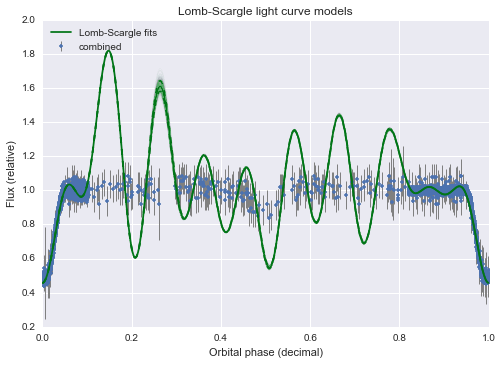


Model is only valid for the times fit:
from 2014-06-30T07:24:36.792Z to 2014-07-01T07:28:01.155Z


In [35]:
print("`models.chained.combined.inliers2.fit`: Save parameters from the combined Bayesian MCMC Lomb-Scargle\n" +
      "and segmented light curve models. Plot phased light curves from the Lomb-Scargle model.")
print("Because `best_period` was fit, the variance is in the x direction.")
print("NOTE: This model is not regularized. The poor fit is due to oversampling from phases\n" +
      "0.8 wrapped through 0.1 (the McDonald data). Only the period is fit in a <0.1 second range\n" +
      "using this model.")
# Save the -1*sigma, median, and +1*sigma values for the parameters.
# Percentiles are left-tailed p values (z < `percentile`) at 1 standard devation.
models.chained.combined.inliers2.fit = code.utils.Container()
for (prm_idx, label) in enumerate(models.chained.combined.inliers2.mcmc.labels):
    map(lambda lbl, pct: \
        setattr(models.chained.combined.inliers2.fit, lbl, pct),
        (label+'_lwr', label, label+'_upr'),
        np.percentile(models.chained.combined.inliers2.mcmc.trace[:, prm_idx],
                      q=[15.87, 50.0, 84.13], axis=0))
models.chained.combined.inliers2.fit.min_flux_time = code.utils.calc_min_flux_time(
    model=models.chained.combined.inliers2.ls.model,
    filt=models.chained.combined.inliers2.ls.filts[0],
    best_period=models.chained.combined.inliers2.fit.best_period,
    tol=0.1, maxiter=10)
models.chained.combined.inliers2.phases = code.utils.calc_phases(
    times=models.chained.combined.inliers2.times,
    best_period=models.chained.combined.inliers2.fit.best_period,
    min_flux_time=models.chained.combined.inliers2.fit.min_flux_time)
dataframes.combined.inliers2['phase_dec'] = models.chained.combined.inliers2.phases
models.chained.combined.inliers2.ls.phases = models.chained.combined.inliers2.phases
# The model is most applicable during times when the data was taken.
models.chained.combined.inliers2.fit.times = np.linspace(
    start=np.median(models.chained.combined.inliers2.times),
    stop=np.median(models.chained.combined.inliers2.times) + models.chained.combined.inliers2.fit.best_period,
    num=1000, endpoint=False)
# TODO: make into function that accepts an ISO8601 timestamp and predicts model starting at that time.
#     Function would modify models.chained.combined.inliers2.fit.times to start at given time.
models.chained.combined.inliers2.fit.phases = code.utils.calc_phases(
    times=models.chained.combined.inliers2.fit.times,
    best_period=models.chained.combined.inliers2.fit.best_period,
    min_flux_time=models.chained.combined.inliers2.fit.min_flux_time)
# Sort the fit data so that phase is monotonically increasing.
sorted_idxs = np.argsort(models.chained.combined.inliers2.fit.phases)
models.chained.combined.inliers2.fit.times = models.chained.combined.inliers2.fit.times[sorted_idxs]
models.chained.combined.inliers2.fit.phases = models.chained.combined.inliers2.fit.phases[sorted_idxs]
models.chained.combined.inliers2.fit.filts = \
    [models.chained.combined.inliers2.ls.filts[0]]*len(models.chained.combined.inliers2.fit.phases)
random_traces = models.chained.combined.inliers2.mcmc.trace[
    np.random.randint(len(models.chained.combined.inliers2.mcmc.trace), size=1000)]
# NOTE: There are two kinds of models, so two kinds of fluxes.
models.chained.combined.inliers2.fit.ls = code.utils.Container()
models.chained.combined.inliers2.fit.ls.times = \
    models.chained.combined.inliers2.fit.times
models.chained.combined.inliers2.fit.ls.filts = \
    models.chained.combined.inliers2.fit.filts
fluxes_arr = \
    map(lambda prm: \
        models.chained.combined.inliers2.ls.model.predict(
            t=models.chained.combined.inliers2.fit.ls.times,
            filts=models.chained.combined.inliers2.fit.ls.filts,
            period=prm[0]),
        random_traces)
models.chained.combined.inliers2.fit.ls.phases = \
    models.chained.combined.inliers2.fit.phases
(models.chained.combined.inliers2.fit.ls.fluxes_lwr,
 models.chained.combined.inliers2.fit.ls.fluxes,
 models.chained.combined.inliers2.fit.ls.fluxes_upr) = \
    np.percentile(fluxes_arr,
                  q=[15.87, 50.0, 84.13], axis=0)
plt.errorbar(
    models.chained.combined.inliers2.phases,
    models.chained.combined.inliers2.fluxes,
    models.chained.combined.inliers2.fluxes_err,
    ecolor='gray', marker='.', linestyle='', linewidth=1,
    label='combined', color=sns.color_palette()[0])
plt.plot(
    models.chained.combined.inliers2.fit.ls.phases,
    models.chained.combined.inliers2.fit.ls.fluxes,
    marker='', linestyle='-', label='Lomb-Scargle fits',
    color=sns.color_palette(name='dark')[1])
plt.plot(
    models.chained.combined.inliers2.fit.ls.phases,
    models.chained.combined.inliers2.fit.ls.fluxes_lwr,
    marker='', linestyle='--', label=None,
    color=sns.color_palette(name='dark')[1])
plt.plot(
    models.chained.combined.inliers2.fit.ls.phases,
    models.chained.combined.inliers2.fit.ls.fluxes_upr,
    marker='', linestyle='--', label=None,
    color=sns.color_palette(name='dark')[1])
for fluxes in fluxes_arr:
    plt.plot(
        models.chained.combined.inliers2.fit.ls.phases,
        fluxes,
        marker='', linestyle='-', linewidth=1, alpha=0.01,
        label=None, color=sns.color_palette()[1])
plt.title("Lomb-Scargle light curve models")
plt.xlabel("Orbital phase (decimal)")
plt.ylabel("Flux (relative)")
plt.legend(loc='upper left')
plt.show()
print()
print(("Model is only valid for the times fit:\n"
       "from {ts_begin}Z to {ts_end}Z").format(
    ts_begin=astropy_time.Time(min(models.chained.combined.inliers2.fit.ls.times), format='unix', scale='tcb').utc.isot,
    ts_end=astropy_time.Time(max(models.chained.combined.inliers2.fit.ls.times), format='unix', scale='tcb').utc.isot))

`models.chained.combined.inliers2.fit.ls`: Plot phased residuals
from Lomb-Scargle light curve model.


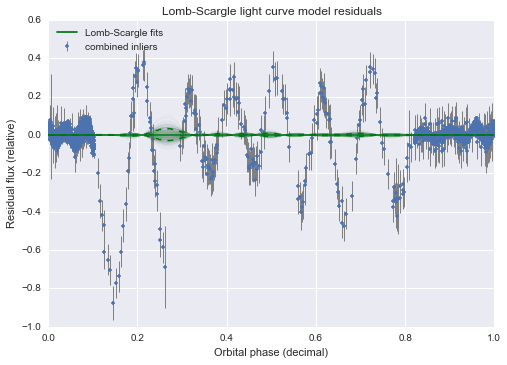

For a given phase observed between
2014-06-30T07:24:36.792 and 2014-07-01T07:28:01.155
these are the expected errors from the model.

`models.chained.combined.inliers2.fit.ls`: Measure Gaussianity of residuals using rank-based statistics.

Departure from Gaussian core: number of sigma, Z1 = 3.60985899785
Departure from Gaussian tail: number of sigma, Z2 = 70.8646580558

Z1 > 2: The model may under-fit the inlier data, i.e. the model may have high bias.
Z2 > 2: There may still be outliers in the inlier data.


In [36]:
print("`models.chained.combined.inliers2.fit.ls`: Plot phased residuals\n" +
      "from Lomb-Scargle light curve model.")
(models.chained.combined.inliers2.ls.fluxes_res,
 models.chained.combined.inliers2.ls.fluxes_interp) = \
    code.utils.calc_residual_fluxes(
        phases=models.chained.combined.inliers2.ls.phases,
        fluxes=models.chained.combined.inliers2.ls.fluxes,
        fit_phases=models.chained.combined.inliers2.fit.ls.phases,
        fit_fluxes=models.chained.combined.inliers2.fit.ls.fluxes)
assert np.all(np.isclose(
        models.chained.combined.inliers2.ls.fluxes - models.chained.combined.inliers2.ls.fluxes_interp,
        models.chained.combined.inliers2.ls.fluxes_res))
# NOTE: Don't save fluxes_res to 'flux_rel_res' and fluxes_interp to 'flux_rel_fit'
#     since the Lomb-Scargle model is only used to fit the period.
plt.errorbar(
    models.chained.combined.inliers2.ls.phases,
    models.chained.combined.inliers2.ls.fluxes_res,
    models.chained.combined.inliers2.ls.fluxes_err,
    ecolor='gray', marker='.', linestyle='', linewidth=1,
    label='combined inliers', color=sns.color_palette()[0])
plt.plot(
    models.chained.combined.inliers2.fit.ls.phases,
    [np.median(models.chained.combined.inliers2.ls.fluxes_res)]*len(models.chained.combined.inliers2.fit.ls.phases),
    marker='', linestyle='-', label='Lomb-Scargle fits',
    color=sns.color_palette(name='dark')[1])
plt.plot(
    models.chained.combined.inliers2.fit.ls.phases,
    models.chained.combined.inliers2.fit.ls.fluxes_upr - models.chained.combined.inliers2.fit.ls.fluxes,
    marker='', linestyle='--', label=None,
    color=sns.color_palette(name='dark')[1])
plt.plot(
    models.chained.combined.inliers2.fit.ls.phases,
    models.chained.combined.inliers2.fit.ls.fluxes_lwr - models.chained.combined.inliers2.fit.ls.fluxes,
    marker='', linestyle='--', label=None,
    color=sns.color_palette(name='dark')[1])
for fluxes in fluxes_arr:
    plt.plot(
        models.chained.combined.inliers2.fit.ls.phases,
        fluxes - models.chained.combined.inliers2.fit.ls.fluxes,
        marker='', linestyle='-', linewidth=1, alpha=0.01,
        label=None, color=sns.color_palette()[1])
plt.title("Lomb-Scargle light curve model residuals")
plt.xlabel("Orbital phase (decimal)")
plt.ylabel("Residual flux (relative)")
plt.legend(loc='upper left')
plt.show()
print(("For a given phase observed between\n" +
       "{ts_begin} and {ts_end}\n" +
       "these are the expected errors from the model.").format(
        ts_begin=astropy_time.Time(min(models.chained.combined.inliers2.fit.ls.times), format='unix', scale='tcb').utc.isot,
        ts_end=astropy_time.Time(max(models.chained.combined.inliers2.fit.ls.times), format='unix', scale='tcb').utc.isot))
# TODO: plot expected errors as a function of time over years.
print()
print("`models.chained.combined.inliers2.fit.ls`: Measure Gaussianity of residuals using rank-based statistics.")
(models.chained.combined.inliers2.fit.ls.z1, models.chained.combined.inliers2.fit.ls.z2) = \
    code.utils.calc_z1_z2(dist=models.chained.combined.inliers2.ls.fluxes_res)
print()
print(("Departure from Gaussian core: number of sigma, Z1 = {z1}\n" +
       "Departure from Gaussian tail: number of sigma, Z2 = {z2}").format(
        z1=models.chained.combined.inliers2.fit.ls.z1, z2=models.chained.combined.inliers2.fit.ls.z2))
print()
if models.chained.combined.inliers2.fit.ls.z1 > 2.0:
    print("Z1 > 2: The model may under-fit the inlier data, i.e. the model may have high bias.")
else:
    print("Z1 <= 2: The model does not appear to under-fit the inlier data.")
if models.chained.combined.inliers2.fit.ls.z2 > 2.0:
    print("Z2 > 2: There may still be outliers in the inlier data.")
else:
    print("Z2 <= 2: There do not appear to be any remaining outliers in the inlier data.")

`models.chained.combined.inliers2.fit.seg`: Plot phased light curves for segmented models.


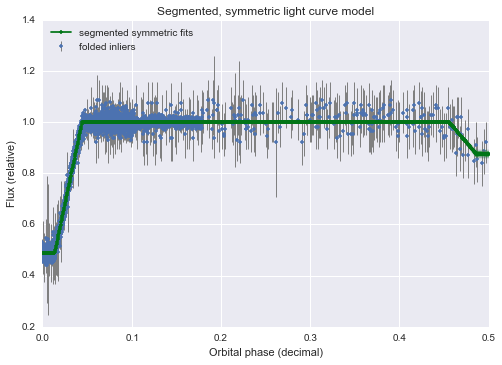


Model is only valid for the times fit:
from 2014-06-30T07:24:36.792Z to 2014-07-01T07:28:01.155Z


In [37]:
print("`models.chained.combined.inliers2.fit.seg`: Plot phased light curves for segmented models.")
# At every phase point, plot the median and standard deviation
# of the flux values from the many light curve models.
models.chained.combined.inliers2.seg = code.utils.Container()
tfmask_lt05 = models.chained.combined.inliers2.phases < 0.5
models.chained.combined.inliers2.seg.phases = np.where(
    tfmask_lt05, models.chained.combined.inliers2.phases,
    1.0 - models.chained.combined.inliers2.phases)
models.chained.combined.inliers2.seg.times = models.chained.combined.inliers2.times
models.chained.combined.inliers2.seg.fluxes = models.chained.combined.inliers2.fluxes
models.chained.combined.inliers2.seg.fluxes_err = models.chained.combined.inliers2.fluxes_err
models.chained.combined.inliers2.fit.seg = code.utils.Container()
models.chained.combined.inliers2.fit.seg.times = models.chained.combined.inliers2.fit.ls.times
models.chained.combined.inliers2.fit.seg.phases = \
    np.linspace(start=0.0, stop=0.5, num=1001, endpoint=True)
fluxes_arr = \
    map(lambda prm: 
        code.utils.seg_model_fluxes_rel(
            params=prm[1:], phases=models.chained.combined.inliers2.fit.seg.phases),
        random_traces)
(models.chained.combined.inliers2.fit.seg.fluxes_lwr,
 models.chained.combined.inliers2.fit.seg.fluxes,
 models.chained.combined.inliers2.fit.seg.fluxes_upr) = \
    np.percentile(fluxes_arr,
                  q=[15.87, 50.0, 84.13], axis=0)
plt.errorbar(
    models.chained.combined.inliers2.seg.phases,
    models.chained.combined.inliers2.seg.fluxes,
    models.chained.combined.inliers2.seg.fluxes_err,
    ecolor='gray', marker='.', linestyle='', linewidth=1,
    label='folded inliers', color=sns.color_palette()[0])
plt.plot(models.chained.combined.inliers2.fit.seg.phases,
         models.chained.combined.inliers2.fit.seg.fluxes,
         marker='.', linestyle='-', label='segmented symmetric fits',
         color=sns.color_palette(name='dark')[1])
plt.plot(models.chained.combined.inliers2.fit.seg.phases,
         models.chained.combined.inliers2.fit.seg.fluxes_lwr,
         marker='', linestyle='--', label=None,
         color=sns.color_palette(name='dark')[1])
plt.plot(models.chained.combined.inliers2.fit.seg.phases,
         models.chained.combined.inliers2.fit.seg.fluxes_upr,
         marker='', linestyle='--', label=None,
         color=sns.color_palette(name='dark')[1])
for fluxes in fluxes_arr:
    plt.plot(models.chained.combined.inliers2.fit.seg.phases,
             fluxes,
             marker='', linestyle='-', linewidth=1, alpha=0.01, label=None,
             color=sns.color_palette()[1])
plt.title("Segmented, symmetric light curve model")
plt.xlabel("Orbital phase (decimal)")
plt.ylabel("Flux (relative)")
plt.legend(loc='upper left')
plt.show()
print()
print(("Model is only valid for the times fit:\n"
       "from {ts_begin}Z to {ts_end}Z").format(
    ts_begin=astropy_time.Time(min(models.chained.combined.inliers2.fit.seg.times), format='unix', scale='tcb').utc.isot,
    ts_end=astropy_time.Time(max(models.chained.combined.inliers2.fit.seg.times), format='unix', scale='tcb').utc.isot))

`models.chained.combined.inliers2.fit`, `dataframes.combined.inliers2`: Plot phased residuals
from segmented, symmetric light curve model.


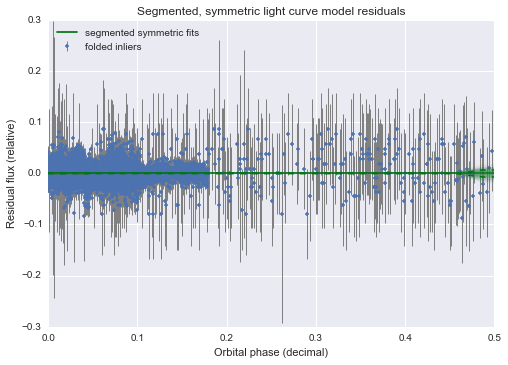

For a given phase observed between
2014-06-30T07:24:36.792 and 2014-07-01T07:28:01.155
these are the expected errors from the model.

`models.chained.combined.inliers2.seg`: Measure Gaussianity of residuals using rank-based statistics.

Departure from Gaussian core: number of sigma, Z1 = 0.752019418648
Departure from Gaussian tail: number of sigma, Z2 = 15.8396778698

Z1 <= 2: The model does not appear to under-fit the inlier data.
Z2 > 2: There may still be outliers in the inlier data.


In [38]:
print("`models.chained.combined.inliers2.fit`, `dataframes.combined.inliers2`: Plot phased residuals\n" +
      "from segmented, symmetric light curve model.")
# TODO: reorganize fits to be under models.chained.combined.inliers2.seg
(models.chained.combined.inliers2.seg.fluxes_res, models.chained.combined.inliers2.seg.fluxes_interp) = \
    code.utils.calc_residual_fluxes(
        phases=models.chained.combined.inliers2.seg.phases,
        fluxes=models.chained.combined.inliers2.seg.fluxes,
        fit_phases=models.chained.combined.inliers2.fit.seg.phases,
        fit_fluxes=models.chained.combined.inliers2.fit.seg.fluxes)
assert np.all(np.isclose(
        models.chained.combined.inliers2.seg.fluxes - models.chained.combined.inliers2.seg.fluxes_interp,
        models.chained.combined.inliers2.seg.fluxes_res))
dataframes.combined.inliers2['flux_rel_res'] = models.chained.combined.inliers2.seg.fluxes_res
dataframes.combined.inliers2['flux_rel_fit'] = models.chained.combined.inliers2.seg.fluxes_interp
plt.errorbar(
    models.chained.combined.inliers2.seg.phases,
    models.chained.combined.inliers2.seg.fluxes_res,
    models.chained.combined.inliers2.seg.fluxes_err,
    ecolor='gray', marker='.', linestyle='', linewidth=1,
    label='folded inliers', color=sns.color_palette()[0])
plt.plot(
    models.chained.combined.inliers2.fit.seg.phases,
    [np.median(models.chained.combined.inliers2.seg.fluxes_res)]*len(models.chained.combined.inliers2.fit.seg.phases),
    marker='', linestyle='-', label='segmented symmetric fits',
    color=sns.color_palette(name='dark')[1])
plt.plot(
    models.chained.combined.inliers2.fit.seg.phases,
    models.chained.combined.inliers2.fit.seg.fluxes_upr - models.chained.combined.inliers2.fit.seg.fluxes,
    marker='', linestyle='--', label=None,
    color=sns.color_palette(name='dark')[1])
plt.plot(
    models.chained.combined.inliers2.fit.seg.phases,
    models.chained.combined.inliers2.fit.seg.fluxes_lwr - models.chained.combined.inliers2.fit.seg.fluxes,
    marker='', linestyle='--', label=None,
    color=sns.color_palette(name='dark')[1])
for fluxes in fluxes_arr:
    plt.plot(
        models.chained.combined.inliers2.fit.seg.phases,
        fluxes - models.chained.combined.inliers2.fit.seg.fluxes,
        marker='', linestyle='-', linewidth=1, alpha=0.01,
        label=None, color=sns.color_palette()[1])
plt.title("Segmented, symmetric light curve model residuals")
plt.xlabel("Orbital phase (decimal)")
plt.ylabel("Residual flux (relative)")
plt.legend(loc='upper left')
plt.show()
print(("For a given phase observed between\n" +
       "{ts_begin} and {ts_end}\n" +
       "these are the expected errors from the model.").format(
        ts_begin=astropy_time.Time(min(models.chained.combined.inliers2.fit.seg.times), format='unix', scale='tcb').utc.isot,
        ts_end=astropy_time.Time(max(models.chained.combined.inliers2.fit.seg.times), format='unix', scale='tcb').utc.isot))
# TODO: plot expected errors as a function of time over years.
print()
print("`models.chained.combined.inliers2.seg`: Measure Gaussianity of residuals using rank-based statistics.")
(models.chained.combined.inliers2.seg.z1, models.chained.combined.inliers2.seg.z2) = \
    code.utils.calc_z1_z2(dist=models.chained.combined.inliers2.seg.fluxes_res)
print()
print(("Departure from Gaussian core: number of sigma, Z1 = {z1}\n" +
       "Departure from Gaussian tail: number of sigma, Z2 = {z2}").format(
        z1=models.chained.combined.inliers2.seg.z1, z2=models.chained.combined.inliers2.seg.z2))
print()
if models.chained.combined.inliers2.seg.z1 > 2.0:
    print("Z1 > 2: The model may under-fit the inlier data, i.e. the model may have high bias.")
else:
    print("Z1 <= 2: The model does not appear to under-fit the inlier data.")
if models.chained.combined.inliers2.seg.z2 > 2.0:
    print("Z2 > 2: There may still be outliers in the inlier data.")
else:
    print("Z2 <= 2: There do not appear to be any remaining outliers in the inlier data.")

In [39]:
dataframes.combined.inliers2.to_csv(
    path_or_buf=os.path.join(
        path_project, r'Work_Logs/20150216_light_curve_solution/20150706_lightcurve_BinaryMaker3.csv'),
    columns=['phase_dec', 'flux_rel'], index=False, quoting=csv.QUOTE_NONNUMERIC)

## Map light curve parameters to geometric parameters

Related structures for this section:
```
models.
    chained.
        combined.
            inliers2.
                fit.
                    phase_rel_int, phase_rel_ext, flux_pri_eclipse,
                    flux_out_eclipse, flux_sec_eclipse
                mcmc.
                    labels, trace
    geom.
        pri_as_oc., *_tr.
            params.
                values, labels,
                fit.
                    phase_rel_int, *_lwr, *_upr
                    phase_rel_ext, *_lwr, *_upr
                    flux_pri_eclipse, *_lwr, *_upr
                    flux_out_eclipse, *_lwr, *_upr
                    flux_sec_eclipse, *_lwr, *_upr
            geoms.
                values, labels,
                fit.
                    flux_intg_rel_s, *_lwr, *_upr
                    flux_intg_rel_g, *_lwr, *_upr
                    radii_ratio_lt, *_lwr, *upr
                    incl_deg, *_lwr, *_upr
                    radius_sep_s, *_lwr, *_upr
                    radius_sep_g, *_lwr, *_upr
            tfmask_incl
            periods.
                values
                fit.
                    best_period, *_lwr, *_upr
            min_flux_times.
                values
                fit.
                    min_flux_time, *_lwr, *_upr
```

In [40]:
print("`bestperiod_minfluxtime`: Map best_period to min_flux_time for fast lookup.")
# TODO: Move minfluxtime lookup into MCMC call.
bestperiod_minfluxtime = {
    best_period: code.utils.calc_min_flux_time(
        model=models.chained.combined.inliers2.ls.model,
        filt=models.chained.combined.inliers2.ls.filts[0],
        best_period=best_period,
        tol=0.1, maxiter=10)
     for best_period in np.unique(models.chained.combined.inliers2.mcmc.trace[:, 0])}

`bestperiod_minfluxtime`: Map best_period to min_flux_time for fast lookup.


In [41]:
print("`models.geom`: Create container for parameters.")
models.geom = code.utils.Container()

`models.geom`: Create container for parameters.


`models.geom.pri_as_oc`, `models.chained.combined.inliers2.mcmc`:
Assuming primary eclipse is occultation event.


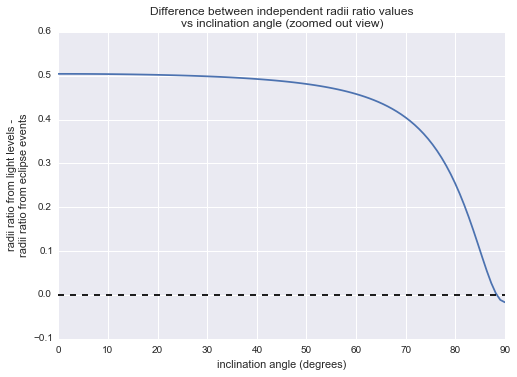

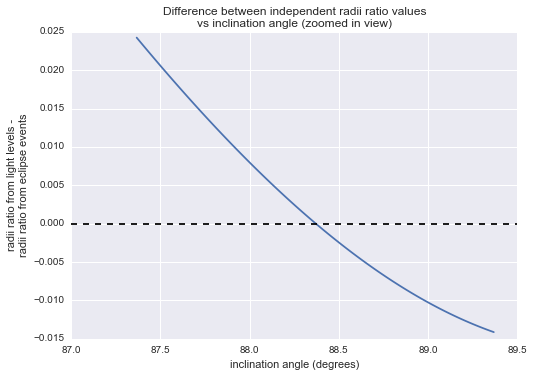

Geometric parameters corresponding to the maximum likelihood light curve parameters:
flux_intg_rel_s = 0.511
flux_intg_rel_g = 0.489
radii_ratio_lt = 0.504
incl_deg = 88.368
radius_sep_s = 0.093
radius_sep_g = 0.185
Order of `models.chained.combined.inliers2.mcmc.trace`:
('best_period', 'phase_rel_int', 'phase_rel_ext', 'flux_pri_eclipse', 'flux_out_eclipse', 'flux_sec_eclipse', 'flux_sigma')
Order of `models.chained.combined.inliers2.mcmc.trace` assumed for geometric model:
['phase_rel_int', 'phase_rel_ext', 'flux_pri_eclipse', 'flux_out_eclipse', 'flux_sec_eclipse']
Corresponding geometric model parameters:
(phase_rel_int, phase_rel_ext, light_oc, light_ref, light_tr)
Order of returned `geoms_arr`:
('flux_intg_rel_s', 'flux_intg_rel_g', 'radii_ratio_lt', 'incl_deg', 'radius_sep_s', 'radius_sep_g')


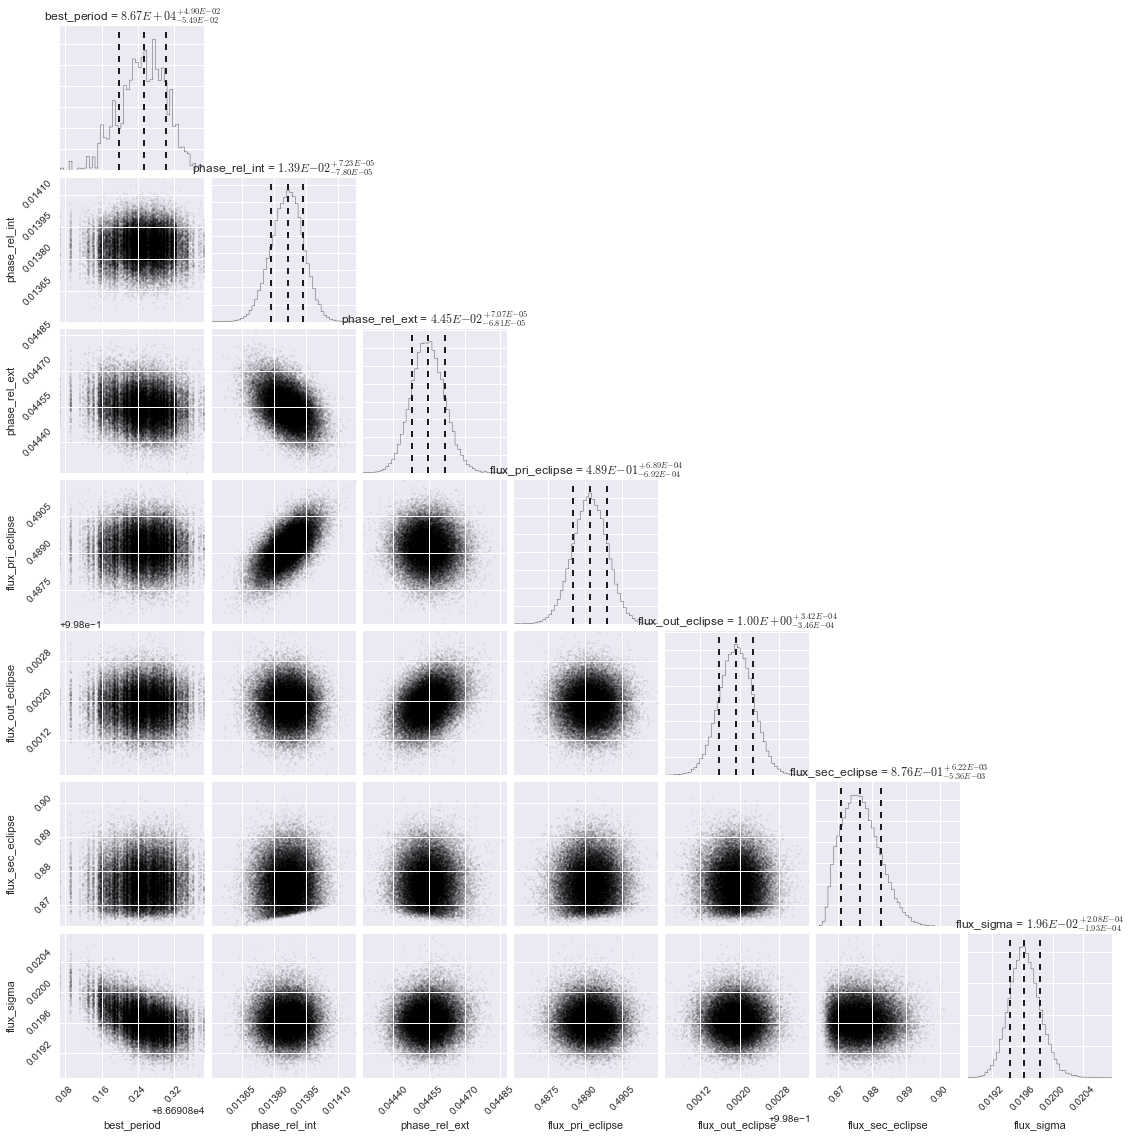

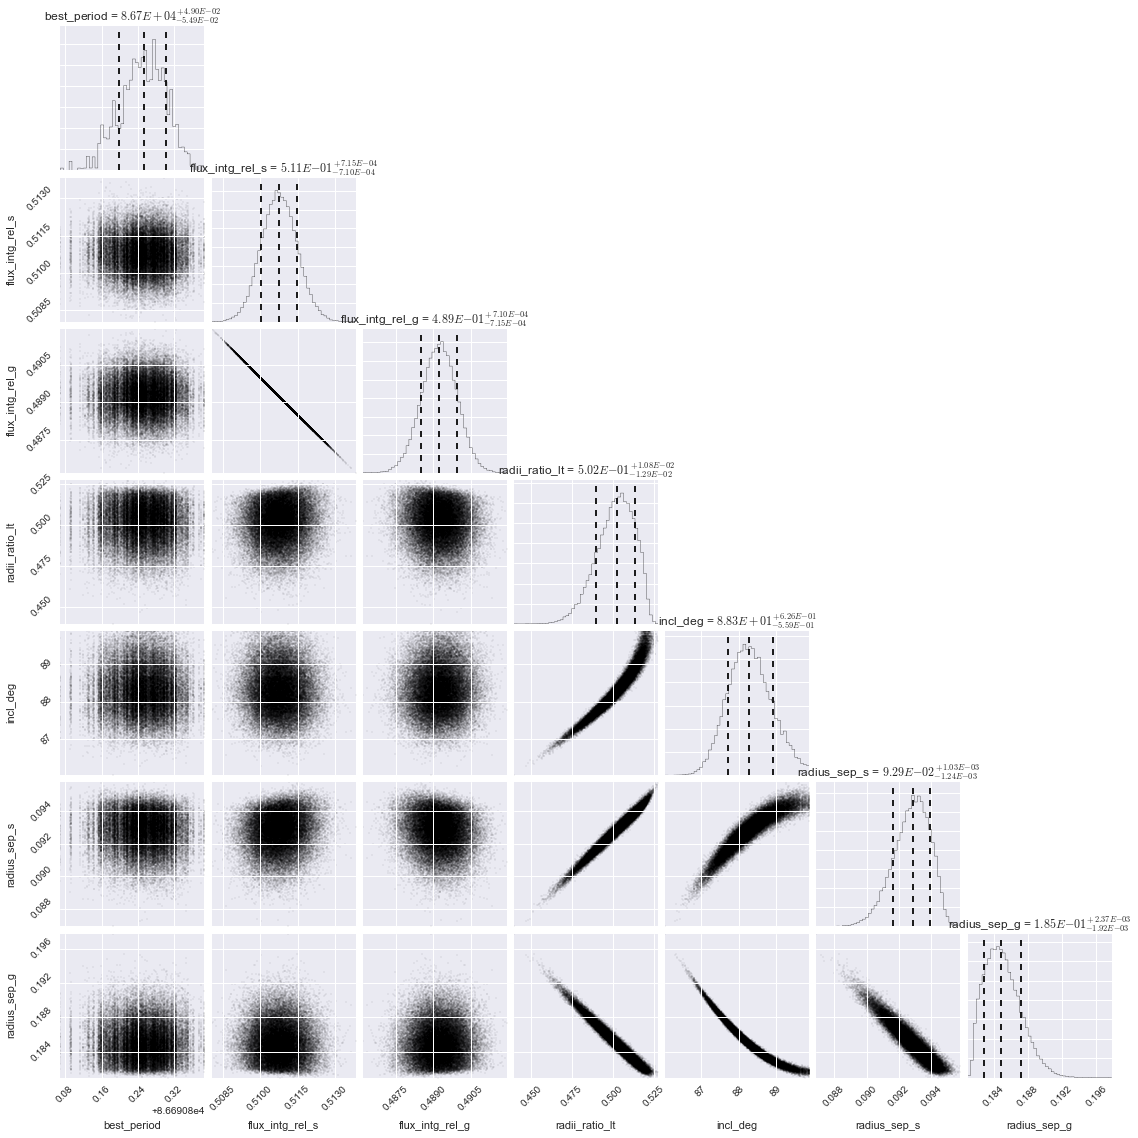

Number of parameters with solutions for inclination: 53772


[None, None, None]

In [42]:
print("`models.geom.pri_as_oc`, `models.chained.combined.inliers2.mcmc`:\n" +
      "Assuming primary eclipse is occultation event.")
# (phase_rel_int, phase_rel_ext, flux_pri_eclipse, flux_out_eclipse, flux_sec_eclipse)
# ==
# (phase_rel_int, phase_rel_ext, light_oc, light_ref, light_tr)
warnings.simplefilter('once')
params = (models.chained.combined.inliers2.fit.phase_rel_int,
          models.chained.combined.inliers2.fit.phase_rel_ext,
          models.chained.combined.inliers2.fit.flux_pri_eclipse,
          models.chained.combined.inliers2.fit.flux_out_eclipse,
          models.chained.combined.inliers2.fit.flux_sec_eclipse)
geoms = code.utils.model_geometry_from_light_curve(params=params, show_plots=True)
print("Geometric parameters corresponding to the maximum likelihood light curve parameters:")
geoms_labels = ('flux_intg_rel_s', 'flux_intg_rel_g', 'radii_ratio_lt',
                'incl_deg', 'radius_sep_s', 'radius_sep_g')
for (label, geom) in zip(geoms_labels, np.around(geoms, decimals=3)):
    print("{label} = {geom}".format(label=label, geom=geom))
print(("Order of `models.chained.combined.inliers2.mcmc.trace`:\n"+
       "{labels}\n" +
       "Order of `models.chained.combined.inliers2.mcmc.trace` assumed for geometric model:\n" +
       "{labels_sel}\n" +
       "Corresponding geometric model parameters:\n"
       "(phase_rel_int, phase_rel_ext, light_oc, light_ref, light_tr)").format(
        labels=models.chained.combined.inliers2.mcmc.labels,
        labels_sel=[models.chained.combined.inliers2.mcmc.labels.__getitem__(idx) for idx in [1, 2, 3, 4, 5]]))
print(("Order of returned `geoms_arr`:\n" +
       "{labels}").format(labels=geoms_labels))
params_arr = [[params.__getitem__(idx) for idx in [1, 2, 3, 4, 5]]
              for params in models.chained.combined.inliers2.mcmc.trace]
warnings.simplefilter('ignore')
geoms_arr = np.asarray([
        code.utils.model_geometry_from_light_curve(params=params, show_plots=False)
        for params in params_arr])
# Filter data for parameters with a solution for inclination.
tfmask_incl = np.logical_not(np.isclose(geoms_arr[:, 3], 90.0))
if np.count_nonzero(tfmask_incl) > 0:
    # For `triangle.corner`:
    # `quantiles` are left-tailed p-values (z < `quantile`) at 1 standard devation for histograms.
    # `levels` are confidence levels (|z| < `level`) at 1 standard deviation for contour plots.
    # NOTE: `levels` are ignored when plot_contours = True and when used with seaborn.
    # Contours also override seaborn's grid.
    fig = triangle.corner(
        xs=models.chained.combined.inliers2.mcmc.trace[tfmask_incl],
        labels=models.chained.combined.inliers2.mcmc.labels,
        show_titles=True, title_fmt='.2E', scale_hist=False,
        quantiles=[0.1587, 0.5, 0.8413], verbose=False,
        plot_contours=False, plot_datapoints=True,
        data_kwargs={'alpha': 0.1, 'marker': ','})
    plt.show(fig)
    # Insert periods to show dependence of geometric parameters on period.
    periods_geoms_arr = np.insert(geoms_arr, 0, models.chained.combined.inliers2.mcmc.trace[:, 0], axis=1)
    periods_geoms_labels = np.insert(geoms_labels, 0, models.chained.combined.inliers2.mcmc.labels[0])
    fig = triangle.corner(
        xs=periods_geoms_arr[tfmask_incl],
        labels=periods_geoms_labels,
        show_titles=True, title_fmt='.2E', scale_hist=False,
        quantiles=[0.1587, 0.5, 0.8413], verbose=False,
        plot_contours=False, plot_datapoints=True,
        data_kwargs={'alpha': 0.1, 'marker': ','})
    plt.show(fig)
    print("Number of parameters with solutions for inclination: {num}".format(num=len(geoms_arr[tfmask_incl])))
else:
    print()
    print("Model has no parameters with solutions for inclination.")
# Save results.
models.geom.pri_as_oc = code.utils.Container()
models.geom.pri_as_oc.params = code.utils.Container()
models.geom.pri_as_oc.params.values = np.asarray(params_arr)
models.geom.pri_as_oc.params.labels = models.chained.combined.inliers2.mcmc.labels[1:-1]
models.geom.pri_as_oc.params.fit = code.utils.Container()
for (prm_idx, label) in enumerate(models.geom.pri_as_oc.params.labels):
    map(lambda lbl, pct: \
        setattr(models.geom.pri_as_oc.params.fit, lbl, pct),
        (label+'_lwr', label, label+'_upr'),
        np.percentile(models.geom.pri_as_oc.params.values[:, prm_idx],
                      q=[15.87, 50.0, 84.13], axis=0))
models.geom.pri_as_oc.geoms = code.utils.Container()
models.geom.pri_as_oc.geoms.values = np.asarray(geoms_arr)
models.geom.pri_as_oc.geoms.labels = geoms_labels
models.geom.pri_as_oc.geoms.fit = code.utils.Container()
for (prm_idx, label) in enumerate(models.geom.pri_as_oc.geoms.labels):
    map(lambda lbl, pct: \
        setattr(models.geom.pri_as_oc.geoms.fit, lbl, pct),
        (label+'_lwr', label, label+'_upr'),
        np.percentile(models.geom.pri_as_oc.geoms.values[:, prm_idx],
                      q=[15.87, 50.0, 84.13], axis=0))
models.geom.pri_as_oc.tfmask_incl = tfmask_incl
models.geom.pri_as_oc.periods = code.utils.Container()
models.geom.pri_as_oc.periods.values = models.chained.combined.inliers2.mcmc.trace[:, 0]
models.geom.pri_as_oc.periods.fit = code.utils.Container()
for (_, label) in enumerate(models.chained.combined.inliers2.mcmc.labels[:1]):
    map(lambda lbl, pct: \
        setattr(models.geom.pri_as_oc.periods.fit, lbl, pct),
        (label+'_lwr', label, label+'_upr'),
        np.percentile(models.geom.pri_as_oc.periods.values[:],
                      q=[15.87, 50.0, 84.13], axis=0))
models.geom.pri_as_oc.min_flux_times = code.utils.Container()
models.geom.pri_as_oc.min_flux_times.values = np.asarray(
    [bestperiod_minfluxtime[best_period] for best_period
     in models.geom.pri_as_oc.periods.values])
models.geom.pri_as_oc.min_flux_times.fit = code.utils.Container()
map(lambda sfx, pct: \
    setattr(models.geom.pri_as_oc.min_flux_times.fit, 'min_flux_time'+sfx, pct),
    ('_lwr', '', '_upr'),
    np.percentile(models.geom.pri_as_oc.min_flux_times.values[:],
                      q=[15.87, 50.0, 84.13], axis=0))

`models.geom.pri_as_tr`, `models.chained.combined.inliers2.mcmc`:
Assuming primary eclipse is transit event.


/Users/samharrold/anaconda/lib/python2.7/site-packages/binstarsolver-0.1.3-py2.7.egg/binstarsolver/utils.py:434: UserWarning: 
Inclination does not yield self-consistent solution.
Input parameters cannot be fit by model:
    radii_ratio_lt = 0.763743541574
    phase_orb_ext  = 0.279875388363
    phase_orb_int  = 0.0871158532098
    tol            = 0.0001


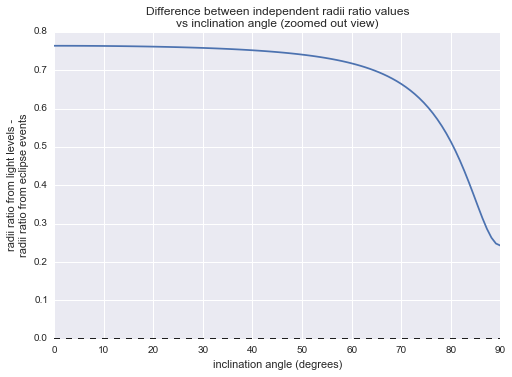

Geometric parameters corresponding to the maximum likelihood light curve parameters:
flux_intg_rel_s = 0.124
flux_intg_rel_g = 0.876
radii_ratio_lt = 0.764
incl_deg = 90.0
radius_sep_s = 0.095
radius_sep_g = 0.182
Order of `models.chained.combined.inliers2.mcmc.trace`:
('best_period', 'phase_rel_int', 'phase_rel_ext', 'flux_pri_eclipse', 'flux_out_eclipse', 'flux_sec_eclipse', 'flux_sigma')
Order of `models.chained.combined.inliers2.mcmc.trace` assumed for geometric model:
['phase_rel_int', 'phase_rel_ext', 'flux_sec_eclipse', 'flux_out_eclipse', 'flux_pri_eclipse']
Corresponding geometric model parameters:
(phase_rel_int, phase_rel_ext, light_oc, light_ref, light_tr)
Order of returned `geoms_arr`:
('flux_intg_rel_s', 'flux_intg_rel_g', 'radii_ratio_lt', 'incl_deg', 'radius_sep_s', 'radius_sep_g')

Model has no parameters with solutions for inclination.


/Users/samharrold/anaconda/lib/python2.7/site-packages/binstarsolver-0.1.3-py2.7.egg/binstarsolver/utils.py:465: UserWarning: 
No inclination solution found.


[None, None, None]

In [43]:
print("`models.geom.pri_as_tr`, `models.chained.combined.inliers2.mcmc`:\n" +
      "Assuming primary eclipse is transit event.")
# (phase_rel_int, phase_rel_ext, flux_sec_eclipse, flux_out_eclipse, flux_pri_eclipse)
# ==
# (phase_rel_int, phase_rel_ext, light_oc, light_ref, light_tr)
warnings.simplefilter('once')
params = (models.chained.combined.inliers2.fit.phase_rel_int,
          models.chained.combined.inliers2.fit.phase_rel_ext,
          models.chained.combined.inliers2.fit.flux_sec_eclipse,
          models.chained.combined.inliers2.fit.flux_out_eclipse,
          models.chained.combined.inliers2.fit.flux_pri_eclipse)
geoms = code.utils.model_geometry_from_light_curve(params=params, show_plots=True)
print("Geometric parameters corresponding to the maximum likelihood light curve parameters:")
geoms_labels = ('flux_intg_rel_s', 'flux_intg_rel_g', 'radii_ratio_lt',
                'incl_deg', 'radius_sep_s', 'radius_sep_g')
for (label, geom) in zip(geoms_labels, np.around(geoms, decimals=3)):
    print("{label} = {geom}".format(label=label, geom=geom))
print(("Order of `models.chained.combined.inliers2.mcmc.trace`:\n"+
       "{labels}\n" +
       "Order of `models.chained.combined.inliers2.mcmc.trace` assumed for geometric model:\n" +
       "{labels_sel}\n" +
       "Corresponding geometric model parameters:\n"
       "(phase_rel_int, phase_rel_ext, light_oc, light_ref, light_tr)").format(
        labels=models.chained.combined.inliers2.mcmc.labels,
        labels_sel=[models.chained.combined.inliers2.mcmc.labels.__getitem__(idx) for idx in [1, 2, 5, 4, 3]]))
print(("Order of returned `geoms_arr`:\n" +
       "{labels}").format(labels=geoms_labels))
params_arr = [[params.__getitem__(idx) for idx in [1, 2, 5, 4, 3]]
              for params in models.chained.combined.inliers2.mcmc.trace]
warnings.simplefilter('ignore')
geoms_arr = np.asarray([
        code.utils.model_geometry_from_light_curve(params=params, show_plots=False)
        for params in params_arr])
# Filter data for parameters with a solution for inclination.
tfmask_incl = np.logical_not(np.isclose(geoms_arr[:, 3], 90.0))
if np.count_nonzero(tfmask_incl) > 0:
    # For `triangle.corner`:
    # `quantiles` are left-tailed p-values (z < `quantile`) at 1 standard devation for histograms.
    # `levels` are confidence levels (|z| < `level`) at 1 standard deviation for contour plots.
    # NOTE: `levels` are ignored when plot_contours = True and when used with seaborn.
    # Contours also override seaborn's grid.
    fig = triangle.corner(
        xs=models.chained.combined.inliers2.mcmc.trace[tfmask_incl],
        labels=models.chained.combined.inliers2.mcmc.labels,
        show_titles=True, title_fmt='.2E', scale_hist=False,
        quantiles=[0.1587, 0.5, 0.8413], verbose=False,
        plot_contours=False, plot_datapoints=True,
        data_kwargs={'alpha': 0.1, 'marker': ','})
    plt.show(fig)
    # Insert periods to show dependence of geometric parameters on period.
    periods_geoms_arr = np.insert(geoms_arr, 0, models.chained.combined.inliers2.mcmc.trace[:, 0], axis=1)
    periods_geoms_labels = np.insert(geoms_labels, 0, models.chained.combined.inliers2.mcmc.labels[0])
    fig = triangle.corner(
        xs=periods_geoms_arr[tfmask_incl],
        labels=periods_geoms_labels,
        show_titles=True, title_fmt='.2E', scale_hist=False,
        quantiles=[0.1587, 0.5, 0.8413], verbose=False,
        plot_contours=False, plot_datapoints=True,
        data_kwargs={'alpha': 0.1, 'marker': ','})
    plt.show(fig)
    print("Number of parameters with solutions for inclination: {num}".format(num=len(geoms_arr[tfmask_incl])))
else:
    print()
    print("Model has no parameters with solutions for inclination.")
# Save results.
models.geom.pri_as_tr = code.utils.Container()
models.geom.pri_as_tr.params = code.utils.Container()
models.geom.pri_as_tr.params.values = np.asarray(params_arr)
models.geom.pri_as_tr.params.labels = models.chained.combined.inliers2.mcmc.labels[1:-1]
models.geom.pri_as_tr.params.fit = code.utils.Container()
for (prm_idx, label) in enumerate(models.geom.pri_as_tr.params.labels):
    map(lambda lbl, pct: \
        setattr(models.geom.pri_as_tr.params.fit, lbl, pct),
        (label+'_lwr', label, label+'_upr'),
        np.percentile(models.geom.pri_as_tr.params.values[:, prm_idx],
                      q=[15.87, 50.0, 84.13], axis=0))
models.geom.pri_as_tr.geoms = code.utils.Container()
models.geom.pri_as_tr.geoms.values = np.asarray(geoms_arr)
models.geom.pri_as_tr.geoms.labels = geoms_labels
models.geom.pri_as_tr.geoms.fit = code.utils.Container()
for (prm_idx, label) in enumerate(models.geom.pri_as_tr.geoms.labels):
    map(lambda lbl, pct: \
        setattr(models.geom.pri_as_tr.geoms.fit, lbl, pct),
        (label+'_lwr', label, label+'_upr'),
        np.percentile(models.geom.pri_as_tr.geoms.values[:, prm_idx],
                      q=[15.87, 50.0, 84.13], axis=0))
models.geom.pri_as_tr.tfmask_incl = tfmask_incl
models.geom.pri_as_tr.periods = code.utils.Container()
models.geom.pri_as_tr.periods.values = models.chained.combined.inliers2.mcmc.trace[:, 0]
models.geom.pri_as_tr.periods.fit = code.utils.Container()
for (_, label) in enumerate(models.chained.combined.inliers2.mcmc.labels[:1]):
    map(lambda lbl, pct: \
        setattr(models.geom.pri_as_tr.periods.fit, lbl, pct),
        (label+'_lwr', label, label+'_upr'),
        np.percentile(models.geom.pri_as_tr.periods.values[:],
                      q=[15.87, 50.0, 84.13], axis=0))
models.geom.pri_as_tr.min_flux_times = code.utils.Container()
models.geom.pri_as_tr.min_flux_times.values = np.asarray(
    [bestperiod_minfluxtime[best_period] for best_period
     in models.geom.pri_as_tr.periods.values])
models.geom.pri_as_tr.min_flux_times.fit = code.utils.Container()
map(lambda sfx, pct: \
    setattr(models.geom.pri_as_tr.min_flux_times.fit, 'min_flux_time'+sfx, pct),
    ('_lwr', '', '_upr'),
    np.percentile(models.geom.pri_as_tr.min_flux_times.values[:],
                      q=[15.87, 50.0, 84.13], axis=0))

## Calculate ephemeris.

Related structures for this section:
```
models.
    geom.
        pri_as_oc.
            periods.
                fit.
                    best_period
                    min_flux_time
            params.
                fit.
                    phase_rel_int
                    phase_rel_ext
dataframes.
    ephemeris
```

In [44]:
print("`models.ephemeris`, `models.geom.pri_as_oc`: Create ephemeris of eclipse events and save as CSV.")
# NOTE: astropy.time.Time takes ~16 seconds for 3650 elements, i.e. ~16 seconds for 365 phase cycles.
# TODO: Make method to check ephemeris against existing data.
# Events to check against by hand (accuracy of events below is +/- 5 minutes):
# date    , beg_pri_in, end_pri_in, mid_pri, beg_pri_eg, end_pri_eg
# 2014-06-29, nan       , 07:33     , 07:51  , 08:08     , 08:56
# 2014-06-30, 06:45     , 07:35     , 07:55  , 08:15     , 09:05
# 2014-07-01, nan       , 07:40     , 08:00  , 08:11     , 09:07
# 2014-07-02, nan       , nan       , nan    , 08:24     , nan
# 2014-07-03, nan       , 07:52     , 08:08  , 08:26     , nan
# 2014-07-04, 07:04     , 07:56     , 08:16  , 08:34     , 09:26
# 2014-07-06, 07:11     , 08:05     , 08:23  , 08:41     , 09:32
time_start_iso = '2014-01-01T00:00:00.000000Z'
time_stop_iso = '2020-01-01T00:00:00.000000Z'
time_start = astropy_time.Time(time_start_iso, format='isot', scale='utc').tcb.unix
time_stop = astropy_time.Time(time_stop_iso, format='isot', scale='utc').tcb.unix
time = time_start
# TODO: The ephemeris under estimates the duration of the eclipse by ~15 minutes
# because it assumes a trapezoidal light curve shape.
best_period   = models.geom.pri_as_oc.periods.fit.best_period
time_rel_int  = models.geom.pri_as_oc.params.fit.phase_rel_int * best_period
time_rel_ext  = models.geom.pri_as_oc.params.fit.phase_rel_ext * best_period
min_flux_time = models.geom.pri_as_oc.min_flux_times.fit.min_flux_time
ephemeris = list()
while time < time_stop:
    phase = code.utils.calc_phases(
        times=time, best_period=best_period,
        min_flux_time=min_flux_time)
    time_phase0 = code.utils.calc_next_phase0_time(
        time=time, phase=phase, best_period=best_period)
    time_phase05 = time_phase0 + 0.5*best_period
    time_events = (
        time_phase0 - time_rel_ext, time_phase0 - time_rel_int, time_phase0,
        time_phase0 + time_rel_int, time_phase0 + time_rel_ext,
        time_phase05 - time_rel_ext, time_phase05 - time_rel_int, time_phase05,
        time_phase05 + time_rel_int, time_phase05 + time_rel_ext)
    ephemeris.append(time_events)
    time = time_phase0 + 1.0
dataframes.ephemeris = pd.DataFrame(
    data=ephemeris,
    columns=[
        'time_begin_primary_ingress_UTC', 'time_end_primary_ingress_UTC', 'time_mid_primary_UTC',
        'time_begin_primary_egress_UTC', 'time_end_primary_egress_UTC',
        'time_begin_secondary_ingress_UTC', 'time_end_secondary_ingress_UTC', 'time_mid_secondary_UTC',
        'time_begin_secondary_egress_UTC', 'time_end_secondary_egress_UTC'])
dataframes.ephemeris = dataframes.ephemeris.applymap(
    lambda time: astropy_time.Time(time, format='unix', scale='tcb').utc.isot+'Z')
path_ephemeris = os.path.join(
    path_project,
    r'Work_Logs/20150216_light_curve_solution/ephemeris_{start}_to_{stop}.csv'.format(
        start=time_start_iso.replace('-', '').replace(':', '').replace('.000000Z', 'Z'),
        stop=time_stop_iso.replace('-', '').replace(':', '').replace('.000000Z', 'Z')))
dataframes.ephemeris.to_csv(path_ephemeris, quoting=csv.QUOTE_NONNUMERIC)

`models.ephemeris`, `models.geom.pri_as_oc`: Create ephemeris of eclipse events and save as CSV.


## Incorporate data from Gianninas

### Visualize radial velocity data from Gianninas

**TODO:**
* Correct 'velr_kmps' for heliocentric velocity.
* Use posterior of inclination in model rather than median (maximum likelihood).
* **NOTE:** As of 2015-07-30, the implementation of the correlation method above does not work. Redo using a matched filter to extract the prominant spectral features then correlate those?

# REDO ALL BELOW

NOTE: Resolution of spectrum in 2014_elm18.txt is delta_lambda = 0.36 Angstroms at 4300 Angstroms. To detect a +/- 132 Kmps radial velocity is a pixel difference of  
4300 Anstroms * (132.9 kilometers per second)/(speed of light) ~ 1.91 Angstroms  
=> 1.91 Ang / 0.36 Ang/pixel = 5.3 pixels.

m1/m2 = v2/v1 => 0.145/0.423 = v1/132.9 => v1 = 45.6 kmps  
=> 4300 Anstroms * (45.6 kilometers per second)/(speed of light) = 0.65 Ang  
=> 0.65 Ang / 0.36 Ang/pixel = 1.81

* Hotter the star, deeper the lines: Example double-line binary WD: http://iopscience.iop.org/2041-8205/735/2/L30/pdf/2041-8205_735_2_L30.pdf. Stars in paper had Teff ratio 2.01 and had secondary absorption feature present at (4% - -2% =) 6% level at 6550 Ang.
* Teff ratio Teff_s/Teff_g = 1.42. So secondary absoprtion may be present at (1.42/2.01 * 6% =) 4% level at 6550 Ang, however our data is for 4350 Ang, which has weaker lines.

Problems:
* The problem is that when I plug in modeled parameters from gianninas, the ratio of radii do not match those from the light curve.  
* Expect R=0.0056Rsun for M=0.15Msun; R=0.0039Rsun for M=0.44Msun  
From R ~ M^-.33 with R=0.003Rsun, M=1Msun for Sirius B

Radii aren't reasonable for white dwarfs.
* Load the data into bm3, play with teff parameters. save plots
* load data into phoebe 2.0 and http://iopscience.iop.org/2041-8205/735/2/L30/pdf/2041-8205_735_2_L30.pdf.
Have those programs fit the data.

Related structures for this section:
```
dataframes.
    rvel
models.
    geom.
        pri_as_oc.
            periods.
                fit.
                    best_period
            min_fux_times.
                fit.
                    min_flux_time
```

In [270]:
print("`dataframes.velr`: Load wavelength offsets from correlations of spectra.\n" +
      "Convert to radial velocities.")
# Load JSON data.
path_json = os.path.join(
    path_project,
    r'Work_Logs/20150216_light_curve_solution/20150730T140000_radial_velocity_wavelength_offsets_from_flux_norm.json')
with open(path_json, 'rb') as fp:
    fnames_dwaves = json.load(fp)
# Extract from heirarchical to tablular format.
dataframes.velr = list()
for run in fnames_dwaves:
    if 'run' in run:
        for fname in fnames_dwaves[run]:
            expmid = fnames_dwaves[run][fname]['expmid_unixtime_TCB']
            arr = [(run, fname, expmid, dwave)
                   for dwave in fnames_dwaves[run][fname]['dwave_A']]
            dataframes.velr.extend(arr)
dataframes.velr = pd.DataFrame.from_records(
    dataframes.velr, columns=['run_idx', 'filename', 'unixtime_TCB', 'dwave_A'])
# Convert to phase and radial velocity.
dataframes.velr['phase_dec'] = code.utils.calc_phases(
    times=dataframes.velr['unixtime_TCB'].values,
    best_period=models.geom.pri_as_oc.periods.fit.best_period,
    min_flux_time=models.geom.pri_as_oc.min_flux_times.fit.min_flux_time)
print("NOTE: 'velr_kmps' is not corrected to heliocentric velocity.")
dataframes.velr['velr_mps'] = dataframes.velr['dwave_A'].apply(
    lambda dwave: code.utils.calc_velr(
        dwave=dwave,
        wave=fnames_dwaves['wave_A'],
        incl=np.deg2rad(models.geom.pri_as_oc.geoms.fit.incl_deg)))
dataframes.velr['velr_kmps'] = dataframes.velr['velr_mps'] / scipy_con.kilo
dataframes.velr.head()

`dataframes.velr`: Load wavelength offsets from correlations of spectra.
Convert to radial velocities.
NOTE: 'velr_kmps' is not corrected to heliocentric velocity.


run_idx                    filename  unixtime_TCB     dwave_A  phase_dec  \
0   run_1  lmwd404.may13cdn10079.fits  1.368177e+09 -404.149296   0.450589   
1   run_1  lmwd404.may13cdn10079.fits  1.368177e+09 -320.174942   0.450589   
2   run_1  lmwd404.may13cdn10079.fits  1.368177e+09 -367.796762   0.450589   
3   run_1  lmwd404.may13cdn10079.fits  1.368177e+09 -425.052003   0.450589   
4   run_1  lmwd404.may13cdn10079.fits  1.368177e+09    0.090881   0.450589   

          velr_mps     velr_kmps  
0 -27216121.614776 -27216.121615  
1 -21561141.544604 -21561.141545  
2 -24768078.294355 -24768.078294  
3 -28623746.524018 -28623.746524  
4      6120.108301      6.120108

In [275]:
dataframes.velr

run_idx                    filename  unixtime_TCB     dwave_A  phase_dec  \
0     run_1  lmwd404.may13cdn10079.fits  1.368177e+09 -404.149296   0.450589   
1     run_1  lmwd404.may13cdn10079.fits  1.368177e+09 -320.174942   0.450589   
2     run_1  lmwd404.may13cdn10079.fits  1.368177e+09 -367.796762   0.450589   
3     run_1  lmwd404.may13cdn10079.fits  1.368177e+09 -425.052003   0.450589   
4     run_1  lmwd404.may13cdn10079.fits  1.368177e+09    0.090881   0.450589   
5     run_1  lmwd404.may13cdn10079.fits  1.368177e+09 -399.423466   0.450589   
6     run_1  lmwd404.may13cdn10079.fits  1.368177e+09  -45.168023   0.450589   
7     run_1  lmwd404.may13cdn10079.fits  1.368177e+09   56.982597   0.450589   
8     run_1  lmwd404.may13cdn10079.fits  1.368177e+09  170.038977   0.450589   
9     run_1  lmwd404.may13cdn10079.fits  1.368177e+09 -393.425298   0.450589   
10    run_1  lmwd404.may13cdn10079.fits  1.368177e+09 -148.227457   0.450589   
11    run_1  lmwd404.may13cdn10079.fits  1.368177e+09 -404.876347   0.450589   
12    run_1  lmwd404.may13cdn10079.fits  1.368177e+09 -397.424077   0.450589   
13    run_1  lmwd404.may13cdn10079.fits  1.368177e+09 -432.686035   0.450589   
14    run_1  lmwd404.may13cdn10079.fits  1.368177e+09 -405.421635   0.450589   
15    run_1  lmwd404.may13cdn10079.fits  1.368177e+09 -176.945959   0.450589   
16    run_1  lmwd404.jan14cdn30122.fits  1.391088e+09  -51.529717   0.728602   
17    run_1  lmwd404.jan14cdn30122.fits  1.391088e+09  -23.720028   0.728602   
18    run_1  lmwd404.jan14cdn30122.fits  1.391088e+09  -33.353450   0.728602   
19    run_1  lmwd404.jan14cdn30122.fits  1.391088e+09    0.090881   0.728602   
20    run_1  lmwd404.jan14cdn30122.fits  1.391088e+09  205.300935   0.728602   
21    run_1  lmwd404.jan14cdn30122.fits  1.391088e+09  -49.348565   0.728602   
22    run_1  lmwd404.jan14cdn30122.fits  1.391088e+09  -58.618461   0.728602   
23    run_1  lmwd404.jan14cdn30122.fits  1.391088e+09 -538.471909   0.728602   
24    run_1  lmwd404.jan14cdn30122.fits  1.391088e+09  545.742415   0.728602   
25    run_1  lmwd404.jan14cdn30122.fits  1.391088e+09  -53.347344   0.728602   
26    run_1  lmwd404.jan14cdn30122.fits  1.391088e+09  -51.893242   0.728602   
27    run_1  lmwd404.jan14cdn30122.fits  1.391088e+09  -42.805109   0.728602   
28    run_1  lmwd404.jan14cdn30122.fits  1.391088e+09  -54.074394   0.728602   
29    run_1  lmwd404.jan14cdn30122.fits  1.391088e+09  -53.165581   0.728602   
..      ...                         ...           ...         ...        ...   
482   run_0  lmwd404.may13cdn30069.fits  1.368342e+09 -258.602838   0.353772   
483   run_0  lmwd404.may13cdn30069.fits  1.368342e+09 -262.783380   0.353772   
484   run_0  lmwd404.may13cdn30069.fits  1.368342e+09   20.993588   0.353772   
485   run_0  lmwd404.may13cdn30069.fits  1.368342e+09 -231.792844   0.353772   
486   run_0  lmwd404.may13cdn30069.fits  1.368342e+09   42.078058   0.353772   
487   run_0  lmwd404.may13cdn30069.fits  1.368342e+09  195.167666   0.353772   
488   run_0  lmwd404.may13cdn30069.fits  1.368342e+09  135.913036   0.353772   
489   run_0  lmwd404.may13cdn30069.fits  1.368342e+09    0.090881   0.353772   
490   run_0  lmwd404.may13cdn30069.fits  1.368342e+09 -260.238702   0.353772   
491   run_0  lmwd404.may13cdn30069.fits  1.368342e+09 -124.098463   0.353772   
492   run_0  lmwd404.may13cdn30069.fits  1.368342e+09 -261.965448   0.353772   
493   run_0  lmwd404.may13cdn30069.fits  1.368342e+09 -265.782464   0.353772   
494   run_0  lmwd404.may13cdn30069.fits  1.368342e+09 -106.376602   0.353772   
495   run_0  lmwd404.may13cdn30069.fits  1.368342e+09   66.388815   0.353772   
496   run_0  lmwd404.may13cdn30086.fits  1.368349e+09 -220.069152   0.437918   
497   run_0  lmwd404.may13cdn30086.fits  1.368349e+09  187.079228   0.437918   
498   run_0  lmwd404.may13cdn30086.fits  1.368349e+09 -115.192092   0.437918   
499   run_0  lmwd404.may13cdn30086.fits  1.368349e+09 -220.432678   0.437918   
500 

In [271]:
dataframes.velr.describe(percentiles=[0.1587, 0.5000, 0.8413], include='all')

run_idx            filename  unixtime_TCB     dwave_A   phase_dec  \
count      512                 512  5.120000e+02  512.000000  512.000000   
unique       2                  16           NaN         NaN         NaN   
top      run_0  cdblue0078.ms.fits           NaN         NaN         NaN   
freq       256                  32           NaN         NaN         NaN   
mean       NaN                 NaN  1.376687e+09  -93.456010    0.427097   
std        NaN                 NaN  2.063729e+07  200.863110    0.223604   
min        NaN                 NaN  1.335606e+09 -549.741194    0.087900   
15.9%      NaN                 NaN  1.368177e+09 -278.651061    0.178920   
50%        NaN                 NaN  1.368346e+09  -73.136754    0.428564   
84.1%      NaN                 NaN  1.399114e+09   58.901756    0.728602   
max        NaN                 NaN  1.399268e+09  545.742415    0.838837   

               velr_mps     velr_kmps  
count        512.000000    512.000000  
unique              NaN           NaN  
top                 NaN           NaN  
freq                NaN           NaN  
mean    -6293491.447354  -6293.491447  
std     13526473.691969  13526.473692  
min    -37020535.113060 -37020.535113  
15.9%  -18764850.597616 -18764.850598  
50%     -4925157.155271  -4925.157155  
84.1%    3966547.455774   3966.547456  
max     36751250.347814  36751.250348

In [274]:
runs = sorted(dataframes.velr['run_idx'].unique())
for phase in sorted(dataframes.velr['phase_dec'].unique()):
    phase_velrs = [phase]
    tfmask_phase = (dataframes.velr['phase_dec'] == phase)
    for run in runs:
        tfmask_run = (dataframes.velr['run_idx'] == run)
        tfmask_phase_run = np.logical_and(tfmask_phase, tfmask_run)
        velr = dataframes.velr.loc[tfmask_phase_run, 'velr_kmps'].median()
        phase_velrs.append(velr)
    print(phase_velrs)

[0.087899982817241304, -5538.698012451616, -7368.610394466012]
[0.10939738715840425, -3947.469854178252, -4186.154077919254]
[0.17891970182420647, -4262.655431682421, -4816.525232927562]
[0.2491921623936143, -1903.3536816270848, -1903.3536816270848]
[0.25499210077821594, -18216.502358079648, -32724.219085722074]
[0.31101183100257856, -3883.2087170171835, -4057.631803597178]
[0.35377190183956875, -7760.297325733289, -11811.809021029325]
[0.41921113802310661, -5009.308644410674, -6309.831658384099]
[0.43791783410497115, -6891.241946983947, -10073.698263530705]
[0.45058916619581224, -14669.899597620322, -25631.013564803456]
[0.46869449110562017, -13730.462973408987, -23752.14031638066]
[0.50611511729465852, -19599.64683411732, -35490.50803779733]
[0.69765607088663351, -5085.809998173781, -6462.834365910373]
[0.72860224796625306, -3329.3389157720135, -3329.338915772075]
[0.74074502646083185, -4706.363283508605, -5703.940936579989]
[0.83883705182266866, -5713.1210990315485, -7717.4565676259

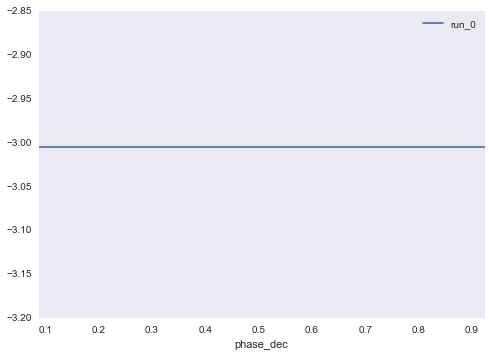

run_idx       run_0        run_1
phase_dec                       
0.087900  -3.005684    -3.005684
0.109397  -3.005684   -59.292787
0.178920  -3.005684   -39.426897
0.249192  -3.005684  -476.476479
0.254992  -3.005684  -297.683468
0.311012  -3.005684    -3.005684
0.353772  -3.005684  -158.622237
0.419211  -3.005684    -3.005684
0.437918  -3.005684    -3.005684
0.450589  -3.005684   -65.914750
0.468694  -3.005684  -118.890457
0.506115  -3.005684    -3.005684
0.697656  -3.005684    -3.005684
0.728602  -3.005684    -3.005684
0.740745  -3.005684 -1800.869152
0.838837  -3.005684 -3959.629208
0.906172  -3.005684 -1264.490119
0.917604  -3.005684 -1761.137371
0.924882  -3.005684 -2860.383290

In [263]:
df_pivot = pd.pivot_table(
    dataframes.velr, index=['phase_dec'],
    columns=['run_idx'], aggfunc=[np.median],
    values=['velr_kmps'], fill_value=0,
    margins=False, dropna='False')
df_pivot[('median', 'velr_kmps')].plot(y='run_0', secondary_y='run_1')
plt.show()
df_pivot[('median', 'velr_kmps')]

In [262]:
pd.DataFrame.plot?

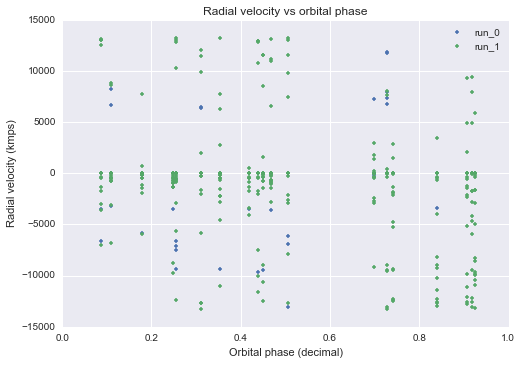

In [194]:
# TODO: Make violin plots
tfmask_run0 = (dataframes.velr['run_idx'] == 'run_0')
tfmask_run1 = (dataframes.velr['run_idx'] == 'run_1')
plt.plot(dataframes.velr.loc[tfmask_run0, 'phase_dec'],
         dataframes.velr.loc[tfmask_run0, 'velr_kmps'],
         marker='.', linestyle='', label='run_0')
plt.plot(dataframes.velr.loc[tfmask_run1, 'phase_dec'],
         dataframes.velr.loc[tfmask_run1, 'velr_kmps'],
         marker='.', linestyle='', label='run_1')
plt.title("Radial velocity vs orbital phase")
plt.xlabel("Orbital phase (decimal)")
plt.ylabel("Radial velocity (kmps)")
plt.legend()
plt.show()
#for run in dataframes.velr['run_idx'].unique():
#    tfmask_run = (dataframes.velr['run_idx'] == run)
#    for phase in dataframes.velr.loc[tfmask_run1, 'phase_dec'].unique():
#        tfmask_phase = (dataframes.velr['phase_dec'] == phase)
#        tfmask_run_phase = np.logical_and(tfmask_run, tfmask_phase)
#        sns.violinplot(
#            vals=dataframes.velr.loc[tfmask_run_phase, 'velr_kmps'],
#            position=phase)

In [202]:
print("`models.velr.all_data`: Initialize walkers.")
# Adapted from http://dan.iel.fm/emcee/current/user/line/
# TODO: Use outlier rejection from Hogg et al 2010.
models.velr = code.utils.Container()
models.velr.all_data = code.utils.Container()
for run in dataframes.velr['run_idx'].unique():
    run_attr = code.utils.Container()
    run_attr.phases = dataframes.velr.loc[tfmask_run, 'phase_dec'].values
    run_attr.velrs = dataframes.velr.loc[tfmask_run, 'velr_kmps'].values
    setattr(models.velr.all_data, run, run_attr)

`models.velr.all_data`: Initialize walkers.


In [250]:
models.velr.all_data.mcmc = code.utils.Container()
models.velr.all_data.mcmc.labels = (
    'phase_offset', 'velr_offset', 'velr0_amp', 'velr1_amp', 'velr0_sigma', 'velr1_sigma')
ndims = len(models.velr.all_data.mcmc.labels)
nwalkers = 10*ndims
nsteps = 10*nwalkers
# Initialize parameters from maximum likelihood estimate.
labels = models.velr.all_data.mcmc.labels
labels_subset = ['amp', 'sigma']
params_init = np.empty(len(labels))
params_init[0] = 0.0
params_init[1] = np.median(dataframes.velr['velr_kmps'].values)
for run in dataframes.velr['run_idx'].unique():
    tfmask_run = (dataframes.velr['run_idx'] == run)
    run_attr = getattr(models.velr.all_data, run)
    phases = run_attr.phases
    velrs = run_attr.velrs
    velr_sigma = astroML_stats.sigmaG(velrs)
    velr_amp = params_init[1] + velr_sigma
    digit = filter(str.isdigit, str(run))
    if len(digit) != 1:
        raise AssertionError(
            ("Program error. Label of run index must contain one and only one digit.\n" +
             "run = {run}").format(run=run))
    tfmask_digit = [digit in label for label in models.velr.all_data.mcmc.labels]
    for lbl in labels_subset:
        tfmask_lbl = [lbl in label for label in models.velr.all_data.mcmc.labels]
        tfmask_digit_lbl = np.logical_and(tfmask_digit, tfmask_lbl)
        labels_matched = np.asarray(models.velr.all_data.mcmc.labels)[tfmask_digit_lbl]
        if len(labels_matched) != 1:
            raise AssertionError(
                ("Program error. There must be one and only one matching parameter label\n" +
                 "for each digit-label combination.\n" +
                 "labels_matched = {lm}").format(lm=labels_matched))
        label_matched = labels_matched[0]
        if 'amp' in label_matched:
            params_init = np.where(tfmask_digit_lbl, velr_amp, params_init)
        elif 'sigma' in label_matched:
            params_init = np.where(tfmask_digit_lbl, velr_sigma, params_init)
        else:
            raise AssertionError(
                ("Program error. Only labels containing one of `labels_subset` should be replaced\n" +
                 "in `params_init`:\n" +
                 "labels = {labels}\n"
                 "labels_subset = {lbls}").format(labels=labels, lbls=labels_subset))

In [252]:
labels

('phase_offset',
 'velr_offset',
 'velr0_amp',
 'velr1_amp',
 'velr0_sigma',
 'velr1_sigma')

In [251]:
params_init

array([ 0.        , -3.00568351, -0.5515565 , -0.5515565 ,  2.45412701,
        2.45412701])

In [ ]:
    # TODO: match 0 with 0s, 1 with 1s; assign values.
params_init[1] = 0.0
params_init[3] = np.median(velr_err)
params_init = tuple(params_init)
optimize_func = lambda prms: \
    code.utils.rv_model_radial_velocities(params=tuple(prms), phases=phases) - velr
params_init2 = scipy_opt.leastsq(func=optimize_func, x0=params_init)[0]

`models.rv.gianninas.all_data`: Initialize walkers.

`models.rv`: Plot probability distribution of parameters.


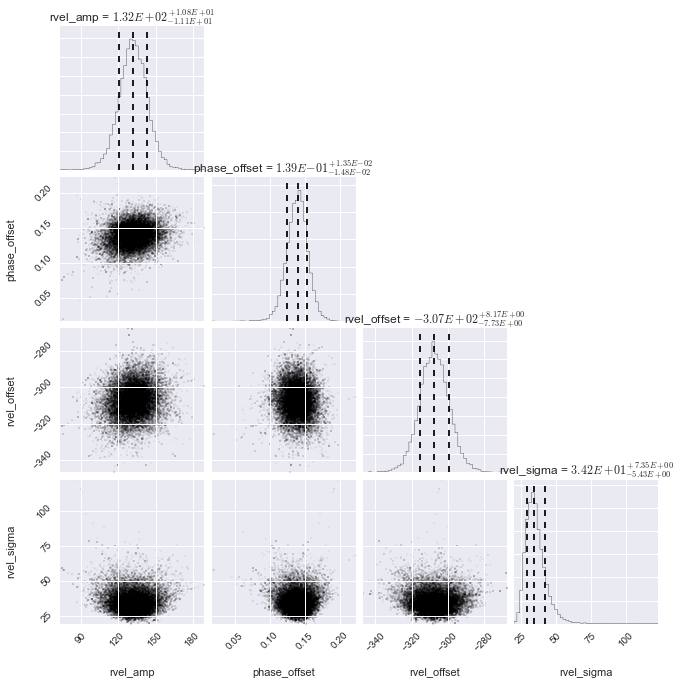


`models.rv`: Plot the random walks for each variable.


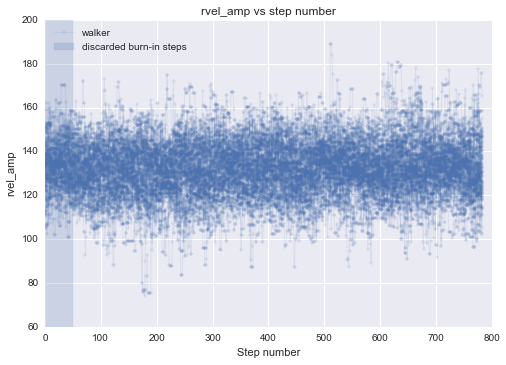

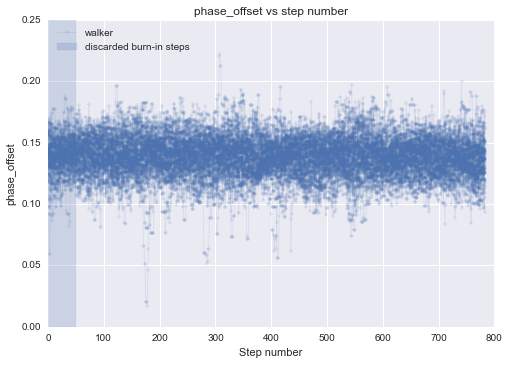

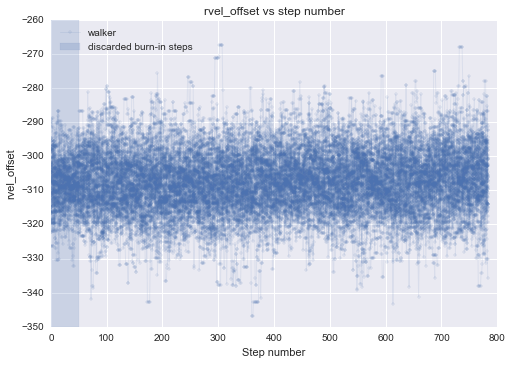

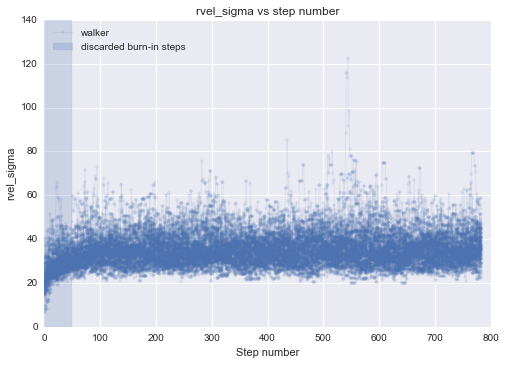

In [47]:
# Variance of initial guesses is from previous runs.
pos0_vecs = \
    [np.add(params_init2, np.multiply(params_init2, (1e-1, 1e-1, 3e-2, 3e-1))*np.random.randn(ndims))
     for _ in xrange(nwalkers)]
models.velr.all_data.mcmc.sampler = emcee.EnsembleSampler(
    nwalkers=nwalkers, dim=ndims, lnpostfn=code.utils.rv_log_posterior,
    kwargs=dict(phases=models.velr.all_data.phases, velr=models.velr.all_data.velr))
models.velr.all_data.mcmc.sampler.run_mcmc(pos0=pos0_vecs, N=nsteps)
# Discard 1*autocorrelation time as burn-in. Chosen from previous runs.
models.velr.all_data.mcmc.nburn_idx = \
    int(np.ceil(np.max(models.velr.all_data.mcmc.sampler.acor)))
# Collapse the chain along the axis of the walkers to visualize the parameter distributions.
# np.shape(trace) = ((nsteps-nburn_idx)*nwalkers, ndims)
models.velr.all_data.mcmc.trace = np.reshape(
    models.velr.all_data.mcmc.sampler.chain[:, models.velr.all_data.mcmc.nburn_idx:, :],
    newshape=(-1, ndims))
print()
print("`models.velr`: Plot probability distribution of parameters.")
# For `triangle.corner`:
# `quantiles` are left-tailed p-values (z < `quantile`) at 1 standard devation.
# `levels` are confidence levels (|z| < `level`) at 1 standard deviation.
fig = triangle.corner(
    xs=models.velr.all_data.mcmc.trace,
    labels=models.velr.all_data.mcmc.labels,
    show_titles=True, title_fmt='.2E', scale_hist=False,
    quantiles=[0.1587, 0.5, 0.8413], verbose=False,
    plot_contours=False, plot_datapoints=True,
    data_kwargs={'alpha': 0.1, 'marker': ','})
plt.show(fig)
print()
print("`models.velr`: Plot the random walks for each variable.")
for prm_idx, label in enumerate(models.velr.all_data.mcmc.labels):
    wkr_label = 'walker'
    for wkr_idx in range(len(models.velr.all_data.mcmc.sampler.chain)):
        plt.plot(models.velr.all_data.mcmc.sampler.chain[wkr_idx, :, prm_idx],
                 marker='.', linestyle='-', linewidth=1, alpha=0.1, label=wkr_label,
                 color=sns.color_palette()[0])
        wkr_label = None
    plt.axvspan(0, models.velr.all_data.mcmc.nburn_idx,
                alpha=0.2, label='discarded burn-in steps',
                color=sns.color_palette()[0])
    plt.title("{label} vs step number".format(label=label))
    plt.xlabel("Step number")
    plt.ylabel(label)
    plt.legend(loc='upper left')
    plt.show()

`models.rv.gianninas.all_data.fit`: Save parameters from the Bayesian MCMC
sine model for radial velocities and plot.
For phase variables, the variance is in the x direction.


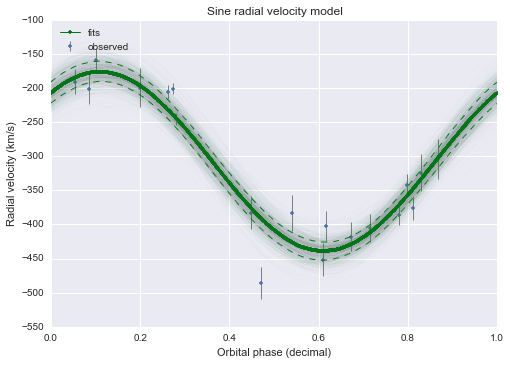


Model is only valid for the times fit:
from 2014-06-30T07:20:06.796Z to 2014-07-01T07:23:31.159Z


In [48]:
print("`models.rv.gianninas.all_data.fit`: Save parameters from the Bayesian MCMC\n" +
      "sine model for radial velocities and plot.")
print("For phase variables, the variance is in the x direction.")
# Save the -1*sigma, median, and +1*sigma values for the parameters and events.
# Percentiles are left-tailed p values (z < `percentile`) at 1 standard devation.
models.rv.gianninas.all_data.fit = code.utils.Container()
for (prm_idx, label) in enumerate(models.rv.gianninas.all_data.mcmc.labels):
    map(lambda lbl, pct: \
        setattr(models.rv.gianninas.all_data.fit, lbl, pct),
        (label+'_lwr', label, label+'_upr'),
        np.percentile(models.rv.gianninas.all_data.mcmc.trace[:, prm_idx],
                      q=[15.87, 50.0, 84.13], axis=0))
# At every phase point, plot the median and standard deviation
# of the flux values from the many light curve models.
random_traces = \
    models.rv.gianninas.all_data.mcmc.trace[
        np.random.randint(
            len(models.rv.gianninas.all_data.mcmc.trace), size=1000)]
models.rv.gianninas.all_data.fit.phases = \
    np.linspace(start=0.0, stop=1.0, num=1000, endpoint=False)
rvels_arr = \
    map(lambda prm: 
        code.utils.rv_model_radial_velocities(
            params=prm, phases=models.rv.gianninas.all_data.fit.phases),
        random_traces)
(models.rv.gianninas.all_data.fit.rvels_lwr,
 models.rv.gianninas.all_data.fit.rvels,
 models.rv.gianninas.all_data.fit.rvels_upr) = \
    np.percentile(rvels_arr,
                  q=[15.87, 50.0, 84.13], axis=0)
plt.errorbar(
    models.rv.gianninas.all_data.phases,
    models.rv.gianninas.all_data.rvels,
    models.rv.gianninas.all_data.rvels_err,
    ecolor='gray', marker='.', linestyle='', linewidth=1,
    label='observed', color=sns.color_palette()[0])
plt.plot(models.rv.gianninas.all_data.fit.phases,
         models.rv.gianninas.all_data.fit.rvels,
         marker='.', linestyle='-', label='fits', linewidth=1,
         color=sns.color_palette(name='dark')[1])
plt.plot(models.rv.gianninas.all_data.fit.phases,
         models.rv.gianninas.all_data.fit.rvels_lwr,
         marker='', linestyle='--', label=None, linewidth=1,
         color=sns.color_palette(name='dark')[1])
plt.plot(models.rv.gianninas.all_data.fit.phases,
         models.rv.gianninas.all_data.fit.rvels_upr,
         marker='', linestyle='--', label=None, linewidth=1,
         color=sns.color_palette(name='dark')[1])
for rvels in rvels_arr:
    plt.plot(models.rv.gianninas.all_data.fit.phases,
             rvels,
             marker='', linestyle='-', linewidth=1, alpha=0.01, label=None,
             color=sns.color_palette()[1])
plt.title("Sine radial velocity model")
plt.xlabel("Orbital phase (decimal)")
plt.ylabel("Radial velocity (km/s)")
plt.legend(loc='upper left')
plt.show()
print()
print(("Model is only valid for the times fit:\n"
       "from {ts_begin}Z to {ts_end}Z").format(
    ts_begin=astropy_time.Time(min(models.seg.combined.inliers2.fit.ls.times), format='unix', scale='tcb').utc.isot,
    ts_end=astropy_time.Time(max(models.seg.combined.inliers2.fit.ls.times), format='unix', scale='tcb').utc.isot))

`models.rv.gianninas.all_data`: Plot phased residuals
from sine radial velocity model.


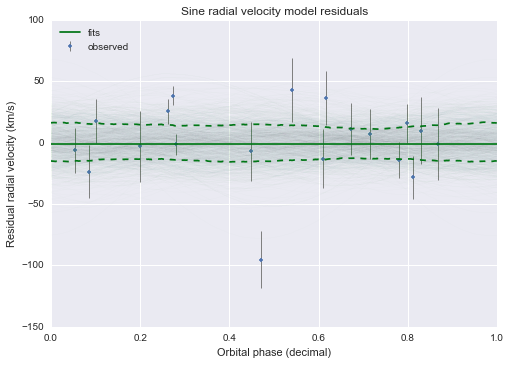

For a given phase observed between
2014-06-30T07:20:06.796 and 2014-07-01T07:23:31.159
these are the expected errors from the model.

`models.rv.gianninas.all_data`: Measure Gaussianity of residuals using rank-based statistics.

Departure from Gaussian core: number of sigma, Z1 = 0.306474101324
Departure from Gaussian tail: number of sigma, Z2 = 2.38930928703

Z1 <= 2: The model does not appear to under-fit the inlier data.
Z2 > 2: There may still be outliers in the inlier data.


In [49]:
print("`models.rv.gianninas.all_data`: Plot phased residuals\n" +
      "from sine radial velocity model.")
# TODO: make code.utils.calc_residual_fluxes generic to calc_residuals
(models.rv.gianninas.all_data.rvels_res, models.rv.gianninas.all_data.rvels_interp) = \
    code.utils.calc_residual_fluxes(
        phases=models.rv.gianninas.all_data.phases,
        fluxes=models.rv.gianninas.all_data.rvels,
        fit_phases=models.rv.gianninas.all_data.fit.phases,
        fit_fluxes=models.rv.gianninas.all_data.fit.rvels)
assert np.all(np.isclose(
        models.rv.gianninas.all_data.rvels - models.rv.gianninas.all_data.rvels_interp,
        models.rv.gianninas.all_data.rvels_res))
dataframes.rvel['rvel_res'] = models.rv.gianninas.all_data.rvels_res
dataframes.rvel['rvel_fit'] = models.rv.gianninas.all_data.rvels_interp
plt.errorbar(
    models.rv.gianninas.all_data.phases,
    models.rv.gianninas.all_data.rvels_res,
    models.rv.gianninas.all_data.rvels_err,
    ecolor='gray', marker='.', linestyle='', linewidth=1,
    label='observed', color=sns.color_palette()[0])
plt.plot(
    models.rv.gianninas.all_data.fit.phases,
    [np.median(models.rv.gianninas.all_data.rvels_res)]*len(models.rv.gianninas.all_data.fit.phases),
    marker='', linestyle='-', label='fits',
    color=sns.color_palette(name='dark')[1])
plt.plot(
    models.rv.gianninas.all_data.fit.phases,
    models.rv.gianninas.all_data.fit.rvels_upr - models.rv.gianninas.all_data.fit.rvels,
    marker='', linestyle='--', label=None,
    color=sns.color_palette(name='dark')[1])
plt.plot(
    models.rv.gianninas.all_data.fit.phases,
    models.rv.gianninas.all_data.fit.rvels_lwr - models.rv.gianninas.all_data.fit.rvels,
    marker='', linestyle='--', label=None,
    color=sns.color_palette(name='dark')[1])
for rvels in rvels_arr:
    plt.plot(
        models.rv.gianninas.all_data.fit.phases,
        rvels - models.rv.gianninas.all_data.fit.rvels,
        marker='', linestyle='-', linewidth=1, alpha=0.01,
        label=None, color=sns.color_palette()[1])
plt.title("Sine radial velocity model residuals")
plt.xlabel("Orbital phase (decimal)")
plt.ylabel("Residual radial velocity (km/s)")
plt.legend(loc='upper left')
plt.show()
print(("For a given phase observed between\n" +
       "{ts_begin} and {ts_end}\n" +
       "these are the expected errors from the model.").format(
        ts_begin=astropy_time.Time(min(models.seg.combined.inliers2.fit.ls.times), format='unix', scale='tcb').utc.isot,
        ts_end=astropy_time.Time(max(models.seg.combined.inliers2.fit.ls.times), format='unix', scale='tcb').utc.isot))
# TODO: plot expected errors as a function of time over years.
print()
print("`models.rv.gianninas.all_data`: Measure Gaussianity of residuals using rank-based statistics.")
(models.rv.gianninas.all_data.z1, models.rv.gianninas.all_data.z2) = \
    code.utils.calc_z1_z2(dist=models.rv.gianninas.all_data.rvels_res)
print()
print(("Departure from Gaussian core: number of sigma, Z1 = {z1}\n" +
       "Departure from Gaussian tail: number of sigma, Z2 = {z2}").format(
        z1=models.rv.gianninas.all_data.z1, z2=models.rv.gianninas.all_data.z2))
print()
if models.rv.gianninas.all_data.z1 > 2.0:
    print("Z1 > 2: The model may under-fit the inlier data, i.e. the model may have high bias.")
else:
    print("Z1 <= 2: The model does not appear to under-fit the inlier data.")
if models.rv.gianninas.all_data.z2 > 2.0:
    print("Z2 > 2: There may still be outliers in the inlier data.")
else:
    print("Z2 <= 2: There do not appear to be any remaining outliers in the inlier data.")

#### Check input to Binary Maker 3

In [50]:
((models.rv.gianninas.all_data.fit.rvel_amp - 
  models.rv.gianninas.all_data.fit.rvel_amp_lwr) / 
 models.rv.gianninas.all_data.fit.rvel_amp)

0.084527929766339674

In [51]:
dataframes.rvel.to_csv(
    path_or_buf=os.path.join(
        path_project, r'Work_Logs/20150216_light_curve_solution/20150708_radialvelocities_BinaryMaker3.csv'),
    columns=['phase_dec', 'vhelio_kmps'], index=False, quoting=csv.QUOTE_NONNUMERIC)

In [52]:
models.rv.gianninas.all_data.mcmc.labels

('rvel_amp', 'phase_offset', 'rvel_offset', 'rvel_sigma')

In [53]:
print(models.rv.gianninas.all_data.fit.rvel_offset)
params = (
    -132.9, # from gianninas
    models.rv.gianninas.all_data.fit.phase_offset,
    models.rv.gianninas.all_data.fit.rvel_offset,
    models.rv.gianninas.all_data.fit.rvel_sigma) 
phases = models.rv.gianninas.all_data.phases
rvels = code.utils.rv_model_radial_velocities(params=params, phases=phases)
for (phase, rvel) in zip(phases, rvels):
    print(1, phase, rvel)
params = (
    45.702716505017477, 
    models.rv.gianninas.all_data.fit.phase_offset,
    models.rv.gianninas.all_data.fit.rvel_offset,
    models.rv.gianninas.all_data.fit.rvel_sigma) 
phases = models.rv.gianninas.all_data.phases
rvels = code.utils.rv_model_radial_velocities(params=params, phases=phases)
for (phase, rvel) in zip(phases, rvels):
    print(2, phase, rvel)

-307.492555764
1 0.101050522437 -440.148145182
1 0.199140089023 -420.398206959
1 0.262438084635 -384.433361445
1 0.273869575303 -376.458374616
1 0.281216139356 -371.14278319
1 0.810970964508 -266.635996428
1 0.779607929111 -242.666720459
1 0.829091235245 -281.267737962
1 0.866505199213 -312.335403229
1 0.615382465355 -174.649962997
1 0.714159715462 -201.695373651
1 0.798296285824 -256.704867412
1 0.0533394857355 -431.852911909
1 0.0843662782254 -438.576910135
1 0.60951661389 -174.596256495
1 0.469738794193 -223.401702334
1 0.67135959666 -184.12773049
1 0.539265891141 -187.757373209
1 0.448263761029 -238.010196622
2 0.101050522437 -261.873889128
2 0.199140089023 -268.665656078
2 0.262438084635 -281.033535225
2 0.273869575303 -283.776037574
2 0.281216139356 -285.60400573
2 0.810970964508 -321.542636643
2 0.779607929111 -329.785383252
2 0.829091235245 -316.510956166
2 0.866505199213 -305.827158588
2 0.615382465355 -353.175530611
2 0.714159715462 -343.874938166
2 0.798296285824 -324.957832

In [54]:
print(models.rv.gianninas.all_data.fit.rvel_offset)
print("Now assuming Gianninas radial velocity is for smaller-radius star.")
params = (
    -45.702716505017477, # from hand solution below
    models.rv.gianninas.all_data.fit.phase_offset,
    models.rv.gianninas.all_data.fit.rvel_offset,
    models.rv.gianninas.all_data.fit.rvel_sigma) 
phases = models.rv.gianninas.all_data.phases
rvels = code.utils.rv_model_radial_velocities(params=params, phases=phases)
for (phase, rvel) in zip(phases, rvels):
    print(2, phase, rvel)

-307.492555764
Now assuming Gianninas radial velocity is for smaller-radius star.
2 0.101050522437 -353.111222401
2 0.199140089023 -346.319455451
2 0.262438084635 -333.951576304
2 0.273869575303 -331.209073955
2 0.281216139356 -329.381105798
2 0.810970964508 -293.442474886
2 0.779607929111 -285.199728276
2 0.829091235245 -298.474155362
2 0.866505199213 -309.157952941
2 0.615382465355 -261.809580918
2 0.714159715462 -271.110173363
2 0.798296285824 -290.027278693
2 0.0533394857355 -350.258591139
2 0.0843662782254 -352.570893508
2 0.60951661389 -261.791111896
2 0.469738794193 -278.574719534
2 0.67135959666 -265.068871519
2 0.539265891141 -266.31706213
2 0.448263761029 -283.598405561


### Initialize from spectra and models from Gianninas

Radial velocities and model are from Alex Gianninas, private communication, 12/2014.  
Source data: 20140630_SDSS_J160036.83+272117.8/20150129_from_Alex_Gianninas/mass_J1600.txt  
Assumed inclination angle was 90 deg for mass_J1600.txt.  

Related structures for this section:
```
quants_dict
```

In [55]:
path_project = os.path.abspath(
    r'/Users/samharrold/Google Drive/ccd.utexas/Projects/20140630_SDSS_J160036.83+272117.8')
path_gianninas = os.path.join(
    path_project, 
    r'Work_Logs/20150129_data_from_Alex_Gianninas/mass_J1600.txt')
with open(path_gianninas, 'rb') as fobj:
    models.gianninas = code.utils.read_quants_gianninas(fobj=fobj)
models.gianninas

OrderedDict([('Name', 'J1600+2721'), ('SpT', 'DA6.0'), ('Teff', 8353.0), ('errT', 126.0), ('log g', 5.244), ('errg', 0.118), ('M/Mo', 0.145), ('errM', 0.02), ('g_0', 17.245), ('errg_0', 0.021), ('M_g', 7.4), ('errMg', 0.54), ('D/kpc', 0.931), ('errD', 0.233), ('R/Ro', 0.1506), ('errR', 0.031), ('log L/Lo', -1.002), ('t_cool', 1.107), ('errtc', 0.633), ('Pd', 0.96246), ('erP', 0.04039), ('K', 132.9), ('erK', 5.1), ('aAU', 0.0158), ('errAU', 0.0012), ('aRs', 3.3979), ('errRs', 0.2624), ('M_f', 0.234), ('errMf', 0.037), ('M_2', 0.423), ('errM2', 0.064), ('M2_60', 0.568), ('erM60', 0.086), ('t_merge', 0.0), ('errtm', 0.0), ('logh', -23.26)])

In [56]:
# Units are in astronomical quantities.
# Use dict of named tuples instead of dict of dicts to prevent accidentally editing keys.
stars = ['smaller_radius', 'greater_radius']
attrs_star = ['velr_kmps', 'axis_AU', 'mass_Msun', 'radius_Rsun', 'teff_K', 'logg_dexcmps2', 'loglum_dexLsun']
attrs_syst = ['phase0_unixtime_TCB', 'period_day', 'incl_deg', 'sep_AU', 'massfunc_Msun']
quants_star = collections.namedtuple('quants_star', attrs_star)
quants_syst = collections.namedtuple('quants_syst', attrs_syst)
quants_init = {star: quants_star(**{attr: np.NaN for attr in attrs_star}) for star in stars}
quants_init['system'] = quants_syst(**{attr: np.NaN for attr in attrs_syst})
quants_init

{'greater_radius': quants_star(velr_kmps=nan, axis_AU=nan, mass_Msun=nan, radius_Rsun=nan, teff_K=nan, logg_dexcmps2=nan, loglum_dexLsun=nan),
 'smaller_radius': quants_star(velr_kmps=nan, axis_AU=nan, mass_Msun=nan, radius_Rsun=nan, teff_K=nan, logg_dexcmps2=nan, loglum_dexLsun=nan),
 'system': quants_syst(phase0_unixtime_TCB=nan, period_day=nan, incl_deg=nan, sep_AU=nan, massfunc_Msun=nan)}

In [57]:
# Use quants_dict to track changes in values with iterations.
quants_dict = {}
warnings.simplefilter('always')

In [58]:
print("Given quantities from Gianninas, infer semi-major axis, mass, radius limits.")
# NOTE:
# Parameters used from light curve fit: None
# Parameters used from Gianninas:
#   System: inclination, period, star-star separation distance, mass function
#   Smaller radius: mass
#   Greater radius: effective temperature, surface gravity, mass, radius, luminosity, radial velocity
inum = 0
quants_dict[inum] = copy.deepcopy(quants_init)
quants_dict[inum]['system'] = \
    quants_dict[inum]['system']._replace(
        incl_deg      = 90.0, # assumed inclination from Gianninas
        period_day    = models.gianninas['Pd'],
        sep_AU        = models.gianninas['aAU'],
        massfunc_Msun = models.gianninas['M_f'])
quants_dict[inum]['greater_radius'] = \
    quants_dict[inum]['greater_radius']._replace(
        teff_K         = models.gianninas['Teff'],
        logg_dexcmps2  = models.gianninas['log g'],
        mass_Msun      = models.gianninas['M/Mo'],
        radius_Rsun    = models.gianninas['R/Ro'],
        loglum_dexLsun = models.gianninas['log L/Lo'],
        velr_kmps      = models.gianninas['K'])
quants_dict[inum]['smaller_radius'] = \
    quants_dict[inum]['smaller_radius']._replace(
        mass_Msun = models.gianninas['M_2'])
# Calculated parameters.
quants_dict[inum]['greater_radius'] = \
    quants_dict[inum]['greater_radius']._replace(
        axis_AU = \
            bss.utils.calc_semimaj_axis_from_period_velr_incl(
                period=quants_dict[inum]['system'].period_day*scipy_con.day,
                velr=quants_dict[inum]['greater_radius'].velr_kmps*scipy_con.kilo,
                incl=np.deg2rad(quants_dict[inum]['system'].incl_deg)) / \
            astropy_con.au.value)
quants_dict[inum]['smaller_radius'] = \
    quants_dict[inum]['smaller_radius']._replace(
        velr_kmps = \
            bss.utils.calc_velr2_from_masses_period_incl_velr1(
                mass1=quants_dict[inum]['greater_radius'].mass_Msun*astropy_con.M_sun.value,
                mass2=quants_dict[inum]['smaller_radius'].mass_Msun*astropy_con.M_sun.value,
                velr1=quants_dict[inum]['greater_radius'].velr_kmps*scipy_con.kilo,
                period=quants_dict[inum]['system'].period_day*scipy_con.day,
                incl=np.deg2rad(quants_dict[inum]['system'].incl_deg)) / \
            scipy_con.kilo)
quants_dict[inum]['smaller_radius'] = \
    quants_dict[inum]['smaller_radius']._replace(
        axis_AU = \
            bss.utils.calc_semimaj_axis_from_period_velr_incl(
                period=quants_dict[inum]['system'].period_day*scipy_con.day,
                velr=quants_dict[inum]['smaller_radius'].velr_kmps*scipy_con.kilo,
                incl=np.deg2rad(quants_dict[inum]['system'].incl_deg)) / \
            astropy_con.au.value)
# Check that the semimajor axes are calculated consistently.
assert np.isclose(
    quants_dict[inum]['system'].sep_AU,
    (quants_dict[inum]['greater_radius'].axis_AU +
     quants_dict[inum]['smaller_radius'].axis_AU),
    rtol=1e-4) # Difference is due to rounded inputs for period, radial velocities.
# Summary
print('inum =', inum)
quants_dict[inum]

Given quantities from Gianninas, infer semi-major axis, mass, radius limits.
inum = 0


{'greater_radius': quants_star(velr_kmps=132.9, axis_AU=0.011757530992894954, mass_Msun=0.145, radius_Rsun=0.1506, teff_K=8353.0, logg_dexcmps2=5.244, loglum_dexLsun=-1.002),
 'smaller_radius': quants_star(velr_kmps=45.702716505017477, axis_AU=0.0040432739335382606, mass_Msun=0.423, radius_Rsun=nan, teff_K=nan, logg_dexcmps2=nan, loglum_dexLsun=nan),
 'system': quants_syst(phase0_unixtime_TCB=nan, period_day=0.96246, incl_deg=90.0, sep_AU=0.0158, massfunc_Msun=0.234)}

In [59]:
print("Given quantities from Gianninas, infer semi-major axis, mass, radius limits.")
# Now assuming that given radial velocity is for smaller-radius, greater-mass star.
# NOTE:
# Parameters used from light curve fit: None
# Parameters used from Gianninas:
#   System: inclination, period, star-star separation distance, mass function
#   Smaller radius: effective temperature, surface gravity, mass, radius, luminosity, radial velocity
#   Greater radius: mass
inum = 1
quants_dict[inum] = copy.deepcopy(quants_init)
quants_dict[inum]['system'] = \
    quants_dict[inum]['system']._replace(
        incl_deg      = 90.0, # assumed inclination from Gianninas
        period_day    = models.gianninas['Pd'],
        sep_AU        = models.gianninas['aAU'],
        massfunc_Msun = models.gianninas['M_f'])
quants_dict[inum]['smaller_radius'] = \
    quants_dict[inum]['smaller_radius']._replace(
        teff_K         = models.gianninas['Teff'],
        logg_dexcmps2  = models.gianninas['log g'],
        mass_Msun      = models.gianninas['M/Mo'],
        radius_Rsun    = models.gianninas['R/Ro'],
        loglum_dexLsun = models.gianninas['log L/Lo'],
        velr_kmps      = models.gianninas['K'])
quants_dict[inum]['greater_radius'] = \
    quants_dict[inum]['greater_radius']._replace(
        mass_Msun = models.gianninas['M_2'])
# Calculated parameters.
quants_dict[inum]['smaller_radius'] = \
    quants_dict[inum]['smaller_radius']._replace(
        axis_AU = \
            bss.utils.calc_semimaj_axis_from_period_velr_incl(
                period=quants_dict[inum]['system'].period_day*scipy_con.day,
                velr=quants_dict[inum]['smaller_radius'].velr_kmps*scipy_con.kilo,
                incl=np.deg2rad(quants_dict[inum]['system'].incl_deg)) / \
            astropy_con.au.value)
quants_dict[inum]['greater_radius'] = \
    quants_dict[inum]['greater_radius']._replace(
        velr_kmps = \
            bss.utils.calc_velr2_from_masses_period_incl_velr1(
                mass1=quants_dict[inum]['smaller_radius'].mass_Msun*astropy_con.M_sun.value,
                mass2=quants_dict[inum]['greater_radius'].mass_Msun*astropy_con.M_sun.value,
                velr1=quants_dict[inum]['smaller_radius'].velr_kmps*scipy_con.kilo,
                period=quants_dict[inum]['system'].period_day*scipy_con.day,
                incl=np.deg2rad(quants_dict[inum]['system'].incl_deg)) / \
            scipy_con.kilo)
quants_dict[inum]['greater_radius'] = \
    quants_dict[inum]['greater_radius']._replace(
        axis_AU = \
            bss.utils.calc_semimaj_axis_from_period_velr_incl(
                period=quants_dict[inum]['system'].period_day*scipy_con.day,
                velr=quants_dict[inum]['greater_radius'].velr_kmps*scipy_con.kilo,
                incl=np.deg2rad(quants_dict[inum]['system'].incl_deg)) / \
            astropy_con.au.value)
# Check that the semimajor axes are calculated consistently.
assert np.isclose(
    quants_dict[inum]['system'].sep_AU,
    (quants_dict[inum]['smaller_radius'].axis_AU +
     quants_dict[inum]['greater_radius'].axis_AU),
    rtol=1e-4) # Difference is due to rounded inputs for period, radial velocities.
# Summary
print('inum =', inum)
quants_dict[inum]

Given quantities from Gianninas, infer semi-major axis, mass, radius limits.
inum = 1


{'greater_radius': quants_star(velr_kmps=45.702716505017477, axis_AU=0.0040432739335382606, mass_Msun=0.423, radius_Rsun=nan, teff_K=nan, logg_dexcmps2=nan, loglum_dexLsun=nan),
 'smaller_radius': quants_star(velr_kmps=132.9, axis_AU=0.011757530992894954, mass_Msun=0.145, radius_Rsun=0.1506, teff_K=8353.0, logg_dexcmps2=5.244, loglum_dexLsun=-1.002),
 'system': quants_syst(phase0_unixtime_TCB=nan, period_day=0.96246, incl_deg=90.0, sep_AU=0.0158, massfunc_Msun=0.234)}

### Calculate possible radial velocities.

Related structures for this section:
```
```

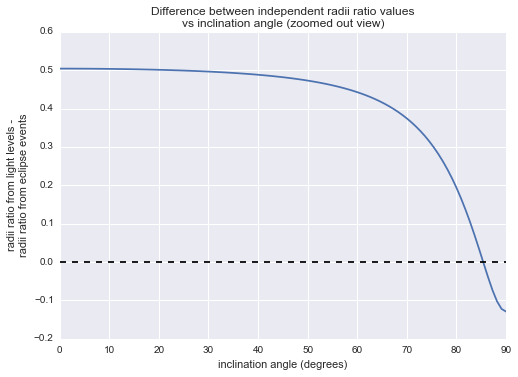

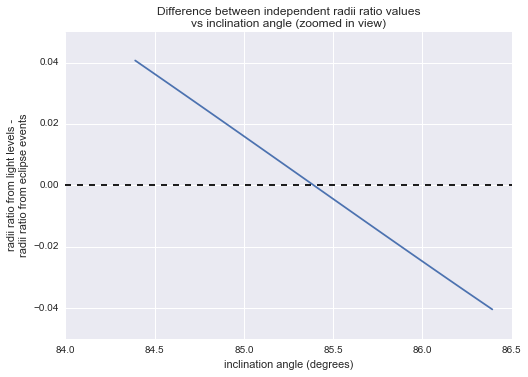

axis_s AU 0.00422880553345 ; Rsun 0.909580196646
axis_g AU 0.0122970426787 ; Rsun 2.64498956251
radius_s Rsun 0.386443869299
radius_g Rsun 0.766475240176
mass_s Msun 0.444921307389
mass_g Msun 0.153003102924
flux_rad_ratio 4.10681105679


In [60]:
# TEST: events chosen by hand.
# source light curve: SDSS_J160036.83+272117.8 2014-07-06 05_25_43_lightcurve_custom.pdf
t0 = np.mean([np.mean([3828.300, 12678.630]), np.mean([7161.542, 9115.512])])
t3 = np.mean([t0 - 7161.542, 9115.512 - t0])
t4 = np.mean([t0 - 3828.300, 12678.630 - t0])
period = models.geom.pri_as_oc.periods.fit.best_period
light_oc = models.geom.pri_as_oc.params.fit.flux_pri_eclipse
light_ref = models.geom.pri_as_oc.params.fit.flux_out_eclipse
light_tr = models.geom.pri_as_oc.params.fit.flux_sec_eclipse
phase_orb_int = bss.utils.calc_phase_orb_from_time_period(time_event=t3, period=period, time_mideclipse=0.0)
phase_orb_ext = bss.utils.calc_phase_orb_from_time_period(time_event=t4, period=period, time_mideclipse=0.0)
phase_rel_int = phase_orb_int / (2.0*np.pi)
phase_rel_ext = phase_orb_ext / (2.0*np.pi)
params = (phase_rel_int, phase_rel_ext, light_oc, light_ref, light_tr)
(flux_intg_rel_s, flux_intg_rel_g, radii_ratio_lt,
 incl_deg, radius_sep_s, radius_sep_g) = \
    code.utils.model_geometry_from_light_curve(params=params, show_plots=True)
velr_g = quants_dict[0]['greater_radius'].velr_kmps
velr_s = quants_dict[0]['smaller_radius'].velr_kmps
(axis_s, axis_g, radius_s, radius_g, mass_s, mass_g, flux_rad_ratio) = \
    code.utils.model_quants_from_velrs_lc_geoms(
        velr_s=velr_s, velr_g=velr_g, period=period,
        light_oc=light_oc, light_ref=light_ref, light_tr=light_tr,
        radius_sep_s=radius_sep_s, radius_sep_g=radius_sep_g, incl_deg=incl_deg)
print("axis_s AU", axis_s, "; Rsun", axis_s*astropy_con.au.value/astropy_con.R_sun.value)
print("axis_g AU", axis_g, "; Rsun", axis_g*astropy_con.au.value/astropy_con.R_sun.value)
print("radius_s Rsun", radius_s)
print("radius_g Rsun", radius_g)
print("mass_s Msun", mass_s)
print("mass_g Msun", mass_g)
print("flux_rad_ratio", flux_rad_ratio)

In [61]:
# TEST2: events chosen by hand. using simpler methods from Carroll and Ostlie, 2007
# source light curve: SDSS_J160036.83+272117.8 2014-07-06 05_25_43_lightcurve_custom.pdf
print("Ecplise events chosen by hand. Using simpler methods from Carroll and Ostlie, 2007.")
print("Smaller-radius star (_s).")
print("Greater-radius star (_g).")
print()
print(80*'-')
print("OBSERVED")
print()
t0 = np.mean([np.mean([3828.300, 12678.630]), np.mean([7161.542, 9115.512])])
t3 = np.mean([t0 - 7161.542, 9115.512 - t0])
t4 = np.mean([t0 - 3828.300, 12678.630 - t0])
duration_totality = 2.0*t3
duration_egress = t4 - t3
print(("Time elapsed from mid-eclipse to begin egress: t3 = {:.1f} minutes").format(t3/scipy_con.minute))
print(("Time elapsed from mid-eclipse to end egress: t4 = {:.1f} minutes").format(t4/scipy_con.minute))
print(("Duration totality: {:.1f} minutes").format(duration_totality/scipy_con.minute))
print(("Duration egress: {:.1f} minutes").format(duration_egress/scipy_con.minute))
print()
period = models.geom.pri_as_oc.periods.fit.best_period
print(("Period = {:.2f} hours").format(period/scipy_con.hour))
print()
light_oc = models.geom.pri_as_oc.params.fit.flux_pri_eclipse
light_ref = models.geom.pri_as_oc.params.fit.flux_out_eclipse
light_tr = models.geom.pri_as_oc.params.fit.flux_sec_eclipse
print(("Light levels during:\n" +
       "occultation = {oc:.2f}\n" +
       "between eclipse = {ref:.2f}\n" +
       "transit = {tr:.2f}").format(oc=light_oc, ref=light_ref, tr=light_tr))
print()
incl_rad = np.deg2rad(90.0)
print("Assumed inclination = {:.1f} deg".format(np.rad2deg(incl_rad)))
print()
velr_g = quants_dict[0]['greater_radius'].velr_kmps*scipy_con.kilo
velr_s = quants_dict[0]['smaller_radius'].velr_kmps*scipy_con.kilo
print(("Assumed radial velocities:\n" +
       "velr_g = {vg:.1f} km/s\n" +
       "velr_s = {vs:.1f} km/s").format(
        vg=velr_g/scipy_con.kilo, vs=velr_s/scipy_con.kilo))
print()
print(80*'-')
print("CALCULATED")
print()
print("Semimajor axes of stellar orbits:")
print("v = 2*pi*a/P ==> a = P*v/(2*pi)")
axis_s = period*velr_s/(2.0*np.pi)
axis_g = period*velr_g/(2.0*np.pi)
print("axis_s = {axsau:.2f} Rsun".format(axsau=axis_s/astropy_con.R_sun.value))
print("axis_g = {axgau:.2f} Rsun".format(axgau=axis_g/astropy_con.R_sun.value))
print()
print("Stellar masses:")
print("Mass ratio: m1*a1 = m2*a2 ==> m1*v1 = m2*v2 ==> m1/m2 = v2/v1")
print("Mass sum: a = a1 + a2 = (v1+v2)*P/(2*pi)")
print("    P**2 = a**3*(4*pi**2)/(G(m1+m2))")
print("    ==> m1+m2 = (v1+v2)**3 * P/(2*pi*G)")
print("Masses: m1 = m1/m2 * m2")
print("    m2 = (m1+m2) / (m1/m2 + 1)")
# m1 = mass_s, m2 = mass_g
mass_ratio = velr_g / velr_s
mass_sum = (velr_s + velr_g)**3 * period / (2.0*np.pi*scipy_con.G)
mass_g = mass_sum / (mass_ratio + 1.0)
mass_s = mass_ratio * mass_g
print("mass_s = {mssun:.2f} Msun".format(mssun=mass_s/astropy_con.M_sun.value))
print("mass_g = {mgsun:.2f} Msun".format(mgsun=mass_g/astropy_con.M_sun.value))
print()
print("Stellar radii:")
print("rs = (vs + vg)/2 * duration_egress")
print("rg = (vs + vg)/2 * (duration_totality + duration_egress)")
radius_s = duration_egress * (velr_s + velr_g)/2.0
radius_g = (duration_egress + duration_totality) * (velr_s + velr_g)/2.0
print("radius_s = {rssun:.4f} Rsun".format(rssun=radius_s/astropy_con.R_sun.value))
print("radius_g = {rgsun:.4f} Rsun".format(rgsun=radius_g/astropy_con.R_sun.value))
print()
print("Stellar radiative flux ratio:")
print("flux_rad_ratio = flux_rad_s/flux_rad_g = (light_ref-light_oc) / (light_ref-light_tr)")
flux_rad_ratio = (light_ref - light_oc) / (light_ref - light_tr)
print("flux_rad_ratio = {frr:.2f}".format(frr=flux_rad_ratio))
print()
print("Stellar effective temperature ratio:")
print("teff_ratio = teff_s/teff_g = flux_rad_ratio**0.25 = (flux_rad_s/flux_rad_g)**0.25")
teff_ratio = flux_rad_ratio**0.25
print("teff_ratio = {tr:.2f}".format(tr=teff_ratio))
print("From McDonald colors:")
teff_g = 7010.0
teff_s = teff_ratio * teff_g
print("teff_s = {ts:.0f} K".format(ts=teff_s))
print("teff_g = {tg:.0f} K".format(tg=teff_g))
print("NOTE: Calculated teff_g from Gianninas was teff_g = 8352 K")
print()
print("Surface gravities:")
print("g = G*M/R**2")
logg_s = np.log10((scipy_con.G*mass_s/(radius_s**2.0)) * scipy_con.hecto)
logg_g = np.log10((scipy_con.G*mass_g/(radius_g**2.0)) * scipy_con.hecto)
print("logg_s = {gs:.2f} dex cm/s**2".format(gs=logg_s))
print("logg_g = {gg:.2f} dex cm/s**2".format(gg=logg_g))
print("NOTE: Calculated logg_g from Gianninas was logg_g = 5.24 dex cm/s**2")
print()
print(80*'-')
print("INPUT TO BINARY MAKER")
print()
print("Star 1 = greater-mass, smaller-radius star = *_s")
print("Star 2 = smaller-mass, greater-radius star = *_g")
print()
print("Radii:")
print("    Mass Ratio = mass_2/mass_1 if teff_1 > teff_2")
print("        teff_1 = teff_s > teff_g = teff_2 is True")
print("        Mass Ratio: {:.3f}".format(mass_g/mass_s))
print("    r(1) back = radius_1/(axis_1+axis_2) = radius_s/(axis_s+axis_g)")
print("        r(1) back: {:.3f}".format(radius_s/(axis_s+axis_g)))
print("    r(2) back = radius_2/(axis_1+axis_2) = radius_g/(axis_s+axis_g)")
print("        r(2) back: {:.3f}".format(radius_g/(axis_s+axis_g)))
print()
print("Temperature:")
print("    Wavelength = light curve data is combination of BG40 and V")
print("        Wavelength: 5000")
print("    Temperature 1: {:.0f}".format(teff_s))
print("    Temperature 2: {:.0f}".format(teff_g))

Ecplise events chosen by hand. Using simpler methods from Carroll and Ostlie, 2007.
Smaller-radius star (_s).
Greater-radius star (_g).

--------------------------------------------------------------------------------
OBSERVED

Time elapsed from mid-eclipse to begin egress: t3 = 16.3 minutes
Time elapsed from mid-eclipse to end egress: t4 = 73.8 minutes
Duration totality: 32.6 minutes
Duration egress: 57.5 minutes

Period = 24.08 hours

Light levels during:
occultation = 0.49
between eclipse = 1.00
transit = 0.88

Assumed inclination = 90.0 deg

Assumed radial velocities:
velr_g = 132.9 km/s
velr_s = 45.7 km/s

--------------------------------------------------------------------------------
CALCULATED

Semimajor axes of stellar orbits:
v = 2*pi*a/P ==> a = P*v/(2*pi)
axis_s = 0.91 Rsun
axis_g = 2.64 Rsun

Stellar masses:
Mass ratio: m1*a1 = m2*a2 ==> m1*v1 = m2*v2 ==> m1/m2 = v2/v1
Mass sum: a = a1 + a2 = (v1+v2)*P/(2*pi)
    P**2 = a**3*(4*pi**2)/(G(m1+m2))
    ==> m1+m2 = (v1+v2)**3 

In [88]:
models.geom.pri_as_oc.params.labels

('phase_rel_int',
 'phase_rel_ext',
 'flux_pri_eclipse',
 'flux_out_eclipse',
 'flux_sec_eclipse')

In [89]:
models.geom.pri_as_oc.geoms.labels

('flux_intg_rel_s',
 'flux_intg_rel_g',
 'radii_ratio_lt',
 'incl_deg',
 'radius_sep_s',
 'radius_sep_g')

In [92]:
astropy_con.R_sun.value / astropy_con.au.value

0.004649183820234682

In [87]:
# TEST2.1: events chosen by hand. using simpler methods from Carroll and Ostlie, 2007
# source light curve: SDSS_J160036.83+272117.8 2014-07-06 05_25_43_lightcurve_custom.pdf
# Check 1 solar radii for 132.9kmps
print("Ecplise events chosen by hand. Using simpler methods from Carroll and Ostlie, 2007.")
print("Smaller-radius star (_s).")
print("Greater-radius star (_g).")
print()
print(80*'-')
print("OBSERVED")
print()
t0 = np.mean([np.mean([3828.300, 12678.630]), np.mean([7161.542, 9115.512])])
t3 = np.mean([t0 - 7161.542, 9115.512 - t0])
t4 = np.mean([t0 - 3828.300, 12678.630 - t0])
duration_totality = 2.0*t3
duration_egress = t4 - t3
print(("Time elapsed from mid-eclipse to begin egress: t3 = {:.1f} minutes").format(t3/scipy_con.minute))
print(("Time elapsed from mid-eclipse to end egress: t4 = {:.1f} minutes").format(t4/scipy_con.minute))
print(("Duration totality: {:.1f} minutes").format(duration_totality/scipy_con.minute))
print(("Duration egress: {:.1f} minutes").format(duration_egress/scipy_con.minute))
print()
period = 24.0*scipy_con.hour
print(("Period = {:.2f} hours").format(period/scipy_con.hour))
print()
light_oc = models.geom.pri_as_oc.params.fit.flux_pri_eclipse
light_ref = models.geom.pri_as_oc.params.fit.flux_out_eclipse
light_tr = models.geom.pri_as_oc.params.fit.flux_sec_eclipse
print(("Light levels during:\n" +
       "occultation = {oc:.2f}\n" +
       "between eclipse = {ref:.2f}\n" +
       "transit = {tr:.2f}").format(oc=light_oc, ref=light_ref, tr=light_tr))
print()
incl_rad = np.deg2rad(90.0)
print("Assumed inclination = {:.1f} deg".format(np.rad2deg(incl_rad)))
print()
velr_g = 132.9*scipy_con.kilo
velr_s = 132.9*scipy_con.kilo
print(("Assumed radial velocities:\n" +
       "velr_g = {vg:.1f} km/s\n" +
       "velr_s = {vs:.1f} km/s").format(
        vg=velr_g/scipy_con.kilo, vs=velr_s/scipy_con.kilo))
print()
print(80*'-')
print("CALCULATED")
print()
print("Semimajor axes of stellar orbits:")
print("v = 2*pi*a/P ==> a = P*v/(2*pi)")
axis_s = period*velr_s/(2.0*np.pi)
axis_g = period*velr_g/(2.0*np.pi)
print("axis_s = {axsau:.2f} Rsun".format(axsau=axis_s/astropy_con.R_sun.value))
print("axis_g = {axgau:.2f} Rsun".format(axgau=axis_g/astropy_con.R_sun.value))
print()
print("Stellar masses:")
print("Mass ratio: m1*a1 = m2*a2 ==> m1*v1 = m2*v2 ==> m1/m2 = v2/v1")
print("Mass sum: a = a1 + a2 = (v1+v2)*P/(2*pi)")
print("    P**2 = a**3*(4*pi**2)/(G(m1+m2))")
print("    ==> m1+m2 = (v1+v2)**3 * P/(2*pi*G)")
print("Masses: m1 = m1/m2 * m2")
print("    m2 = (m1+m2) / (m1/m2 + 1)")
# m1 = mass_s, m2 = mass_g
mass_ratio = velr_g / velr_s
mass_sum = (velr_s + velr_g)**3 * period / (2.0*np.pi*scipy_con.G)
mass_g = mass_sum / (mass_ratio + 1.0)
mass_s = mass_ratio * mass_g
print("mass_s = {mssun:.2f} Msun".format(mssun=mass_s/astropy_con.M_sun.value))
print("mass_g = {mgsun:.2f} Msun".format(mgsun=mass_g/astropy_con.M_sun.value))
print()
print("Stellar radii:")
print("rs = (vs + vg)/2 * duration_egress")
print("rg = (vs + vg)/2 * (duration_totality + duration_egress)")
radius_s = duration_egress * (velr_s + velr_g)/2.0
radius_g = (duration_egress + duration_totality) * (velr_s + velr_g)/2.0
print("radius_s = {rssun:.4f} Rsun".format(rssun=radius_s/astropy_con.R_sun.value))
print("radius_g = {rgsun:.4f} Rsun".format(rgsun=radius_g/astropy_con.R_sun.value))
print()
print("Stellar radiative flux ratio:")
print("flux_rad_ratio = flux_rad_s/flux_rad_g = (light_ref-light_oc) / (light_ref-light_tr)")
flux_rad_ratio = (light_ref - light_oc) / (light_ref - light_tr)
print("flux_rad_ratio = {frr:.2f}".format(frr=flux_rad_ratio))
print()
print("Stellar effective temperature ratio:")
print("teff_ratio = teff_s/teff_g = flux_rad_ratio**0.25 = (flux_rad_s/flux_rad_g)**0.25")
teff_ratio = flux_rad_ratio**0.25
print("teff_ratio = {tr:.2f}".format(tr=teff_ratio))
print("From McDonald colors:")
teff_g = 7010.0
teff_s = teff_ratio * teff_g
print("teff_s = {ts:.0f} K".format(ts=teff_s))
print("teff_g = {tg:.0f} K".format(tg=teff_g))
print("NOTE: Calculated teff_g from Gianninas was teff_g = 8352 K")
print()
print("Surface gravities:")
print("g = G*M/R**2")
logg_s = np.log10((scipy_con.G*mass_s/(radius_s**2.0)) * scipy_con.hecto)
logg_g = np.log10((scipy_con.G*mass_g/(radius_g**2.0)) * scipy_con.hecto)
print("logg_s = {gs:.2f} dex cm/s**2".format(gs=logg_s))
print("logg_g = {gg:.2f} dex cm/s**2".format(gg=logg_g))
print("NOTE: Calculated logg_g from Gianninas was logg_g = 5.24 dex cm/s**2")
print()
print(80*'-')
print("INPUT TO BINARY MAKER")
print()
print("Star 1 = greater-mass, smaller-radius star = *_s")
print("Star 2 = smaller-mass, greater-radius star = *_g")
print()
print("Radii:")
print("    Mass Ratio = mass_2/mass_1 if teff_1 > teff_2")
print("        teff_1 = teff_s > teff_g = teff_2 is True")
print("        Mass Ratio: {:.3f}".format(mass_g/mass_s))
print("    r(1) back = radius_1/(axis_1+axis_2) = radius_s/(axis_s+axis_g)")
print("        r(1) back: {:.3f}".format(radius_s/(axis_s+axis_g)))
print("    r(2) back = radius_2/(axis_1+axis_2) = radius_g/(axis_s+axis_g)")
print("        r(2) back: {:.3f}".format(radius_g/(axis_s+axis_g)))
print()
print("Temperature:")
print("    Wavelength = light curve data is combination of BG40 and V")
print("        Wavelength: 5000")
print("    Temperature 1: {:.0f}".format(teff_s))
print("    Temperature 2: {:.0f}".format(teff_g))

Ecplise events chosen by hand. Using simpler methods from Carroll and Ostlie, 2007.
Smaller-radius star (_s).
Greater-radius star (_g).

--------------------------------------------------------------------------------
OBSERVED

Time elapsed from mid-eclipse to begin egress: t3 = 16.3 minutes
Time elapsed from mid-eclipse to end egress: t4 = 73.8 minutes
Duration totality: 32.6 minutes
Duration egress: 57.5 minutes

Period = 24.00 hours

Light levels during:
occultation = 0.49
between eclipse = 1.00
transit = 0.88

Assumed inclination = 90.0 deg

Assumed radial velocities:
velr_g = 132.9 km/s
velr_s = 132.9 km/s

--------------------------------------------------------------------------------
CALCULATED

Semimajor axes of stellar orbits:
v = 2*pi*a/P ==> a = P*v/(2*pi)
axis_s = 2.63 Rsun
axis_g = 2.63 Rsun

Stellar masses:
Mass ratio: m1*a1 = m2*a2 ==> m1*v1 = m2*v2 ==> m1/m2 = v2/v1
Mass sum: a = a1 + a2 = (v1+v2)*P/(2*pi)
    P**2 = a**3*(4*pi**2)/(G(m1+m2))
    ==> m1+m2 = (v1+v2)**3

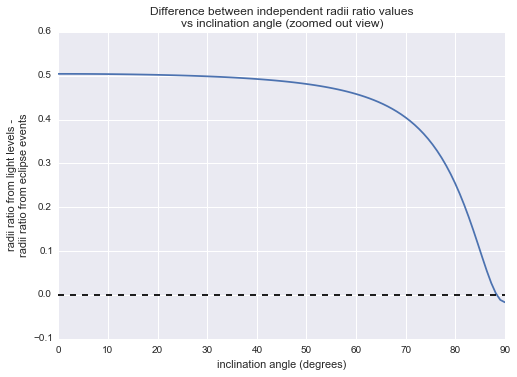

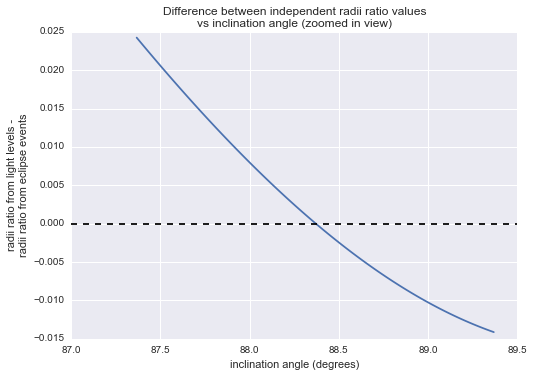

axis_s AU 0.00421684167645 ; Rsun 0.907006872497
axis_g AU 0.0122622526987 ; Rsun 2.63750653293
radius_s Rsun 0.329768222953
radius_g Rsun 0.654150786172
mass_s Msun 0.441155754931
mass_g Msun 0.151708174584
flux_rad_ratio 4.10681105679
teff_ratio = 1.42
From McDonald colors:
teff_s = 9979 K
teff_g = 7010 K
NOTE: Calculated teff_g from Gianninas was teff_g = 8352 K
logg_s = 5.05 dex cm/s**2
logg_g = 3.99 dex cm/s**2
NOTE: Calculated logg_g from Gianninas was logg_g = 5.24 dex cm/s**2

--------------------------------------------------------------------------------
INPUT TO BINARY MAKER

Star 1 = greater-mass, smaller-radius star = *_s
Star 2 = smaller-mass, greater-radius star = *_g

Radii:
    Mass Ratio = mass_2/mass_1 if teff_1 > teff_2
        teff_1 = teff_s > teff_g = teff_2 is True
        Mass Ratio: 0.344
    r(1) back = radius_1/(axis_1+axis_2) = radius_s/(axis_s+axis_g)
        r(1) back: 0.093
    r(2) back = radius_2/(axis_1+axis_2) = radius_g/(axis_s+axis_g)
        r(2) 

In [62]:
# TEST: events from mcmc.
period = models.geom.pri_as_oc.periods.fit.best_period
light_oc = models.geom.pri_as_oc.params.fit.flux_pri_eclipse
light_ref = models.geom.pri_as_oc.params.fit.flux_out_eclipse
light_tr = models.geom.pri_as_oc.params.fit.flux_sec_eclipse
phase_rel_int = models.geom.pri_as_oc.params.fit.phase_rel_int
phase_rel_ext = models.geom.pri_as_oc.params.fit.phase_rel_ext
params = (phase_rel_int, phase_rel_ext, light_oc, light_ref, light_tr)
(flux_intg_rel_s, flux_intg_rel_g, radii_ratio_lt,
 incl_deg, radius_sep_s, radius_sep_g) = \
    code.utils.model_geometry_from_light_curve(params=params, show_plots=True)
velr_g = quants_dict[0]['greater_radius'].velr_kmps
velr_s = quants_dict[0]['smaller_radius'].velr_kmps
(axis_s, axis_g, radius_s, radius_g, mass_s, mass_g, flux_rad_ratio) = \
    code.utils.model_quants_from_velrs_lc_geoms(
        velr_s=velr_s, velr_g=velr_g, period=period,
        light_oc=light_oc, light_ref=light_ref, light_tr=light_tr,
        radius_sep_s=radius_sep_s, radius_sep_g=radius_sep_g, incl_deg=incl_deg)
print("axis_s AU", axis_s, "; Rsun", axis_s*astropy_con.au.value/astropy_con.R_sun.value)
print("axis_g AU", axis_g, "; Rsun", axis_g*astropy_con.au.value/astropy_con.R_sun.value)
print("radius_s Rsun", radius_s)
print("radius_g Rsun", radius_g)
print("mass_s Msun", mass_s)
print("mass_g Msun", mass_g)
print("flux_rad_ratio", flux_rad_ratio)
teff_ratio = bss.utils.calc_teff_ratio_from_flux_rad_ratio(flux_rad_ratio=flux_rad_ratio)
print("teff_ratio = {tr:.2f}".format(tr=teff_ratio))
print("From McDonald colors:")
teff_g = 7010.0
teff_s = teff_ratio * teff_g
print("teff_s = {ts:.0f} K".format(ts=teff_s))
print("teff_g = {tg:.0f} K".format(tg=teff_g))
print("NOTE: Calculated teff_g from Gianninas was teff_g = 8352 K")
logg_s = bss.utils.calc_logg_from_mass_radius(mass=mass_s*astropy_con.M_sun.value,
                                              radius=radius_s*astropy_con.R_sun.value)
logg_g = bss.utils.calc_logg_from_mass_radius(mass=mass_g*astropy_con.M_sun.value,
                                              radius=radius_g*astropy_con.R_sun.value)
print("logg_s = {gs:.2f} dex cm/s**2".format(gs=logg_s))
print("logg_g = {gg:.2f} dex cm/s**2".format(gg=logg_g))
print("NOTE: Calculated logg_g from Gianninas was logg_g = 5.24 dex cm/s**2")
print()
print(80*'-')
print("INPUT TO BINARY MAKER")
print()
print("Star 1 = greater-mass, smaller-radius star = *_s")
print("Star 2 = smaller-mass, greater-radius star = *_g")
print()
print("Radii:")
print("    Mass Ratio = mass_2/mass_1 if teff_1 > teff_2")
print("        teff_1 = teff_s > teff_g = teff_2 is True")
print("        Mass Ratio: {:.3f}".format(mass_g/mass_s))
print("    r(1) back = radius_1/(axis_1+axis_2) = radius_s/(axis_s+axis_g)")
print("        r(1) back: {:.3f}".format(radius_s*astropy_con.R_sun.value/((axis_s+axis_g)*astropy_con.au.value)))
print("    r(2) back = radius_2/(axis_1+axis_2) = radius_g/(axis_s+axis_g)")
print("        r(2) back: {:.3f}".format(radius_g*astropy_con.R_sun.value/((axis_s+axis_g)*astropy_con.au.value)))
print()
print("Temperature:")
print("    Wavelength = light curve data is combination of BG40 and V")
print("        Wavelength: 5000")
print("    Temperature 1: {:.0f}".format(teff_s))
print("    Temperature 2: {:.0f}".format(teff_g))

Now assuming radial velocity is for smaller-radius star.


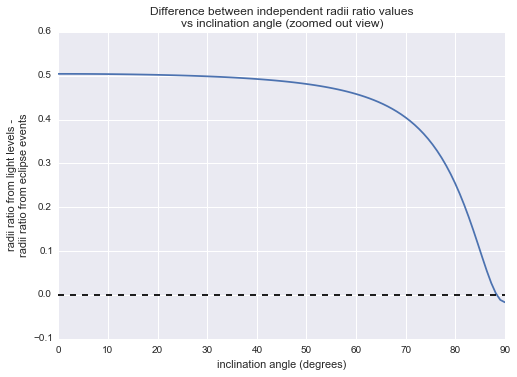

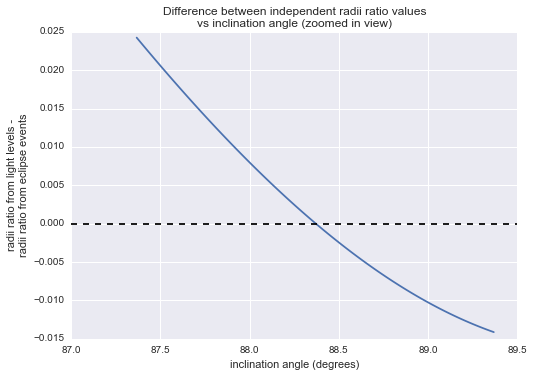

axis_s AU 0.0122622526987 ; Rsun 2.63750653293
axis_g AU 0.00421684167645 ; Rsun 0.907006872497
radius_s Rsun 0.329768222953
radius_g Rsun 0.654150786172
mass_s Msun 0.151708174584
mass_g Msun 0.441155754931
flux_rad_ratio 4.10681105679
teff_ratio = 1.42
From McDonald colors:
teff_s = 9979 K
teff_g = 7010 K
NOTE: Calculated teff_g from Gianninas was teff_g = 8352 K
logg_s = 4.58 dex cm/s**2
logg_g = 4.45 dex cm/s**2
NOTE: Calculated logg_g from Gianninas was logg_g = 5.24 dex cm/s**2

--------------------------------------------------------------------------------
INPUT TO BINARY MAKER

Star 1 = greater-mass, greater-radius star = *_g
Star 2 = smaller-mass, smaller-radius star = *_s

Radii:
    Mass Ratio = mass_2/mass_1 if teff_1 > teff_2
        teff_1 = teff_g < teff_s = teff_2, so Mass Ratio = mass1/mass2
        Mass Ratio: 2.908
    r(1) back = radius_1/(axis_1+axis_2) = radius_g/(axis_s+axis_g)
        r(1) back: 0.185
    r(2) back = radius_2/(axis_1+axis_2) = radius_s/(axis_s+

In [63]:
# TEST: events from mcmc.
print("Now assuming radial velocity is for smaller-radius star.")
period = models.geom.pri_as_oc.periods.fit.best_period
light_oc = models.geom.pri_as_oc.params.fit.flux_pri_eclipse
light_ref = models.geom.pri_as_oc.params.fit.flux_out_eclipse
light_tr = models.geom.pri_as_oc.params.fit.flux_sec_eclipse
phase_rel_int = models.geom.pri_as_oc.params.fit.phase_rel_int
phase_rel_ext = models.geom.pri_as_oc.params.fit.phase_rel_ext
params = (phase_rel_int, phase_rel_ext, light_oc, light_ref, light_tr)
(flux_intg_rel_s, flux_intg_rel_g, radii_ratio_lt,
 incl_deg, radius_sep_s, radius_sep_g) = \
    code.utils.model_geometry_from_light_curve(params=params, show_plots=True)
velr_g = quants_dict[1]['greater_radius'].velr_kmps
velr_s = quants_dict[1]['smaller_radius'].velr_kmps
(axis_s, axis_g, radius_s, radius_g, mass_s, mass_g, flux_rad_ratio) = \
    code.utils.model_quants_from_velrs_lc_geoms(
        velr_s=velr_s, velr_g=velr_g, period=period,
        light_oc=light_oc, light_ref=light_ref, light_tr=light_tr,
        radius_sep_s=radius_sep_s, radius_sep_g=radius_sep_g, incl_deg=incl_deg)
print("axis_s AU", axis_s, "; Rsun", axis_s*astropy_con.au.value/astropy_con.R_sun.value)
print("axis_g AU", axis_g, "; Rsun", axis_g*astropy_con.au.value/astropy_con.R_sun.value)
print("radius_s Rsun", radius_s)
print("radius_g Rsun", radius_g)
print("mass_s Msun", mass_s)
print("mass_g Msun", mass_g)
print("flux_rad_ratio", flux_rad_ratio)
teff_ratio = bss.utils.calc_teff_ratio_from_flux_rad_ratio(flux_rad_ratio=flux_rad_ratio)
print("teff_ratio = {tr:.2f}".format(tr=teff_ratio))
print("From McDonald colors:")
teff_g = 7010.0
teff_s = teff_ratio * teff_g
print("teff_s = {ts:.0f} K".format(ts=teff_s))
print("teff_g = {tg:.0f} K".format(tg=teff_g))
print("NOTE: Calculated teff_g from Gianninas was teff_g = 8352 K")
logg_s = bss.utils.calc_logg_from_mass_radius(mass=mass_s*astropy_con.M_sun.value,
                                              radius=radius_s*astropy_con.R_sun.value)
logg_g = bss.utils.calc_logg_from_mass_radius(mass=mass_g*astropy_con.M_sun.value,
                                              radius=radius_g*astropy_con.R_sun.value)
print("logg_s = {gs:.2f} dex cm/s**2".format(gs=logg_s))
print("logg_g = {gg:.2f} dex cm/s**2".format(gg=logg_g))
print("NOTE: Calculated logg_g from Gianninas was logg_g = 5.24 dex cm/s**2")
print()
print(80*'-')
print("INPUT TO BINARY MAKER")
print()
print("Star 1 = greater-mass, greater-radius star = *_g")
print("Star 2 = smaller-mass, smaller-radius star = *_s")
print()
print("Radii:")
print("    Mass Ratio = mass_2/mass_1 if teff_1 > teff_2")
print("        teff_1 = teff_g < teff_s = teff_2, so Mass Ratio = mass1/mass2")
print("        Mass Ratio: {:.3f}".format(mass_g/mass_s))
print("    r(1) back = radius_1/(axis_1+axis_2) = radius_g/(axis_s+axis_g)")
print("        r(1) back: {:.3f}".format(radius_g*astropy_con.R_sun.value/((axis_s+axis_g)*astropy_con.au.value)))
print("    r(2) back = radius_2/(axis_1+axis_2) = radius_s/(axis_s+axis_g)")
print("        r(2) back: {:.3f}".format(radius_s*astropy_con.R_sun.value/((axis_s+axis_g)*astropy_con.au.value)))
print()
print("Temperature:")
print("    Wavelength = light curve data is combination of BG40 and V")
print("        Wavelength: 5000")
print("    Temperature 1: {:.0f}".format(teff_g))
print("    Temperature 2: {:.0f}".format(teff_s))

## Calculate quantities as a function of velr

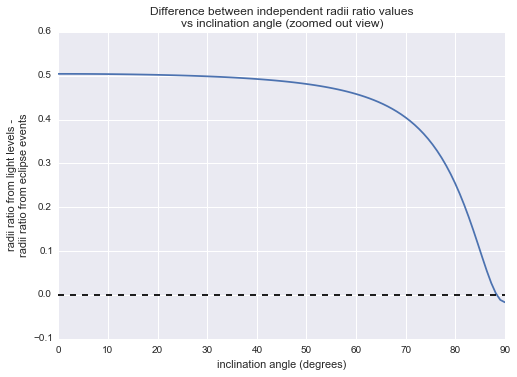

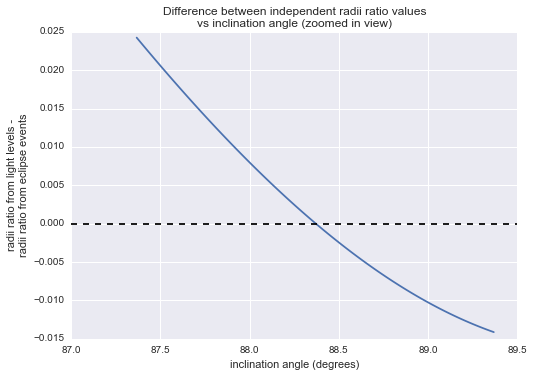


--------------------------------------------------------------------------------
quants_arr = (axis_s, axis_g, radius_s, radius_g, mass_s, mass_g, flux_rad_ratio)
velr_g = 132.9


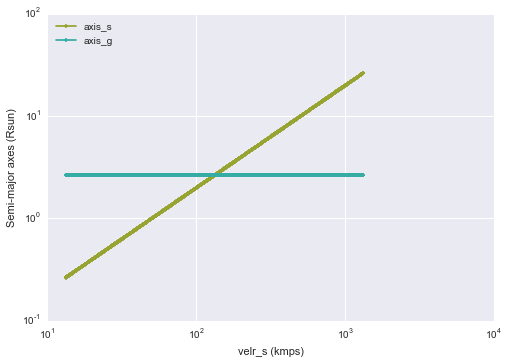

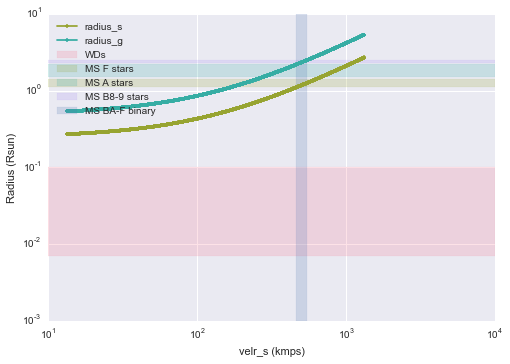

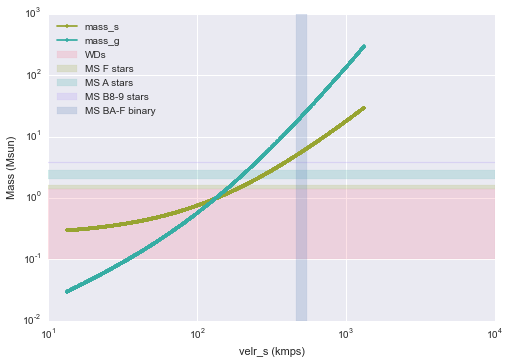

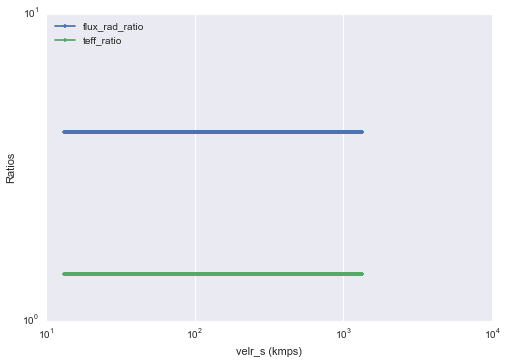

In [85]:
# TEST: events from mcmc.
# Assume 132.9 kmps for LARGER radius
period = models.geom.pri_as_oc.periods.fit.best_period
light_oc = models.geom.pri_as_oc.params.fit.flux_pri_eclipse
light_ref = models.geom.pri_as_oc.params.fit.flux_out_eclipse
light_tr = models.geom.pri_as_oc.params.fit.flux_sec_eclipse
phase_rel_int = models.geom.pri_as_oc.params.fit.phase_rel_int
phase_rel_ext = models.geom.pri_as_oc.params.fit.phase_rel_ext
params = (phase_rel_int, phase_rel_ext, light_oc, light_ref, light_tr)
(flux_intg_rel_s, flux_intg_rel_g, radii_ratio_lt,
 incl_deg, radius_sep_s, radius_sep_g) = \
    code.utils.model_geometry_from_light_curve(params=params, show_plots=True)
velrs_g = [quants_dict[0]['greater_radius'].velr_kmps]
colors = sns.husl_palette(n_colors=4)
# NOTE: Radii and masses from Carroll and Ostlie, Appendix G.
# Spectral type constraints from Carroll and Ostlie, Ch 8.
for velr_g in velrs_g:
    velrs_s = np.logspace(start=np.log10(velr_g)-1, stop=np.log10(velr_g)+1, num=1000, endpoint=True)
    quants_arr = list()
    for velr_s in velrs_s:
        quants_arr.append(
            code.utils.model_quants_from_velrs_lc_geoms(
                velr_s=velr_s, velr_g=velr_g, period=period,
                light_oc=light_oc, light_ref=light_ref, light_tr=light_tr,
                radius_sep_s=radius_sep_s, radius_sep_g=radius_sep_g, incl_deg=incl_deg))
    quants_arr = np.asarray(quants_arr)
    print()
    print(80*'-')
    print("quants_arr = (axis_s, axis_g, radius_s, radius_g, mass_s, mass_g, flux_rad_ratio)")
    print("velr_g =", velr_g)
    plt.plot(velrs_s, quants_arr[:, 0]*astropy_con.au.value/astropy_con.R_sun.value, label='axis_s',
             color=colors[1], marker='.')
    plt.plot(velrs_s, quants_arr[:, 1]*astropy_con.au.value/astropy_con.R_sun.value, label='axis_g',
             color=colors[2], marker='.')
    plt.xlabel('velr_s (kmps)')
    plt.ylabel("Semi-major axes (Rsun)")
    plt.xscale('log')
    plt.yscale('log')
    plt.legend(loc='upper left')
    plt.show()
    plt.plot(velrs_s, quants_arr[:, 2], label='radius_s', color=colors[1], marker='.')
    plt.plot(velrs_s, quants_arr[:, 3], label='radius_g', color=colors[2], marker='.')
    plt.axhspan(0.007, 0.1, label='WDs', alpha=0.2, color=colors[0])
    plt.axhspan(1.1, 1.4, label='MS F stars', alpha=0.2, color=colors[1])
    plt.axhspan(1.5, 2.2, label='MS A stars', alpha=0.2, color=colors[2])
    plt.axhspan(2.3, 2.5, label='MS B8-9 stars', alpha=0.2, color=colors[3])
    tfmask_fstars = np.logical_and(1.1 <= quants_arr[:, 2], quants_arr[:, 2] <= 1.4)
    tfmask_bastars = np.logical_and(1.5 <= quants_arr[:, 3], quants_arr[:, 3] <= 2.5)
    tfmask_bafstars = np.logical_and(tfmask_fstars, tfmask_bastars)
    velrs_s_bafstars = velrs_s[tfmask_bafstars]
    plt.axvspan(min(velrs_s_bafstars), max(velrs_s_bafstars), label='MS BA-F binary',
                alpha=0.2, color=sns.color_palette()[0])
    plt.xlabel('velr_s (kmps)')
    plt.ylabel("Radius (Rsun)")
    plt.xscale('log')
    plt.yscale('log')
    plt.legend(loc='upper left')
    plt.show()
    plt.plot(velrs_s, quants_arr[:, 4], label='mass_s', color=colors[1], marker='.')
    plt.plot(velrs_s, quants_arr[:, 5], label='mass_g', color=colors[2], marker='.')
    plt.axhspan(0.1, 1.4, label='WDs', alpha=0.2, color=colors[0])
    plt.axhspan(1.4, 1.6, label='MS F stars', alpha=0.2, color=colors[1])
    plt.axhspan(2.0, 2.9, label='MS A stars', alpha=0.2, color=colors[2])
    plt.axhspan(3.7, 3.8, label='MS B8-9 stars', alpha=0.2, color=colors[3])
    plt.axvspan(min(velrs_s_bafstars), max(velrs_s_bafstars), label='MS BA-F binary',
                alpha=0.2, color=sns.color_palette()[0])
    plt.xlabel('velr_s (kmps)')
    plt.ylabel("Mass (Msun)")
    plt.xscale('log')
    plt.yscale('log')
    plt.legend(loc='upper left')
    plt.show()
    plt.plot(velrs_s, quants_arr[:, 6], label='flux_rad_ratio', marker='.')
    plt.plot(velrs_s, bss.utils.calc_teff_ratio_from_flux_rad_ratio(quants_arr[:, 6]), label='teff_ratio', marker='.')
    plt.xlabel('velr_s (kmps)')
    plt.ylabel("Ratios")
    plt.xscale('log')
    plt.yscale('log')
    plt.legend(loc='upper left')
    plt.show()

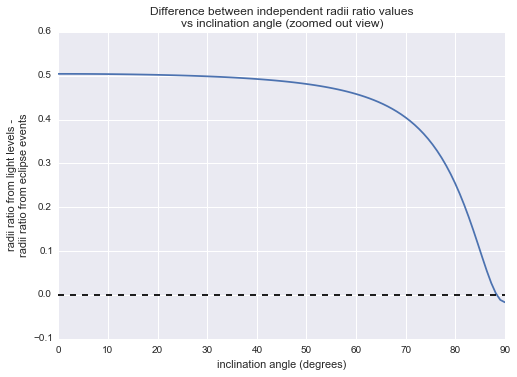

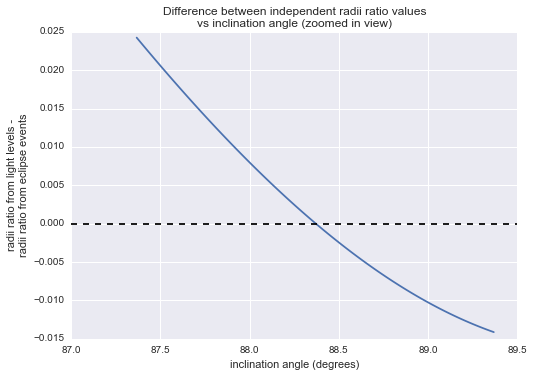


--------------------------------------------------------------------------------
quants_arr = (axis_s, axis_g, radius_s, radius_g, mass_s, mass_g, flux_rad_ratio)
velr_s = 132.9


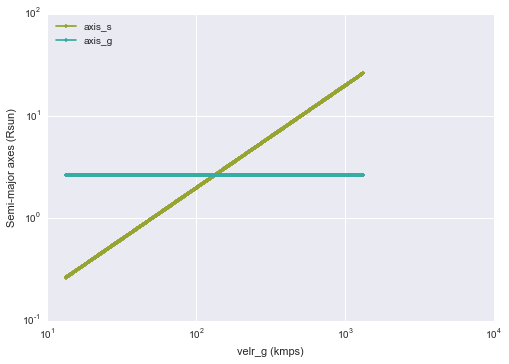

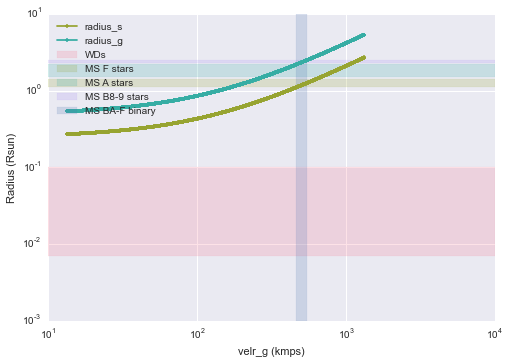

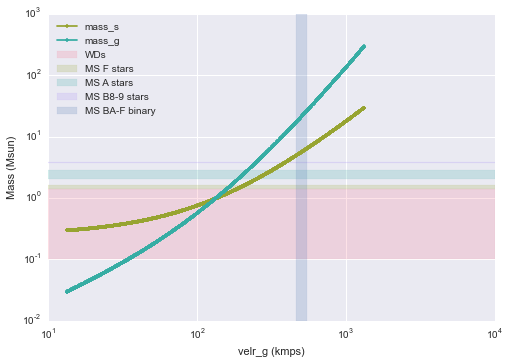

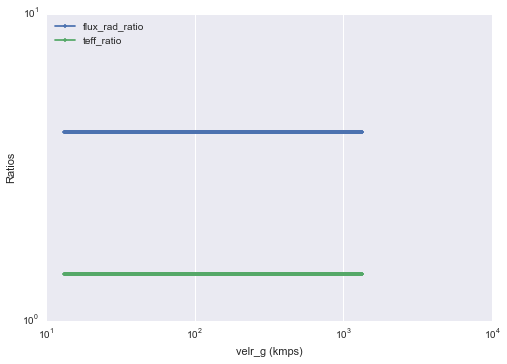

In [94]:
# TEST: events from mcmc.
# Assume 132.9 kmps for smaller radius
period = models.geom.pri_as_oc.periods.fit.best_period
light_oc = models.geom.pri_as_oc.params.fit.flux_pri_eclipse
light_ref = models.geom.pri_as_oc.params.fit.flux_out_eclipse
light_tr = models.geom.pri_as_oc.params.fit.flux_sec_eclipse
phase_rel_int = models.geom.pri_as_oc.params.fit.phase_rel_int
phase_rel_ext = models.geom.pri_as_oc.params.fit.phase_rel_ext
params = (phase_rel_int, phase_rel_ext, light_oc, light_ref, light_tr)
(flux_intg_rel_s, flux_intg_rel_g, radii_ratio_lt,
 incl_deg, radius_sep_s, radius_sep_g) = \
    code.utils.model_geometry_from_light_curve(params=params, show_plots=True)
velrs_s = [quants_dict[0]['greater_radius'].velr_kmps]
colors = sns.husl_palette(n_colors=4)
# NOTE: Radii and masses from Carroll and Ostlie, Appendix G.
# Spectral type constraints from Carroll and Ostlie, Ch 8.
for velr_s in velrs_s:
    velrs_g = np.logspace(start=np.log10(velr_s)-1, stop=np.log10(velr_s)+1, num=1000, endpoint=True)
    quants_arr = list()
    for velr_g in velrs_g:
        quants_arr.append(
            code.utils.model_quants_from_velrs_lc_geoms(
                velr_s=velr_g, velr_g=velr_s, period=period,
                light_oc=light_oc, light_ref=light_ref, light_tr=light_tr,
                radius_sep_s=radius_sep_s, radius_sep_g=radius_sep_g, incl_deg=incl_deg))
    quants_arr = np.asarray(quants_arr)
    print()
    print(80*'-')
    print("quants_arr = (axis_s, axis_g, radius_s, radius_g, mass_s, mass_g, flux_rad_ratio)")
    print("velr_s =", velr_s)
    plt.plot(velrs_g, quants_arr[:, 0]*astropy_con.au.value/astropy_con.R_sun.value, label='axis_s',
             color=colors[1], marker='.')
    plt.plot(velrs_g, quants_arr[:, 1]*astropy_con.au.value/astropy_con.R_sun.value, label='axis_g',
             color=colors[2], marker='.')
    plt.xlabel('velr_g (kmps)')
    plt.ylabel("Semi-major axes (Rsun)")
    plt.xscale('log')
    plt.yscale('log')
    plt.legend(loc='upper left')
    plt.show()
    plt.plot(velrs_g, quants_arr[:, 2], label='radius_s', color=colors[1], marker='.')
    plt.plot(velrs_g, quants_arr[:, 3], label='radius_g', color=colors[2], marker='.')
    plt.axhspan(0.007, 0.1, label='WDs', alpha=0.2, color=colors[0])
    plt.axhspan(1.1, 1.4, label='MS F stars', alpha=0.2, color=colors[1])
    plt.axhspan(1.5, 2.2, label='MS A stars', alpha=0.2, color=colors[2])
    plt.axhspan(2.3, 2.5, label='MS B8-9 stars', alpha=0.2, color=colors[3])
    tfmask_fstars = np.logical_and(1.1 <= quants_arr[:, 2], quants_arr[:, 2] <= 1.4)
    tfmask_bastars = np.logical_and(1.5 <= quants_arr[:, 3], quants_arr[:, 3] <= 2.5)
    tfmask_bafstars = np.logical_and(tfmask_fstars, tfmask_bastars)
    velrs_g_bafstars = velrs_g[tfmask_bafstars]
    plt.axvspan(min(velrs_g_bafstars), max(velrs_g_bafstars), label='MS BA-F binary',
                alpha=0.2, color=sns.color_palette()[0])
    plt.xlabel('velr_g (kmps)')
    plt.ylabel("Radius (Rsun)")
    plt.xscale('log')
    plt.yscale('log')
    plt.legend(loc='upper left')
    plt.show()
    plt.plot(velrs_g, quants_arr[:, 4], label='mass_s', color=colors[1], marker='.')
    plt.plot(velrs_g, quants_arr[:, 5], label='mass_g', color=colors[2], marker='.')
    plt.axhspan(0.1, 1.4, label='WDs', alpha=0.2, color=colors[0])
    plt.axhspan(1.4, 1.6, label='MS F stars', alpha=0.2, color=colors[1])
    plt.axhspan(2.0, 2.9, label='MS A stars', alpha=0.2, color=colors[2])
    plt.axhspan(3.7, 3.8, label='MS B8-9 stars', alpha=0.2, color=colors[3])
    plt.axvspan(min(velrs_g_bafstars), max(velrs_g_bafstars), label='MS BA-F binary',
                alpha=0.2, color=sns.color_palette()[0])
    plt.xlabel('velr_g (kmps)')
    plt.ylabel("Mass (Msun)")
    plt.xscale('log')
    plt.yscale('log')
    plt.legend(loc='upper left')
    plt.show()
    plt.plot(velrs_g, quants_arr[:, 6], label='flux_rad_ratio', marker='.')
    plt.plot(velrs_g, bss.utils.calc_teff_ratio_from_flux_rad_ratio(quants_arr[:, 6]), label='teff_ratio', marker='.')
    plt.xlabel('velr_g (kmps)')
    plt.ylabel("Ratios")
    plt.xscale('log')
    plt.yscale('log')
    plt.legend(loc='upper left')
    plt.show()

In [95]:
models.geom.pri_as_oc.params.labels

('phase_rel_int',
 'phase_rel_ext',
 'flux_pri_eclipse',
 'flux_out_eclipse',
 'flux_sec_eclipse')

## Model SDSS J160036.83+272117.8 system

* Models from other eclipsing papers:
  * J0651: Hermes, J. J., Kilic, M., Brown, W. R., et al. 2012b, ApJL, 757, L21  
    Models radial velocities using Kenyon & Garcia (1986).
  * J0651: Brown, W. R., Kilic, M., Hermes, J. J., et al. 2011, ApJL, 737, L23  
    Models the light curve using JKTEBOP (Southworth et al. 2004) and verified with PHOEBE (Prsa & Zwitter 2005). Based on Eclipsing Binary Orbit Program (Popper & Etzel 1981) and the Wilson & Devinney (1971) codes, respectively.
  * J0751: Kilic, M., Hermes, J. J., Gianninas, A., et al. 2014b, MNRAS, 438, L26  
    Modeled lightcurve using JKTEBOP (Southworth et al. 2005) and the limb darkening coefficients of Gianninas et al. (2013)
  * NLTT 11748: Kaplan, D. L., Marsh, T. R., Walker, A. N., et al. 2014a, ApJ, 780, 167  
    Very detailed model with limb darkening and thorough explanation.  
    Modeled light curve with emcee (http://dan.iel.fm/emcee/) and ForemanMackey et al. 2013  

### Compute with Wilson-Devinney

#### Kallrath and Milone, 2009, Eclipsing Binary Stars

Estimating initial parameters from section Kallrath and Milone, 2009, "Eclipsing Binary Stars: Modeling and Analysis", 2nd ed., section 4.4.1 "Estimating Initial Parameters"

##### Estimating temperature difference

For circular orbits, the ratio of primary to secondary eclipse depths is equal to the coresponding ratio of eclipsed mean star surface brightnesses at the places sampled. Effective temperature is a curve-independent physical parameter because it constrains the relative fluxes in different passbands and reduces the number of free parameters. It also connects observables to physical parameters.

In [11]:
depth_pri = 0.48 # Integrated flux went from 1.0 to 0.48 during eclipse
depth_sec = 0.91 # Integrated flux went from 1.0 to 0.83 during eclipse
Ts_Tg = np.power((1 - depth_pri)/(1 - depth_sec), 0.25) # Teff^4 ~ Lum
Ts_Tg

1.5503873226743461

In [12]:
# Should be ~ 8300/7500 = 1.1

##### Estimating luminosity ratio

##### For eccentric orbits: e cos omega, e sin omega

##### Estimation of inclination

##### Estimation of mean volume radii for lobe-filling stars

##### Estimating the Roche potential Omega in circular orbit and synchronous rotation